In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from numpy import load
from torch.utils.data import Dataset
from datetime import datetime
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from timeit import default_timer as timer
import time


import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Seq2SeqRegression(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 emb_size:int,
                 proj_size:int):
        
        super(Seq2SeqRegression, self).__init__()
        self.generator = nn.Linear(emb_size, proj_size)
        self.src_tok_emb = nn.Linear(input_size, emb_size)
        self.bn1=nn.BatchNorm1d(BATCH_SIZE)
    def forward(self,
                src: Tensor):

        src_emb = self.src_tok_emb(src)
        outs=self.bn1(src_emb)
        return self.generator(outs)

In [3]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def generate_square_subsequent_mask2(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1)
    mask = mask.float().masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
    return mask
def generate_square_subsequent_mask3(sz):
    mask = (torch.triu(torch.ones((sz, sz-1), device=DEVICE)) == 1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)
    src_mask = generate_square_subsequent_mask(src_seq_len)
    mmr_mask = generate_square_subsequent_mask3(src_seq_len)
    return src_mask, tgt_mask ,mmr_mask

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def batchify(data, bsz):
#     # 데이터셋을 bsz 파트들로 나눕니다.
#     nbatch = data.size(0) // bsz
#     # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
#     data = data.narrow(0, 0, nbatch * bsz)
#     # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
#     data = data.view(bsz, -1,data.size(1)).transpose(0,1).contiguous()
#     return data.to(device)

def batchify(data, bsz,bptt):
    # 데이터셋을 bsz 파트들로 나눕니다.
    if(data.size(0)%(bsz*bptt)!=0):
        data=data.view(-1,bptt,data.size(1)).transpose(0,1).contiguous()
        return data.to(device)
    nbatch = data.size(0) // bsz
    # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
    data = data.narrow(0, 0, nbatch * bsz)
    # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
    data = data.view(bsz, -1,data.size(1)).transpose(0,1).contiguous()
    return data.to(device)


bptt = 39
def get_batch(source, i,bs):
    seq_len = min(bptt*bs, len(source)  - i)
    data = source[i:i+seq_len]
    if(seq_len!=bptt*bs):
        print(seq_len)
    target = source[i:i+seq_len].reshape(-1)
    return data, target

In [5]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    total=0
    correct=0
    correct1=0
    tot1=0
    correct2=0
    tot2=0
    correct0=0
    tot0=0
    conf00=0
    conf01=0
    conf02=0
    conf10=0
    conf11=0
    conf12=0
    conf20=0
    conf21=0
    conf22=0
    
    
#     for batch, i in enumerate(range(0, Xtrain_data.size(0) - 1, BATCH_SIZE*bptt)):
    i=0
    while(i<Xtest_data.size(0)):
        data, org_targets = get_batch(Xtrain_data, i,BATCH_SIZE)
        if (data.isnan().any() or data.isinf().any()):
#            print(data)
            continue
#         _,targets = get_batch(Ytrain_data,i)
        targets,_ = get_batch(Ytrain_data,i,BATCH_SIZE)
        targets=torch.unsqueeze(targets,1)
        src=batchify(data,BATCH_SIZE,bptt)
        tgt=batchify(targets,BATCH_SIZE,bptt)
        logits = model(src)

        optimizer.zero_grad()

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        _,predicted=torch.max(logits,-1)
#         print(logits)
#         print(logits.size())
#         print("predicted",predicted)
#         print("tgt",tgt.squeeze())
#         print(predicted.size())
        correct += (tgt.squeeze() == predicted).sum().item()
        total+=len(predicted)*BATCH_SIZE
        tot0+=(0== tgt.squeeze()).sum().item()
        tot1+=(1== tgt.squeeze()).sum().item()
        tot2+=(2== tgt.squeeze()).sum().item()
        correct0+=((0== predicted) &(0==tgt.squeeze())).sum().item()
        correct1+=((1== predicted)&(1==tgt.squeeze())).sum().item()
        correct2+=((2== predicted)&(2==tgt.squeeze())).sum().item()
        
        conf00+=((0== predicted) &(0==tgt.squeeze())).sum().item()
        conf01+=((0== predicted)&(1==tgt.squeeze())).sum().item()
        conf02+=((0== predicted)&(2==tgt.squeeze())).sum().item()
        conf10+=((1== predicted) &(0==tgt.squeeze())).sum().item()
        conf11+=((1== predicted)&(1==tgt.squeeze())).sum().item()
        conf12+=((1== predicted)&(2==tgt.squeeze())).sum().item()
        conf20+=((2== predicted) &(0==tgt.squeeze())).sum().item()
        conf21+=((2== predicted)&(1==tgt.squeeze())).sum().item()
        conf22+=((2== predicted)&(2==tgt.squeeze())).sum().item()
        
        
        
        i+=targets.size()[0]

    tp0=conf00
    fp0=conf01+conf02
    fn0=conf10+conf20
    if(tp0+fp0==0):
        prec0=0
    else:
        prec0=tp0/(tp0+fp0)
    if(tp0+fn0==0):
        reca0=0
    else:
        reca0=tp0/(tp0+fn0)
    
    tp1=conf11
    fp1=conf10+conf12
    fn1=conf01+conf21
    
    if(tp1+fp1==0):
        prec1=0
    else:
        prec1=tp1/(tp1+fp1)
    if(tp1+fn1==0):
        reca1=0
    else:
        reca1=tp1/(tp1+fn1)
    
    tp2=conf22
    fp2=conf20+conf21
    fn2=conf02+conf12
    
    if(tp2+fp2==0):
        prec2=0
    else:
        prec2=tp2/(tp2+fp2)
    if(tp2+fn2==0):
        reca2=0
    else:
        reca2=tp2/(tp2+fn2)
        
    prec=(prec0+prec1+prec2)/3
    reca=(reca0+reca1+reca2)/3
    if(prec+reca==0):
        f1sc=0
    else:
        f1sc=2*(prec*reca)/(prec+reca)
    print(total)
    print(correct)
    print("Acc:",correct/total)            
    print("Prec",prec)
    print("Recall",reca)
    print("F1",f1sc) 
    return losses / Xtrain_data.size(0),[conf00,conf01,conf02,conf10,conf11,conf12,conf20,conf21,conf22]

def evaluate(model):
    model.eval()
    losses = 0
    total=0
    correct=0
    correct1=0
    tot1=0
    correct2=0
    tot2=0
    correct0=0
    tot0=0
    conf00=0
    conf01=0
    conf02=0
    conf10=0
    conf11=0
    conf12=0
    conf20=0
    conf21=0
    conf22=0
    stime=time.time()
    with torch.no_grad():
        
        i=0
        while(i<Xtest_data.size(0)):
            data, org_targets = get_batch(Xtest_data, i,BATCH_SIZE)
            if (data.isnan().any() or data.isinf().any()):
                print(data)
                continue
            targets,_ = get_batch(Ytest_data,i,BATCH_SIZE)
            targets=torch.unsqueeze(targets,1)
            src=batchify(data,BATCH_SIZE,bptt)
            tgt=batchify(targets,BATCH_SIZE,bptt)
#             print(src.shape)
            if(src.shape[1]!=BATCH_SIZE):
#                 print("Something wrong")
                break
#             print(tgt.shape)
#             src=src[:-1]
#             tgt=tgt[1:]


            logits = model(src)
#            print(logits.reshape(-1, logits.shape[-1]).shape,'AA')
#            print(tgt.reshape(-1).shape,'BB')
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
            if(loss.isnan()):
                print(src,tgt_input)
                break
            losses += loss.item()
            _,predicted=torch.max(logits,-1)

            
            correct += (tgt.squeeze() == predicted).sum().item()
            total+=len(predicted)*BATCH_SIZE
            tot0+=(0== tgt.squeeze()).sum().item()
            tot1+=(1== tgt.squeeze()).sum().item()
            tot2+=(2== tgt.squeeze()).sum().item()
            correct0+=((0== predicted) &(0==tgt.squeeze())).sum().item()
            correct1+=((1== predicted)&(1==tgt.squeeze())).sum().item()
            correct2+=((2== predicted)&(2==tgt.squeeze())).sum().item()
            
            conf00+=((0== predicted) &(0==tgt.squeeze())).sum().item()
            conf01+=((0== predicted)&(1==tgt.squeeze())).sum().item()
            conf02+=((0== predicted)&(2==tgt.squeeze())).sum().item()
            conf10+=((1== predicted) &(0==tgt.squeeze())).sum().item()
            conf11+=((1== predicted)&(1==tgt.squeeze())).sum().item()
            conf12+=((1== predicted)&(2==tgt.squeeze())).sum().item()
            conf20+=((2== predicted) &(0==tgt.squeeze())).sum().item()
            conf21+=((2== predicted)&(1==tgt.squeeze())).sum().item()
            conf22+=((2== predicted)&(2==tgt.squeeze())).sum().item()
            
            i+=targets.size()[0]
    etime=time.time()
    print("Time elapsed",etime-stime)
#     print(total,tot0,tot1,tot2)
#     print(correct)
    tp0=conf00
    fp0=conf01+conf02
    fn0=conf10+conf20
    if(tp0+fp0==0):
        prec0=0
    else:
        prec0=tp0/(tp0+fp0)
    if(tp0+fn0==0):
        reca0=0
    else:
        reca0=tp0/(tp0+fn0)
    
    tp1=conf11
    fp1=conf10+conf12
    fn1=conf01+conf21
    
    if(tp1+fp1==0):
        prec1=0
    else:
        prec1=tp1/(tp1+fp1)
    if(tp1+fn1==0):
        reca1=0
    else:
        reca1=tp1/(tp1+fn1)
    
    tp2=conf22
    fp2=conf20+conf21
    fn2=conf02+conf12
    
    if(tp2+fp2==0):
        prec2=0
    else:
        prec2=tp2/(tp2+fp2)
    if(tp2+fn2==0):
        reca2=0
    else:
        reca2=tp2/(tp2+fn2)
    
    prec=(prec0+prec1+prec2)/3
    reca=(reca0+reca1+reca2)/3
    if(prec+reca==0):
        f1sc=0
    else:
        f1sc=2*(prec*reca)/(prec+reca)
    print(total)
    print(correct)
    print("Acc:",correct/total)            
    print("Prec",prec)
    print("Recall",reca)
    print("F1",f1sc)
    return losses / Xtest_data.size(0),correct/total,prec,reca,f1sc,[conf00,conf01,conf02,conf10,conf11,conf12,conf20,conf21,conf22]

In [6]:
mbrnlist1=[(5,194),(2,155),(12,100),(17,29),(42,1),(44,1),(50,92),(2,83),(4,10118),(8,298)]
mbrnlist2=[(5,194),(12,100),(2,155),(17,29),(42,1),(44,1),(2,83),(4,10118),(4,9997),(50,91)]

mbrnlist=mbrnlist1+mbrnlist2
mbrnlist=set(mbrnlist)
mbrnlist=list(mbrnlist)

# load array
MBR_NO,BRN_NO=mbrnlist[2]
featnorm=True

In [7]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
if featnorm==True:
    Data_train = load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'norm_train.npy',allow_pickle=True)
    Data_test =  load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'norm_test.npy',allow_pickle=True)
else:
    Data_train = load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'train.npy',allow_pickle=True)
    Data_test =  load('Data/Data0930_'+str(MBR_NO)+'_'+str(BRN_NO)+'test.npy',allow_pickle=True)

Xdata=[]
Ydata=[]
Xtrain_data=[]
Ytrain_data=[]
Xtest_data=[]
Ytest_data=[]

for idx in range(len(Data_train)//39):
    if(np.isinf(Data_train[39*idx:39*(idx+1)][:,:].tolist()).any()):
        print(np.isinf(Data_train[39*idx:39*(idx+1)][:,:].tolist()).any())
        continue
    Xtrain_data.append(Data_train[39*idx:39*(idx+1)][:,:].tolist())
    Ytrain_data.append(Data_train[39*idx:39*(idx+1)][:,-1].tolist())
for idx in range(len(Data_test)//39):
    if(np.isinf(Data_test[39*idx:39*(idx+1)][:,:].tolist()).any()):
        print(np.isinf(Data_test[39*idx:39*(idx+1)][:,:].tolist()).any())
        continue
    Xtest_data.append(Data_test[39*idx:39*(idx+1)][:,:].tolist())
    Ytest_data.append(Data_test[39*idx:39*(idx+1)][:,-1].tolist())

Xtrain_data=np.vstack(Xtrain_data)
Ytrain_data=np.vstack(Ytrain_data)
Xtrain_data=torch.FloatTensor(Xtrain_data)
Ytrain_data=torch.IntTensor(Ytrain_data)
Ytrain_data=Ytrain_data.view(-1)

Xtest_data=np.vstack(Xtest_data)
Ytest_data=np.vstack(Ytest_data)
Xtest_data=torch.FloatTensor(Xtest_data)
Ytest_data=torch.IntTensor(Ytest_data)
Ytest_data=Ytest_data.view(-1)

Ytrain_data=2*(Ytrain_data>0).long()+(Ytrain_data==0).long()
Ytest_data=2*(Ytest_data>0).long()+(Ytest_data==0).long()
Ytrain_data=Ytrain_data.T
Ytest_data=Ytest_data.T

torch.manual_seed(0)

#     SRC_VOCAB_SIZE = Xtrain_data.shape[1]
#     TGT_VOCAB_SIZE = 3
#     EMB_SIZE = 512
#     NHEAD = 8
#     FFN_HID_DIM = 512
#     BATCH_SIZE = 10
#     NUM_ENCODER_LAYERS = 3
#     NUM_DECODER_LAYERS = 3

INPUT_SIZE=Xtrain_data.shape[1]
EMB_SIZE=64
HIDDEN_SIZE=64
NUM_LAYERS=12
PROJ_SIZE=3
BATCH_SIZE=128


torch.manual_seed(0)
lstm=Seq2SeqRegression(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE,num_layers=NUM_LAYERS,emb_size=EMB_SIZE,proj_size=PROJ_SIZE)
for p in lstm.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
lstm = lstm.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-6, betas=(0.9, 0.98), eps=1e-9)

from timeit import default_timer as timer
NUM_EPOCHS = 10000
best_val_loss=100000000

Val_loss=[]
Train_loss=[]
Accuracy=[]
F1score=[]

In [18]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss,_ = train_epoch(lstm, optimizer)
    end_time = timer()
    val_loss,acc,prec,reca,f1sc,confusion = evaluate(lstm)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_confusion=confusion
        best_acc=acc
        best_prec=prec
        best_reca=reca
        best_f1sc=f1sc
        best_model = lstm
    Val_loss.append(val_loss)
    Train_loss.append(train_loss)
    Accuracy.append(acc)
    F1score.append(f1sc)

now = datetime.now()
now.strftime("%m/%d/%Y, %H:%M:%S")

date_time = now.strftime("%m_%d_%Y")
PATH='best_model_seq_logit_'+date_time+'_'+str(MBR_NO)+'_'+str(BRN_NO)


torch.save(best_model.state_dict(), PATH)
file_name='result_logit_norm'+date_time+'.txt'
text_to_append=PATH+'\t'+"Acc:"+str(best_acc)+'\t'+"prec:"+str(best_prec)+'\t'+"recall:"+str(best_reca)+'\t'+"f1sc:"+str(best_f1sc)
print(text_to_append)
with open(file_name, "a+") as file_object:
    # Move read cursor to the start of file.
    file_object.seek(0)
    # If file is not empty then append '\n'
    data = file_object.read(100)
    if len(data) > 0:
        file_object.write("\n")
    # Append text at the end of file
    file_object.write(text_to_append)

9984
8304
Acc: 0.8317307692307693
Prec 0.5768981025463704
Recall 0.5390288210011284
F1 0.5573209096251759
2808
2808
Time elapsed 0.0034825801849365234
4992
4173
Acc: 0.8359375
Prec 0.55868444578122
Recall 0.5780391171785745
F1 0.5681970082152681
Epoch: 1, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.024s
9984
8304
Acc: 0.8317307692307693
Prec 0.5768981025463704
Recall 0.5390288210011284
F1 0.5573209096251759
2808
2808
Time elapsed 0.0026183128356933594
4992
4173
Acc: 0.8359375
Prec 0.55868444578122
Recall 0.5780391171785745
F1 0.5681970082152681
Epoch: 2, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8304
Acc: 0.8317307692307693
Prec 0.5768981025463704
Recall 0.5390288210011284
F1 0.5573209096251759
2808
2808
Time elapsed 0.0023300647735595703
4992
4173
Acc: 0.8359375
Prec 0.55868444578122
Recall 0.5780391171785745
F1 0.5681970082152681
Epoch: 3, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8304
Acc: 0.8317307692307693
Prec 0.5768981025463704
Recall

2808
2808
Time elapsed 0.00344085693359375
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 49, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.0023980140686035156
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 50, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002386331558227539
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 51, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002370119

2808
2808
Time elapsed 0.002691507339477539
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 75, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.0026793479919433594
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 76, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002435922622680664
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 77, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.00243473

9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002481222152709961
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 101, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.0024459362030029297
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 102, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002440214157104492
4992
4171
Acc: 0.8355368589743589
Prec 0.5583758552583662
Recall 0.5777228616441027
F1 0.567884625118417
Epoch: 103, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743

9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002496480941772461
4992
4170
Acc: 0.8353365384615384
Prec 0.558221679839843
Recall 0.5775647338768667
F1 0.5677284955468967
Epoch: 127, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.002454519271850586
4992
4170
Acc: 0.8353365384615384
Prec 0.558221679839843
Recall 0.5775647338768667
F1 0.5677284955468967
Epoch: 128, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5766851711193005
Recall 0.5389723142485714
F1 0.5571913339845792
2808
2808
Time elapsed 0.0024509429931640625
4992
4170
Acc: 0.8353365384615384
Prec 0.558197285796755
Recall 0.5775647338768667
F1 0.5677158792730843
Epoch: 129, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743

9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0024662017822265625
4992
4196
Acc: 0.8405448717948718
Prec 0.561093199402277
Recall 0.5806288960654421
F1 0.5706939127341821
Epoch: 153, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0024466514587402344
4992
4195
Acc: 0.8403445512820513
Prec 0.560941445532851
Recall 0.5804707682982061
F1 0.5705390356142703
Epoch: 154, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.002460479736328125
4992
4195
Acc: 0.8403445512820513
Prec 0.560941445532851
Recall 0.5804707682982061
F1 0.5705390356142703
Epoch: 155, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8302
Acc: 0.831530448717

9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0024461746215820312
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 179, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.00240325927734375
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 180, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.002407550811767578
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 181, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8302
Acc: 0.83153044871

9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.002488851547241211
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 205, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0024530887603759766
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 206, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0024573802947998047
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 207, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8302
Acc: 0.831530448

9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0025148391723632812
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 231, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0025970935821533203
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 232, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8302
Acc: 0.8315304487179487
Prec 0.5765562623668687
Recall 0.5389158074960144
F1 0.5571009657615524
2808
2808
Time elapsed 0.0028214454650878906
4992
4193
Acc: 0.8399439102564102
Prec 0.5605981862392119
Recall 0.5801545127637343
F1 0.5702087189942352
Epoch: 233, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8302
Acc: 0.83153044

9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.0024597644805908203
4992
4190
Acc: 0.8393429487179487
Prec 0.56014462040355
Recall 0.5796801294620265
F1 0.5697449649365502
Epoch: 279, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.002442598342895508
4992
4190
Acc: 0.8393429487179487
Prec 0.56014462040355
Recall 0.5796801294620265
F1 0.5697449649365502
Epoch: 280, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.0024874210357666016
4992
4190
Acc: 0.8393429487179487
Prec 0.56014462040355
Recall 0.5796801294620265
F1 0.5697449649365502
Epoch: 281, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.831630608974358

9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.002452850341796875
4992
4189
Acc: 0.8391426282051282
Prec 0.5599743773338942
Recall 0.5795220016947905
F1 0.5695805235062764
Epoch: 330, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.0024003982543945312
4992
4189
Acc: 0.8391426282051282
Prec 0.5599743773338942
Recall 0.5795220016947905
F1 0.5695805235062764
Epoch: 331, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.002391338348388672
4992
4189
Acc: 0.8391426282051282
Prec 0.5599743773338942
Recall 0.5795220016947905
F1 0.5695805235062764
Epoch: 332, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089

9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.0024590492248535156
4992
4215
Acc: 0.8443509615384616
Prec 0.562990892426621
Recall 0.5826235624462073
F1 0.5726390025460688
Epoch: 356, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.002398967742919922
4992
4215
Acc: 0.8443509615384616
Prec 0.562990892426621
Recall 0.5826235624462073
F1 0.5726390025460688
Epoch: 357, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743589
Prec 0.5765647273428828
Recall 0.5390010371900399
F1 0.5571504539225843
2808
2808
Time elapsed 0.002390623092651367
4992
4215
Acc: 0.8443509615384616
Prec 0.562990892426621
Recall 0.5826235624462073
F1 0.5726390025460688
Epoch: 358, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8303
Acc: 0.8316306089743

9984
8326
Acc: 0.8339342948717948
Prec 0.5775870220978679
Recall 0.540961320152624
F1 0.558674535869302
2808
2808
Time elapsed 0.002500772476196289
4992
4240
Acc: 0.8493589743589743
Prec 0.5659712027926641
Recall 0.585641792556071
F1 0.5756385019574023
Epoch: 382, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8326
Acc: 0.8339342948717948
Prec 0.5775870220978679
Recall 0.540961320152624
F1 0.558674535869302
2808
2808
Time elapsed 0.002396106719970703
4992
4240
Acc: 0.8493589743589743
Prec 0.5659712027926641
Recall 0.585641792556071
F1 0.5756385019574023
Epoch: 383, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8326
Acc: 0.8339342948717948
Prec 0.5775870220978679
Recall 0.540961320152624
F1 0.558674535869302
2808
2808
Time elapsed 0.0023949146270751953
4992
4240
Acc: 0.8493589743589743
Prec 0.5659712027926641
Recall 0.585641792556071
F1 0.5756385019574023
Epoch: 384, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8326
Acc: 0.8339342948717948
Pr

9984
8326
Acc: 0.8339342948717948
Prec 0.5775870220978679
Recall 0.540961320152624
F1 0.558674535869302
2808
2808
Time elapsed 0.0025081634521484375
4992
4239
Acc: 0.8491586538461539
Prec 0.5658242819461103
Recall 0.5854836647888351
F1 0.5754861245591444
Epoch: 408, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8326
Acc: 0.8339342948717948
Prec 0.5775870220978679
Recall 0.540961320152624
F1 0.558674535869302
2808
2808
Time elapsed 0.002403736114501953
4992
4239
Acc: 0.8491586538461539
Prec 0.5658242819461103
Recall 0.5854836647888351
F1 0.5754861245591444
Epoch: 409, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8326
Acc: 0.8339342948717948
Prec 0.5775870220978679
Recall 0.540961320152624
F1 0.558674535869302
2808
2808
Time elapsed 0.0023851394653320312
4992
4239
Acc: 0.8491586538461539
Prec 0.5658242819461103
Recall 0.5854836647888351
F1 0.5754861245591444
Epoch: 410, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8326
Acc: 0.833934294871794

9984
8330
Acc: 0.8343349358974359
Prec 0.5777649977726934
Recall 0.5413022389287256
F1 0.5589395822021611
2808
2808
Time elapsed 0.0026612281799316406
4992
4239
Acc: 0.8491586538461539
Prec 0.5658242819461103
Recall 0.5854836647888351
F1 0.5754861245591444
Epoch: 434, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8331
Acc: 0.8344350961538461
Prec 0.5778095005324152
Recall 0.541387468622751
F1 0.559005843404944
2808
2808
Time elapsed 0.002615690231323242
4992
4239
Acc: 0.8491586538461539
Prec 0.5658242819461103
Recall 0.5854836647888351
F1 0.5754861245591444
Epoch: 435, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8331
Acc: 0.8344350961538461
Prec 0.5778095005324152
Recall 0.541387468622751
F1 0.559005843404944
2808
2808
Time elapsed 0.0026111602783203125
4992
4239
Acc: 0.8491586538461539
Prec 0.5658242819461103
Recall 0.5854836647888351
F1 0.5754861245591444
Epoch: 436, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8331
Acc: 0.8344350961538

2808
2808
Time elapsed 0.0029938220977783203
4992
4237
Acc: 0.8487580128205128
Prec 0.5655306583758352
Recall 0.5851674092543632
F1 0.5751814824843406
Epoch: 483, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8331
Acc: 0.8344350961538461
Prec 0.5778095005324152
Recall 0.541387468622751
F1 0.559005843404944
2808
2808
Time elapsed 0.0023882389068603516
4992
4237
Acc: 0.8487580128205128
Prec 0.5655306583758352
Recall 0.5851674092543632
F1 0.5751814824843406
Epoch: 484, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8331
Acc: 0.8344350961538461
Prec 0.5778095005324152
Recall 0.541387468622751
F1 0.559005843404944
2808
2808
Time elapsed 0.002435922622680664
4992
4237
Acc: 0.8487580128205128
Prec 0.5655306583758352
Recall 0.5851674092543632
F1 0.5751814824843406
Epoch: 485, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8331
Acc: 0.8344350961538461
Prec 0.5778095005324152
Recall 0.541387468622751
F1 0.559005843404944
2808
2808
Time elapsed 0.0025796

9984
8331
Acc: 0.8344350961538461
Prec 0.5776453201323809
Recall 0.541387468622751
F1 0.5589289979181838
2808
2808
Time elapsed 0.0024290084838867188
4992
4237
Acc: 0.8487580128205128
Prec 0.5655306583758352
Recall 0.5851674092543632
F1 0.5751814824843406
Epoch: 532, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8331
Acc: 0.8344350961538461
Prec 0.5776453201323809
Recall 0.541387468622751
F1 0.5589289979181838
2808
2808
Time elapsed 0.0023956298828125
4992
4237
Acc: 0.8487580128205128
Prec 0.5655306583758352
Recall 0.5851674092543632
F1 0.5751814824843406
Epoch: 533, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8331
Acc: 0.8344350961538461
Prec 0.5776453201323809
Recall 0.541387468622751
F1 0.5589289979181838
2808
2808
Time elapsed 0.0024018287658691406
4992
4237
Acc: 0.8487580128205128
Prec 0.5655306583758352
Recall 0.5851674092543632
F1 0.5751814824843406
Epoch: 534, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8331
Acc: 0.83443509615384

9984
8331
Acc: 0.8344350961538461
Prec 0.5776453201323809
Recall 0.541387468622751
F1 0.5589289979181838
2808
2808
Time elapsed 0.0024673938751220703
4992
4259
Acc: 0.8531650641025641
Prec 0.5681975825615598
Recall 0.5878234517510431
F1 0.5778439221160686
Epoch: 558, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8331
Acc: 0.8344350961538461
Prec 0.5776453201323809
Recall 0.541387468622751
F1 0.5589289979181838
2808
2808
Time elapsed 0.0024175643920898438
4992
4259
Acc: 0.8531650641025641
Prec 0.5681975825615598
Recall 0.5878234517510431
F1 0.5778439221160686
Epoch: 559, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8331
Acc: 0.8344350961538461
Prec 0.5776453201323809
Recall 0.541387468622751
F1 0.5589289979181838
2808
2808
Time elapsed 0.002424001693725586
4992
4259
Acc: 0.8531650641025641
Prec 0.5681975825615598
Recall 0.5878234517510431
F1 0.5778439221160686
Epoch: 560, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8331
Acc: 0.834435096153

2808
2808
Time elapsed 0.003538846969604492
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 596, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8335
Acc: 0.8348357371794872
Prec 0.5777420450672617
Recall 0.5417283873988525
F1 0.5591559318227488
2808
2808
Time elapsed 0.002501964569091797
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 597, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8335
Acc: 0.8348357371794872
Prec 0.5777420450672617
Recall 0.5417283873988525
F1 0.5591559318227488
2808
2808
Time elapsed 0.003612041473388672
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 598, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8335
Acc: 0.8348357371794872
Prec 0.5777420450672617
Recall 0.5417283873988525
F1 0.5591559318227488
2808
2808
Time elapsed 0.002

9984
8336
Acc: 0.8349358974358975
Prec 0.5777867202540947
Recall 0.541813617092878
F1 0.5592222552396114
2808
2808
Time elapsed 0.0026853084564208984
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 633, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8336
Acc: 0.8349358974358975
Prec 0.5777867202540947
Recall 0.541813617092878
F1 0.5592222552396114
2808
2808
Time elapsed 0.002613067626953125
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 634, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8336
Acc: 0.8349358974358975
Prec 0.5777867202540947
Recall 0.541813617092878
F1 0.5592222552396114
2808
2808
Time elapsed 0.0026221275329589844
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 635, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8336
Acc: 0.834935897435

9984
8336
Acc: 0.8349358974358975
Prec 0.5777867202540947
Recall 0.541813617092878
F1 0.5592222552396114
2808
2808
Time elapsed 0.0024619102478027344
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 678, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8336
Acc: 0.8349358974358975
Prec 0.5777867202540947
Recall 0.541813617092878
F1 0.5592222552396114
2808
2808
Time elapsed 0.0023941993713378906
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 679, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8336
Acc: 0.8349358974358975
Prec 0.5777867202540947
Recall 0.541813617092878
F1 0.5592222552396114
2808
2808
Time elapsed 0.0024001598358154297
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 680, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8336
Acc: 0.83493589743

9984
8359
Acc: 0.8372395833333334
Prec 0.5788152490902796
Recall 0.5437739000554621
F1 0.5607476709514017
2808
2808
Time elapsed 0.0025022029876708984
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 704, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8359
Acc: 0.8372395833333334
Prec 0.5788152490902796
Recall 0.5437739000554621
F1 0.5607476709514017
2808
2808
Time elapsed 0.0024149417877197266
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 705, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8359
Acc: 0.8372395833333334
Prec 0.5788152490902796
Recall 0.5437739000554621
F1 0.5607476709514017
2808
2808
Time elapsed 0.0024309158325195312
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 706, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8359
Acc: 0.83723958

9984
8359
Acc: 0.8372395833333334
Prec 0.578734840197593
Recall 0.5437739000554621
F1 0.5607099345725798
2808
2808
Time elapsed 0.0024929046630859375
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 730, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8359
Acc: 0.8372395833333334
Prec 0.578734840197593
Recall 0.5437739000554621
F1 0.5607099345725798
2808
2808
Time elapsed 0.0024573802947998047
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 731, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8359
Acc: 0.8372395833333334
Prec 0.578734840197593
Recall 0.5437739000554621
F1 0.5607099345725798
2808
2808
Time elapsed 0.002445697784423828
4992
4259
Acc: 0.8531650641025641
Prec 0.5681885217881657
Recall 0.5878234517510431
F1 0.5778392365613576
Epoch: 732, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8359
Acc: 0.837239583333

2808
Time elapsed 0.0029964447021484375
4992
4282
Acc: 0.8577724358974359
Prec 0.5710146813263072
Recall 0.5906002234521176
F1 0.5806423402428444
Epoch: 776, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8357
Acc: 0.8370392628205128
Prec 0.5784832036354551
Recall 0.5436608865503483
F1 0.5605317429259247
2808
2808
Time elapsed 0.002666473388671875
4992
4282
Acc: 0.8577724358974359
Prec 0.5710146813263072
Recall 0.5906002234521176
F1 0.5806423402428444
Epoch: 777, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8357
Acc: 0.8370392628205128
Prec 0.5784832036354551
Recall 0.5436608865503483
F1 0.5605317429259247
2808
2808
Time elapsed 0.002656221389770508
4992
4282
Acc: 0.8577724358974359
Prec 0.5710146813263072
Recall 0.5906002234521176
F1 0.5806423402428444
Epoch: 778, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8357
Acc: 0.8370392628205128
Prec 0.5784832036354551
Recall 0.5436608865503483
F1 0.5605317429259247
2808
2808
Time elapsed 0.0026702

9984
8358
Acc: 0.8371394230769231
Prec 0.5784915546913242
Recall 0.5437461162443736
F1 0.5605809612170833
2808
2808
Time elapsed 0.0024776458740234375
4992
4302
Acc: 0.8617788461538461
Prec 0.5734995142030318
Recall 0.5929774089771671
F1 0.5830758401197159
Epoch: 824, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8358
Acc: 0.8371394230769231
Prec 0.5784915546913242
Recall 0.5437461162443736
F1 0.5605809612170833
2808
2808
Time elapsed 0.002439260482788086
4992
4302
Acc: 0.8617788461538461
Prec 0.5734995142030318
Recall 0.5929774089771671
F1 0.5830758401197159
Epoch: 825, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8358
Acc: 0.8371394230769231
Prec 0.5784915546913242
Recall 0.5437461162443736
F1 0.5605809612170833
2808
2808
Time elapsed 0.0025224685668945312
4992
4302
Acc: 0.8617788461538461
Prec 0.5734995142030318
Recall 0.5929774089771671
F1 0.5830758401197159
Epoch: 826, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8358
Acc: 0.837139423

9984
8391
Acc: 0.8404447115384616
Prec 0.5798967492367648
Recall 0.5465586961472119
F1 0.5627343939108296
2808
2808
Time elapsed 0.002484560012817383
4992
4301
Acc: 0.8615785256410257
Prec 0.5733581160027809
Recall 0.5928192812099312
F1 0.5829263146705478
Epoch: 869, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8391
Acc: 0.8404447115384616
Prec 0.5798967492367648
Recall 0.5465586961472119
F1 0.5627343939108296
2808
2808
Time elapsed 0.0023927688598632812
4992
4301
Acc: 0.8615785256410257
Prec 0.5733581160027809
Recall 0.5928192812099312
F1 0.5829263146705478
Epoch: 870, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8391
Acc: 0.8404447115384616
Prec 0.5798967492367648
Recall 0.5465586961472119
F1 0.5627343939108296
2808
2808
Time elapsed 0.002399921417236328
4992
4301
Acc: 0.8615785256410257
Prec 0.5733581160027809
Recall 0.5928192812099312
F1 0.5829263146705478
Epoch: 871, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8391
Acc: 0.8404447115

9984
8391
Acc: 0.8404447115384616
Prec 0.5798967492367648
Recall 0.5465586961472119
F1 0.5627343939108296
2808
2808
Time elapsed 0.00249481201171875
4992
4300
Acc: 0.8613782051282052
Prec 0.5732167866001153
Recall 0.5926611534426952
F1 0.5827768246591322
Epoch: 895, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8391
Acc: 0.8404447115384616
Prec 0.5798967492367648
Recall 0.5465586961472119
F1 0.5627343939108296
2808
2808
Time elapsed 0.00244140625
4992
4300
Acc: 0.8613782051282052
Prec 0.5732167866001153
Recall 0.5926611534426952
F1 0.5827768246591322
Epoch: 896, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8391
Acc: 0.8404447115384616
Prec 0.5798967492367648
Recall 0.5465586961472119
F1 0.5627343939108296
2808
2808
Time elapsed 0.0024366378784179688
4992
4299
Acc: 0.8611778846153846
Prec 0.5730755258648681
Recall 0.5925030256754593
F1 0.582627370015982
Epoch: 897, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8391
Acc: 0.8404447115384616
Pr

9984
8416
Acc: 0.842948717948718
Prec 0.5810248903877446
Recall 0.5486894384978468
F1 0.5643944007944159
2808
2808
Time elapsed 0.0027103424072265625
4992
4299
Acc: 0.8611778846153846
Prec 0.5730755258648681
Recall 0.5925030256754593
F1 0.582627370015982
Epoch: 942, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8416
Acc: 0.842948717948718
Prec 0.5810248903877446
Recall 0.5486894384978468
F1 0.5643944007944159
2808
2808
Time elapsed 0.002344369888305664
4992
4299
Acc: 0.8611778846153846
Prec 0.5730755258648681
Recall 0.5925030256754593
F1 0.582627370015982
Epoch: 943, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8416
Acc: 0.842948717948718
Prec 0.5810248903877446
Recall 0.5486894384978468
F1 0.5643944007944159
2808
2808
Time elapsed 0.003640413284301758
4992
4299
Acc: 0.8611778846153846
Prec 0.5730755258648681
Recall 0.5925030256754593
F1 0.582627370015982
Epoch: 944, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8416
Acc: 0.842948717948718


9984
8428
Acc: 0.8441506410256411
Prec 0.5814137351509453
Recall 0.54974091776762
F1 0.5651339001963886
2808
2808
Time elapsed 0.002425670623779297
4992
4313
Acc: 0.8639823717948718
Prec 0.5748508730243608
Recall 0.5941932345369829
F1 0.5843620397373757
Epoch: 979, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8428
Acc: 0.8441506410256411
Prec 0.5814137351509453
Recall 0.54974091776762
F1 0.5651339001963886
2808
2808
Time elapsed 0.002363443374633789
4992
4313
Acc: 0.8639823717948718
Prec 0.5748508730243608
Recall 0.5941932345369829
F1 0.5843620397373757
Epoch: 980, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8428
Acc: 0.8441506410256411
Prec 0.5814137351509453
Recall 0.54974091776762
F1 0.5651339001963886
2808
2808
Time elapsed 0.0023632049560546875
4992
4313
Acc: 0.8639823717948718
Prec 0.5748508730243608
Recall 0.5941932345369829
F1 0.5843620397373757
Epoch: 981, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8428
Acc: 0.8441506410256411

9984
8428
Acc: 0.8441506410256411
Prec 0.5814137351509453
Recall 0.54974091776762
F1 0.5651339001963886
2808
2808
Time elapsed 0.002460479736328125
4992
4334
Acc: 0.8681891025641025
Prec 0.577549386384116
Recall 0.5967285478292683
F1 0.5869823430984306
Epoch: 1020, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8428
Acc: 0.8441506410256411
Prec 0.5814137351509453
Recall 0.54974091776762
F1 0.5651339001963886
2808
2808
Time elapsed 0.0024175643920898438
4992
4334
Acc: 0.8681891025641025
Prec 0.577549386384116
Recall 0.5967285478292683
F1 0.5869823430984306
Epoch: 1021, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8428
Acc: 0.8441506410256411
Prec 0.5814137351509453
Recall 0.54974091776762
F1 0.5651339001963886
2808
2808
Time elapsed 0.002413034439086914
4992
4334
Acc: 0.8681891025641025
Prec 0.577549386384116
Recall 0.5967285478292683
F1 0.5869823430984306
Epoch: 1022, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8428
Acc: 0.8441506410256411

9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.0026819705963134766
4992
4333
Acc: 0.867988782051282
Prec 0.5774110292289133
Recall 0.5965704200620324
F1 0.5868343839054561
Epoch: 1063, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002621889114379883
4992
4333
Acc: 0.867988782051282
Prec 0.5774110292289133
Recall 0.5965704200620324
F1 0.5868343839054561
Epoch: 1064, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002626180648803711
4992
4333
Acc: 0.867988782051282
Prec 0.5774110292289133
Recall 0.5965704200620324
F1 0.5868343839054561
Epoch: 1065, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8427
Acc: 0.8440504807692

2808
Time elapsed 0.002927541732788086
4992
4333
Acc: 0.867988782051282
Prec 0.5774110292289133
Recall 0.5965704200620324
F1 0.5868343839054561
Epoch: 1108, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.0026085376739501953
4992
4333
Acc: 0.867988782051282
Prec 0.5774110292289133
Recall 0.5965704200620324
F1 0.5868343839054561
Epoch: 1109, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002602815628051758
4992
4333
Acc: 0.867988782051282
Prec 0.5774110292289133
Recall 0.5965704200620324
F1 0.5868343839054561
Epoch: 1110, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.0026009082

2808
2808
Time elapsed 0.0026137828826904297
4992
4332
Acc: 0.8677884615384616
Prec 0.5772727389791572
Recall 0.5964122922947964
F1 0.5866864590752243
Epoch: 1134, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002379179000854492
4992
4332
Acc: 0.8677884615384616
Prec 0.5772727389791572
Recall 0.5964122922947964
F1 0.5866864590752243
Epoch: 1135, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.0023424625396728516
4992
4332
Acc: 0.8677884615384616
Prec 0.5772727389791572
Recall 0.5964122922947964
F1 0.5866864590752243
Epoch: 1136, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.0

9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002470731735229492
4992
4332
Acc: 0.8677884615384616
Prec 0.5772727389791572
Recall 0.5964122922947964
F1 0.5866864590752243
Epoch: 1160, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002412080764770508
4992
4332
Acc: 0.8677884615384616
Prec 0.5772727389791572
Recall 0.5964122922947964
F1 0.5866864590752243
Epoch: 1161, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002409219741821289
4992
4332
Acc: 0.8677884615384616
Prec 0.5772727389791572
Recall 0.5964122922947964
F1 0.5866864590752243
Epoch: 1162, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.84405048076

9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002926349639892578
4992
4349
Acc: 0.8711939102564102
Prec 0.5794778048618191
Recall 0.598389891643821
F1 0.5887820200689284
Epoch: 1186, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002648591995239258
4992
4349
Acc: 0.8711939102564102
Prec 0.5794778048618191
Recall 0.598389891643821
F1 0.5887820200689284
Epoch: 1187, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002450704574584961
4992
4349
Acc: 0.8711939102564102
Prec 0.5794778048618191
Recall 0.598389891643821
F1 0.5887820200689284
Epoch: 1188, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8427
Acc: 0.84405048076923

Time elapsed 0.0026831626892089844
4992
4349
Acc: 0.8711939102564102
Prec 0.5794778048618191
Recall 0.598389891643821
F1 0.5887820200689284
Epoch: 1211, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.002463102340698242
4992
4349
Acc: 0.8711939102564102
Prec 0.5794778048618191
Recall 0.598389891643821
F1 0.5887820200689284
Epoch: 1212, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.0024454593658447266
4992
4349
Acc: 0.8711939102564102
Prec 0.5794778048618191
Recall 0.598389891643821
F1 0.5887820200689284
Epoch: 1213, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8427
Acc: 0.8440504807692307
Prec 0.5812914269098507
Recall 0.549684411015063
F1 0.5650462634379647
2808
2808
Time elapsed 0.00245094299316

2808
2808
Time elapsed 0.002696990966796875
4992
4356
Acc: 0.8725961538461539
Prec 0.5804003685976784
Recall 0.5992349960745827
F1 0.589667320960566
Epoch: 1237, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.002424478530883789
4992
4356
Acc: 0.8725961538461539
Prec 0.5804003685976784
Recall 0.5992349960745827
F1 0.589667320960566
Epoch: 1238, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0024309158325195312
4992
4356
Acc: 0.8725961538461539
Prec 0.5804003685976784
Recall 0.5992349960745827
F1 0.589667320960566
Epoch: 1239, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.00

9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0024573802947998047
4992
4356
Acc: 0.8725961538461539
Prec 0.5804003685976784
Recall 0.5992349960745827
F1 0.589667320960566
Epoch: 1263, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.002410888671875
4992
4356
Acc: 0.8725961538461539
Prec 0.5804003685976784
Recall 0.5992349960745827
F1 0.589667320960566
Epoch: 1264, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.002406597137451172
4992
4356
Acc: 0.8725961538461539
Prec 0.5804003685976784
Recall 0.5992349960745827
F1 0.589667320960566
Epoch: 1265, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8458
Acc: 0.8471554487179

Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0036351680755615234
4992
4355
Acc: 0.8723958333333334
Prec 0.5802643254173252
Recall 0.5990768683073467
F1 0.5895205504754752
Epoch: 1302, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0026481151580810547
4992
4354
Acc: 0.8721955128205128
Prec 0.580128347721354
Recall 0.5989187405401108
F1 0.5893738135280285
Epoch: 1303, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0036427974700927734
4992
4354
Acc: 0.8721955128205128
Prec 0.580128347721354
Recall 0.5989187405401108
F1 0.5893738135280285
Epoch: 1304, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.552326531529850

9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0027055740356445312
4992
4388
Acc: 0.8790064102564102
Prec 0.5846807502637983
Recall 0.6030235334895253
F1 0.5937104998446053
Epoch: 1341, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0026788711547851562
4992
4388
Acc: 0.8790064102564102
Prec 0.5846807502637983
Recall 0.6030235334895253
F1 0.5937104998446053
Epoch: 1342, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8458
Acc: 0.8471554487179487
Prec 0.5827000649494063
Recall 0.5523265315298505
F1 0.5671068973961368
2808
2808
Time elapsed 0.0027730464935302734
4992
4388
Acc: 0.8790064102564102
Prec 0.5846807502637983
Recall 0.6030235334895253
F1 0.5937104998446053
Epoch: 1343, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8458
Acc: 0.84715

9984
8467
Acc: 0.8480568910256411
Prec 0.5831098630392965
Recall 0.553093598776079
F1 0.5677052455287047
2808
2808
Time elapsed 0.0025649070739746094
4992
4387
Acc: 0.8788060897435898
Prec 0.5845475688343161
Recall 0.6028654057222894
F1 0.59356519559822
Epoch: 1387, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8467
Acc: 0.8480568910256411
Prec 0.5831098630392965
Recall 0.553093598776079
F1 0.5677052455287047
2808
2808
Time elapsed 0.002461671829223633
4992
4387
Acc: 0.8788060897435898
Prec 0.5845475688343161
Recall 0.6028654057222894
F1 0.59356519559822
Epoch: 1388, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8467
Acc: 0.8480568910256411
Prec 0.5831098630392965
Recall 0.553093598776079
F1 0.5677052455287047
2808
2808
Time elapsed 0.0024335384368896484
4992
4387
Acc: 0.8788060897435898
Prec 0.5845475688343161
Recall 0.6028654057222894
F1 0.59356519559822
Epoch: 1389, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8467
Acc: 0.848056891025641

9984
8486
Acc: 0.8499599358974359
Prec 0.5839762866026267
Recall 0.5547129629625616
F1 0.5689686037958366
2808
2808
Time elapsed 0.002477884292602539
4992
4387
Acc: 0.8788060897435898
Prec 0.5845475688343161
Recall 0.6028654057222894
F1 0.59356519559822
Epoch: 1413, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8486
Acc: 0.8499599358974359
Prec 0.5839762866026267
Recall 0.5547129629625616
F1 0.5689686037958366
2808
2808
Time elapsed 0.002439260482788086
4992
4387
Acc: 0.8788060897435898
Prec 0.5845475688343161
Recall 0.6028654057222894
F1 0.59356519559822
Epoch: 1414, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8486
Acc: 0.8499599358974359
Prec 0.5839762866026267
Recall 0.5547129629625616
F1 0.5689686037958366
2808
2808
Time elapsed 0.002444744110107422
4992
4387
Acc: 0.8788060897435898
Prec 0.5845475688343161
Recall 0.6028654057222894
F1 0.59356519559822
Epoch: 1415, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8486
Acc: 0.84995993589743

9984
8514
Acc: 0.8527644230769231
Prec 0.5851844187754272
Recall 0.5570993943952728
F1 0.5707966471212224
2808
2808
Time elapsed 0.0026552677154541016
4992
4385
Acc: 0.8784054487179487
Prec 0.5842813984738234
Recall 0.6025491501878175
F1 0.5932746852833526
Epoch: 1461, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8516
Acc: 0.8529647435897436
Prec 0.5852761097374308
Recall 0.5572698537833235
F1 0.5709297350124957
2808
2808
Time elapsed 0.002603292465209961
4992
4385
Acc: 0.8784054487179487
Prec 0.5842813984738234
Recall 0.6025491501878175
F1 0.5932746852833526
Epoch: 1462, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8516
Acc: 0.8529647435897436
Prec 0.5852761097374308
Recall 0.5572698537833235
F1 0.5709297350124957
2808
2808
Time elapsed 0.0026082992553710938
4992
4385
Acc: 0.8784054487179487
Prec 0.5842813984738234
Recall 0.6025491501878175
F1 0.5932746852833526
Epoch: 1463, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8517
Acc: 0.853064

2808
2808
Time elapsed 0.0026755332946777344
4992
4385
Acc: 0.8784054487179487
Prec 0.5842813984738234
Recall 0.6025491501878175
F1 0.5932746852833526
Epoch: 1508, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8551
Acc: 0.8564703525641025
Prec 0.5866724535608597
Recall 0.5603103389571494
F1 0.5731884444227118
2808
2808
Time elapsed 0.0025670528411865234
4992
4385
Acc: 0.8784054487179487
Prec 0.5842813984738234
Recall 0.6025491501878175
F1 0.5932746852833526
Epoch: 1509, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8551
Acc: 0.8564703525641025
Prec 0.5866724535608597
Recall 0.5603103389571494
F1 0.5731884444227118
2808
2808
Time elapsed 0.0026030540466308594
4992
4385
Acc: 0.8784054487179487
Prec 0.5842813984738234
Recall 0.6025491501878175
F1 0.5932746852833526
Epoch: 1510, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8551
Acc: 0.8564703525641025
Prec 0.5866724535608597
Recall 0.5603103389571494
F1 0.5731884444227118
2808
2808
Time elapsed

9984
8550
Acc: 0.8563701923076923
Prec 0.5865556971838131
Recall 0.5602538322045926
F1 0.5731031504837968
2808
2808
Time elapsed 0.0024352073669433594
4992
4384
Acc: 0.8782051282051282
Prec 0.5841607272827147
Recall 0.6023910224205816
F1 0.5931358288482198
Epoch: 1552, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8550
Acc: 0.8563701923076923
Prec 0.5865556971838131
Recall 0.5602538322045926
F1 0.5731031504837968
2808
2808
Time elapsed 0.002386808395385742
4992
4384
Acc: 0.8782051282051282
Prec 0.5841607272827147
Recall 0.6023910224205816
F1 0.5931358288482198
Epoch: 1553, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8550
Acc: 0.8563701923076923
Prec 0.5865556971838131
Recall 0.5602538322045926
F1 0.5731031504837968
2808
2808
Time elapsed 0.0026035308837890625
4992
4384
Acc: 0.8782051282051282
Prec 0.5841607272827147
Recall 0.6023910224205816
F1 0.5931358288482198
Epoch: 1554, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8550
Acc: 0.856370

9984
8550
Acc: 0.8563701923076923
Prec 0.5865556971838131
Recall 0.5602538322045926
F1 0.5731031504837968
2808
2808
Time elapsed 0.003687620162963867
4992
4383
Acc: 0.8780048076923077
Prec 0.5840279290266138
Recall 0.6022328946533456
F1 0.5929907204808559
Epoch: 1591, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8550
Acc: 0.8563701923076923
Prec 0.5865556971838131
Recall 0.5602538322045926
F1 0.5731031504837968
2808
2808
Time elapsed 0.0027015209197998047
4992
4383
Acc: 0.8780048076923077
Prec 0.5840279290266138
Recall 0.6022328946533456
F1 0.5929907204808559
Epoch: 1592, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8550
Acc: 0.8563701923076923
Prec 0.5865556971838131
Recall 0.5602538322045926
F1 0.5731031504837968
2808
2808
Time elapsed 0.0036232471466064453
4992
4383
Acc: 0.8780048076923077
Prec 0.5840279290266138
Recall 0.6022328946533456
F1 0.5929907204808559
Epoch: 1593, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8550
Acc: 0.856370

2808
Time elapsed 0.0030374526977539062
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1636, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8580
Acc: 0.859375
Prec 0.5879448414725693
Recall 0.5628107230253545
F1 0.5751033000176315
2808
2808
Time elapsed 0.002995014190673828
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1637, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8580
Acc: 0.859375
Prec 0.5879448414725693
Recall 0.5628107230253545
F1 0.5751033000176315
2808
2808
Time elapsed 0.0023670196533203125
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1638, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8580
Acc: 0.859375
Prec 0.5879448414725693
Recall 0.5628107230253545
F1 0.5751033000176315
2808
2808
Time elapsed 0.0025060176849365234
4992
4407
Acc: 0.8828125
Prec 0.58733072

2808
2808
Time elapsed 0.0038673877716064453
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1672, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8580
Acc: 0.859375
Prec 0.5879448414725693
Recall 0.5628107230253545
F1 0.5751033000176315
2808
2808
Time elapsed 0.0036194324493408203
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1673, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8579
Acc: 0.8592748397435898
Prec 0.5878293316933648
Recall 0.5627542162727975
F1 0.5750185381044411
2808
2808
Time elapsed 0.0022945404052734375
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1674, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8579
Acc: 0.8592748397435898
Prec 0.5877609812439463
Recall 0.5627542162727975
F1 0.5749858342933427
2808
2808
Time elapsed 0.002834796905517578
4992
4407
Acc: 

2808
2808
Time elapsed 0.004168510437011719
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1708, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8582
Acc: 0.8595753205128205
Prec 0.5878317282256273
Recall 0.5630386282963422
F1 0.5751681204639792
2808
2808
Time elapsed 0.0023958683013916016
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1709, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8582
Acc: 0.8595753205128205
Prec 0.5878317282256273
Recall 0.5630386282963422
F1 0.5751681204639792
2808
2808
Time elapsed 0.003641366958618164
4992
4407
Acc: 0.8828125
Prec 0.5873307227932779
Recall 0.6050929969959733
F1 0.5960795669942012
Epoch: 1710, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8582
Acc: 0.8595753205128205
Prec 0.5878317282256273
Recall 0.5630386282963422
F1 0.5751681204639792
2808
2808
Time elapsed 0.002435445785522461
4992
44

9984
8581
Acc: 0.8594751602564102
Prec 0.5877165945258488
Recall 0.5629821215437852
F1 0.5750835220930728
2808
2808
Time elapsed 0.0024755001068115234
4992
4406
Acc: 0.8826121794871795
Prec 0.5872001014421787
Recall 0.6049348692287374
F1 0.5959355699080187
Epoch: 1744, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8581
Acc: 0.8594751602564102
Prec 0.5877165945258488
Recall 0.5629821215437852
F1 0.5750835220930728
2808
2808
Time elapsed 0.0025703907012939453
4992
4406
Acc: 0.8826121794871795
Prec 0.5872001014421787
Recall 0.6049348692287374
F1 0.5959355699080187
Epoch: 1745, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8581
Acc: 0.8594751602564102
Prec 0.5877165945258488
Recall 0.5629821215437852
F1 0.5750835220930728
2808
2808
Time elapsed 0.002357006072998047
4992
4406
Acc: 0.8826121794871795
Prec 0.5872001014421787
Recall 0.6049348692287374
F1 0.5959355699080187
Epoch: 1746, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8581
Acc: 0.859475

9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.0024929046630859375
4992
4406
Acc: 0.8826121794871795
Prec 0.5872001014421787
Recall 0.6049348692287374
F1 0.5959355699080187
Epoch: 1786, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.0024590492248535156
4992
4406
Acc: 0.8826121794871795
Prec 0.5872001014421787
Recall 0.6049348692287374
F1 0.5959355699080187
Epoch: 1787, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.0024454593658447266
4992
4406
Acc: 0.8826121794871795
Prec 0.5872001014421787
Recall 0.6049348692287374
F1 0.5959355699080187
Epoch: 1788, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.86047676

9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.002480030059814453
4992
4404
Acc: 0.8822115384615384
Prec 0.5869390471055936
Recall 0.6046186136942655
F1 0.5956476713779845
Epoch: 1812, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.002635478973388672
4992
4404
Acc: 0.8822115384615384
Prec 0.5869390471055936
Recall 0.6046186136942655
F1 0.5956476713779845
Epoch: 1813, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.0024678707122802734
4992
4404
Acc: 0.8822115384615384
Prec 0.5869390471055936
Recall 0.6046186136942655
F1 0.5956476713779845
Epoch: 1814, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.8604767628

9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.0024938583374023438
4992
4403
Acc: 0.882011217948718
Prec 0.5868086138945594
Recall 0.6044604859270296
F1 0.5955037698098512
Epoch: 1838, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.0024466514587402344
4992
4403
Acc: 0.882011217948718
Prec 0.5868086138945594
Recall 0.6044604859270296
F1 0.5955037698098512
Epoch: 1839, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.8604767628205128
Prec 0.588076008963136
Recall 0.5638344184840393
F1 0.5757001354228127
2808
2808
Time elapsed 0.002460479736328125
4992
4403
Acc: 0.882011217948718
Prec 0.5868086138945594
Recall 0.6044604859270296
F1 0.5955037698098512
Epoch: 1840, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8591
Acc: 0.860476762820

9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.0024929046630859375
4992
4402
Acc: 0.8818108974358975
Prec 0.5866782431714787
Recall 0.6043023581597936
F1 0.5953598999568529
Epoch: 1864, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.002447366714477539
4992
4402
Acc: 0.8818108974358975
Prec 0.5866782431714787
Recall 0.6043023581597936
F1 0.5953598999568529
Epoch: 1865, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.0024650096893310547
4992
4402
Acc: 0.8818108974358975
Prec 0.5866782431714787
Recall 0.6043023581597936
F1 0.5953598999568529
Epoch: 1866, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8592
Acc: 0.860576

9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.0024878978729248047
4992
4401
Acc: 0.8816105769230769
Prec 0.5865479348237969
Recall 0.6041442303925577
F1 0.5952160617569495
Epoch: 1890, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.002454519271850586
4992
4401
Acc: 0.8816105769230769
Prec 0.5865479348237969
Recall 0.6041442303925577
F1 0.5952160617569495
Epoch: 1891, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.002450227737426758
4992
4401
Acc: 0.8816105769230769
Prec 0.5865479348237969
Recall 0.6041442303925577
F1 0.5952160617569495
Epoch: 1892, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8592
Acc: 0.8605769

9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.002493619918823242
4992
4417
Acc: 0.8848157051282052
Prec 0.5887764612708327
Recall 0.6061132962257118
F1 0.5973191073771617
Epoch: 1916, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.002449512481689453
4992
4417
Acc: 0.8848157051282052
Prec 0.5887764612708327
Recall 0.6061132962257118
F1 0.5973191073771617
Epoch: 1917, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8592
Acc: 0.8605769230769231
Prec 0.5881226822331046
Recall 0.5639196481780647
F1 0.5757669267796145
2808
2808
Time elapsed 0.0024509429931640625
4992
4417
Acc: 0.8848157051282052
Prec 0.5887764612708327
Recall 0.6061132962257118
F1 0.5973191073771617
Epoch: 1918, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8592
Acc: 0.8605769

9984
8593
Acc: 0.8606770833333334
Prec 0.5881020475915513
Recall 0.56400487787209
F1 0.5758014576550112
2808
2808
Time elapsed 0.002482175827026367
4992
4423
Acc: 0.8860176282051282
Prec 0.5896223609872138
Recall 0.606837671452079
F1 0.5981061646465198
Epoch: 1942, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8593
Acc: 0.8606770833333334
Prec 0.5881020475915513
Recall 0.56400487787209
F1 0.5758014576550112
2808
2808
Time elapsed 0.002416372299194336
4992
4423
Acc: 0.8860176282051282
Prec 0.5896223609872138
Recall 0.606837671452079
F1 0.5981061646465198
Epoch: 1943, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8593
Acc: 0.8606770833333334
Prec 0.5881020475915513
Recall 0.56400487787209
F1 0.5758014576550112
2808
2808
Time elapsed 0.002452373504638672
4992
4423
Acc: 0.8860176282051282
Prec 0.5896223609872138
Recall 0.606837671452079
F1 0.5981061646465198
Epoch: 1944, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8593
Acc: 0.8606770833333334


9984
8597
Acc: 0.8610777243589743
Prec 0.5882890041262406
Recall 0.5643457966481916
F1 0.5760687191987115
2808
2808
Time elapsed 0.0024573802947998047
4992
4422
Acc: 0.8858173076923077
Prec 0.5895141196013288
Recall 0.6066795436848431
F1 0.5979736694023008
Epoch: 1968, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8597
Acc: 0.8610777243589743
Prec 0.5882890041262406
Recall 0.5643457966481916
F1 0.5760687191987115
2808
2808
Time elapsed 0.002447366714477539
4992
4422
Acc: 0.8858173076923077
Prec 0.5895141196013288
Recall 0.6066795436848431
F1 0.5979736694023008
Epoch: 1969, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8597
Acc: 0.8610777243589743
Prec 0.5882890041262406
Recall 0.5643457966481916
F1 0.5760687191987115
2808
2808
Time elapsed 0.0024220943450927734
4992
4422
Acc: 0.8858173076923077
Prec 0.5895141196013288
Recall 0.6066795436848431
F1 0.5979736694023008
Epoch: 1970, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8597
Acc: 0.861077

9984
8619
Acc: 0.86328125
Prec 0.5892529303328362
Recall 0.5662208499167504
F1 0.5775073406805046
2808
2808
Time elapsed 0.0024847984313964844
4992
4421
Acc: 0.8856169871794872
Prec 0.589385753254898
Recall 0.6065214159176072
F1 0.5978308196499519
Epoch: 1994, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8619
Acc: 0.86328125
Prec 0.5892529303328362
Recall 0.5662208499167504
F1 0.5775073406805046
2808
2808
Time elapsed 0.002461671829223633
4992
4421
Acc: 0.8856169871794872
Prec 0.589385753254898
Recall 0.6065214159176072
F1 0.5978308196499519
Epoch: 1995, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8619
Acc: 0.86328125
Prec 0.5892529303328362
Recall 0.5662208499167504
F1 0.5775073406805046
2808
2808
Time elapsed 0.0024542808532714844
4992
4421
Acc: 0.8856169871794872
Prec 0.589385753254898
Recall 0.6065214159176072
F1 0.5978308196499519
Epoch: 1996, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8619
Acc: 0.86328125
Prec 0.5892529303328362


9984
8619
Acc: 0.86328125
Prec 0.5891869456237225
Recall 0.5662208499167504
F1 0.577475648681881
2808
2808
Time elapsed 0.0024886131286621094
4992
4419
Acc: 0.8852163461538461
Prec 0.5891292054840753
Recall 0.6062051603831354
F1 0.5975452136152117
Epoch: 2020, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8619
Acc: 0.86328125
Prec 0.5891869456237225
Recall 0.5662208499167504
F1 0.577475648681881
2808
2808
Time elapsed 0.002454996109008789
4992
4419
Acc: 0.8852163461538461
Prec 0.5891292054840753
Recall 0.6062051603831354
F1 0.5975452136152117
Epoch: 2021, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8619
Acc: 0.86328125
Prec 0.5891869456237225
Recall 0.5662208499167504
F1 0.577475648681881
2808
2808
Time elapsed 0.0024514198303222656
4992
4419
Acc: 0.8852163461538461
Prec 0.5891292054840753
Recall 0.6062051603831354
F1 0.5975452136152117
Epoch: 2022, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8619
Acc: 0.86328125
Prec 0.5891869456237225


9984
8620
Acc: 0.8633814102564102
Prec 0.5891680655462147
Recall 0.5663060796107758
F1 0.5775109011824917
2808
2808
Time elapsed 0.0024847984313964844
4992
4418
Acc: 0.8850160256410257
Prec 0.5890010238408658
Recall 0.6060470326158994
F1 0.5974024572113893
Epoch: 2046, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8620
Acc: 0.8633814102564102
Prec 0.5891680655462147
Recall 0.5663060796107758
F1 0.5775109011824917
2808
2808
Time elapsed 0.002449512481689453
4992
4418
Acc: 0.8850160256410257
Prec 0.589022045977739
Recall 0.6060470326158994
F1 0.5974132700851805
Epoch: 2047, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8620
Acc: 0.8633814102564102
Prec 0.5891680655462147
Recall 0.5663060796107758
F1 0.5775109011824917
2808
2808
Time elapsed 0.0024573802947998047
4992
4418
Acc: 0.8850160256410257
Prec 0.589022045977739
Recall 0.6060470326158994
F1 0.5974132700851805
Epoch: 2048, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8620
Acc: 0.86338141

9984
8620
Acc: 0.8633814102564102
Prec 0.5891680655462147
Recall 0.5663060796107758
F1 0.5775109011824917
2808
2808
Time elapsed 0.002463102340698242
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2072, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8620
Acc: 0.8633814102564102
Prec 0.5891680655462147
Recall 0.5663060796107758
F1 0.5775109011824917
2808
2808
Time elapsed 0.0024068355560302734
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2073, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8620
Acc: 0.8633814102564102
Prec 0.5891680655462147
Recall 0.5663060796107758
F1 0.5775109011824917
2808
2808
Time elapsed 0.0024454593658447266
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2074, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8620
Acc: 0.863381

9984
8643
Acc: 0.8656850961538461
Prec 0.5902512958033856
Recall 0.56826636257336
F1 0.5790502275819864
2808
2808
Time elapsed 0.002451658248901367
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2098, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8643
Acc: 0.8656850961538461
Prec 0.5902512958033856
Recall 0.56826636257336
F1 0.5790502275819864
2808
2808
Time elapsed 0.002414703369140625
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2099, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8643
Acc: 0.8656850961538461
Prec 0.5902512958033856
Recall 0.56826636257336
F1 0.5790502275819864
2808
2808
Time elapsed 0.0024335384368896484
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2100, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8643
Acc: 0.8656850961538

9984
8667
Acc: 0.8680889423076923
Prec 0.5913211555669656
Recall 0.570340598171438
F1 0.580641413892044
2808
2808
Time elapsed 0.002451181411743164
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2124, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8667
Acc: 0.8680889423076923
Prec 0.5913211555669656
Recall 0.570340598171438
F1 0.580641413892044
2808
2808
Time elapsed 0.002438783645629883
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2125, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8667
Acc: 0.8680889423076923
Prec 0.5913211555669656
Recall 0.570340598171438
F1 0.580641413892044
2808
2808
Time elapsed 0.0024323463439941406
4992
4417
Acc: 0.8848157051282052
Prec 0.5888940536837142
Recall 0.6058889048486635
F1 0.5972706100471997
Epoch: 2126, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8667
Acc: 0.8680889423076

2808
2808
Time elapsed 0.0028998851776123047
4992
4435
Acc: 0.8884214743589743
Prec 0.591493600149351
Recall 0.6080620305277653
F1 0.5996633925980932
Epoch: 2171, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8666
Acc: 0.867988782051282
Prec 0.5912098100336133
Recall 0.570284091418881
F1 0.5805584496506085
2808
2808
Time elapsed 0.0026628971099853516
4992
4435
Acc: 0.8884214743589743
Prec 0.591493600149351
Recall 0.6080620305277653
F1 0.5996633925980932
Epoch: 2172, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8666
Acc: 0.867988782051282
Prec 0.5912098100336133
Recall 0.570284091418881
F1 0.5805584496506085
2808
2808
Time elapsed 0.002665281295776367
4992
4435
Acc: 0.8884214743589743
Prec 0.591493600149351
Recall 0.6080620305277653
F1 0.5996633925980932
Epoch: 2173, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8666
Acc: 0.867988782051282
Prec 0.5912098100336133
Recall 0.570284091418881
F1 0.5805584496506085
2808
2808
Time elapsed 0.0026679

9984
8700
Acc: 0.8713942307692307
Prec 0.5927634772436369
Recall 0.5731819010157446
F1 0.5828082568437886
2808
2808
Time elapsed 0.002663135528564453
4992
4434
Acc: 0.8882211538461539
Prec 0.5913673247603607
Recall 0.6079039027605294
F1 0.5995216035158564
Epoch: 2214, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8700
Acc: 0.8713942307692307
Prec 0.5927634772436369
Recall 0.5731819010157446
F1 0.5828082568437886
2808
2808
Time elapsed 0.0026595592498779297
4992
4434
Acc: 0.8882211538461539
Prec 0.5913673247603607
Recall 0.6079039027605294
F1 0.5995216035158564
Epoch: 2215, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8700
Acc: 0.8713942307692307
Prec 0.5927634772436369
Recall 0.5731819010157446
F1 0.5828082568437886
2808
2808
Time elapsed 0.0026671886444091797
4992
4434
Acc: 0.8882211538461539
Prec 0.5913673247603607
Recall 0.6079039027605294
F1 0.5995216035158564
Epoch: 2216, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8700
Acc: 0.871394

9984
8728
Acc: 0.874198717948718
Prec 0.593979579113269
Recall 0.5755970553899242
F1 0.5846438559275283
2808
2808
Time elapsed 0.003396272659301758
4992
4434
Acc: 0.8882211538461539
Prec 0.5913673247603607
Recall 0.6079039027605294
F1 0.5995216035158564
Epoch: 2262, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.010s
9984
8728
Acc: 0.874198717948718
Prec 0.593979579113269
Recall 0.5755970553899242
F1 0.5846438559275283
2808
2808
Time elapsed 0.002713918685913086
4992
4434
Acc: 0.8882211538461539
Prec 0.5913673247603607
Recall 0.6079039027605294
F1 0.5995216035158564
Epoch: 2263, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8728
Acc: 0.874198717948718
Prec 0.593979579113269
Recall 0.5755970553899242
F1 0.5846438559275283
2808
2808
Time elapsed 0.0024878978729248047
4992
4433
Acc: 0.8880208333333334
Prec 0.5912411101248303
Recall 0.6077457749932934
F1 0.5993798450019069
Epoch: 2264, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8728
Acc: 0.8741987179487

9984
8728
Acc: 0.874198717948718
Prec 0.593979579113269
Recall 0.5755970553899242
F1 0.5846438559275283
2808
2808
Time elapsed 0.0026645660400390625
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2311, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8728
Acc: 0.874198717948718
Prec 0.593979579113269
Recall 0.5755970553899242
F1 0.5846438559275283
2808
2808
Time elapsed 0.002604246139526367
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2312, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8728
Acc: 0.874198717948718
Prec 0.593979579113269
Recall 0.5755970553899242
F1 0.5846438559275283
2808
2808
Time elapsed 0.0026051998138427734
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2313, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8728
Acc: 0.874198717948

2808
2808
Time elapsed 0.0027153491973876953
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2359, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8758
Acc: 0.8772035256410257
Prec 0.5954217665398337
Recall 0.5781539462106863
F1 0.5866608182917005
2808
2808
Time elapsed 0.0024330615997314453
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2360, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8758
Acc: 0.8772035256410257
Prec 0.5954217665398337
Recall 0.5781539462106863
F1 0.5866608182917005
2808
2808
Time elapsed 0.0024046897888183594
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2361, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8758
Acc: 0.8772035256410257
Prec 0.5954217665398337
Recall 0.5781539462106863
F1 0.5866608182917005
2808
2808
Time elapsed

9984
8768
Acc: 0.8782051282051282
Prec 0.5959039779263615
Recall 0.5790062431509403
F1 0.5873335976624251
2808
2808
Time elapsed 0.0025556087493896484
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2385, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8768
Acc: 0.8782051282051282
Prec 0.5959039779263615
Recall 0.5790062431509403
F1 0.5873335976624251
2808
2808
Time elapsed 0.002582550048828125
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2386, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8768
Acc: 0.8782051282051282
Prec 0.5959039779263615
Recall 0.5790062431509403
F1 0.5873335976624251
2808
2808
Time elapsed 0.0027358531951904297
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2387, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8768
Acc: 0.878205

9984
8768
Acc: 0.8782051282051282
Prec 0.5959039779263615
Recall 0.5790062431509403
F1 0.5873335976624251
2808
2808
Time elapsed 0.005165815353393555
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2423, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.012s
9984
8768
Acc: 0.8782051282051282
Prec 0.5959039779263615
Recall 0.5790062431509403
F1 0.5873335976624251
2808
2808
Time elapsed 0.004076719284057617
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2424, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.010s
9984
8768
Acc: 0.8782051282051282
Prec 0.5959039779263615
Recall 0.5790062431509403
F1 0.5873335976624251
2808
2808
Time elapsed 0.0037927627563476562
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2425, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8768
Acc: 0.8782051

9984
8773
Acc: 0.8787059294871795
Prec 0.5961453669259952
Recall 0.5794323916210672
F1 0.5876700766075602
2808
2808
Time elapsed 0.002828359603881836
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2455, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8773
Acc: 0.8787059294871795
Prec 0.5961453669259952
Recall 0.5794323916210672
F1 0.5876700766075602
2808
2808
Time elapsed 0.0026628971099853516
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2456, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8773
Acc: 0.8787059294871795
Prec 0.5961453669259952
Recall 0.5794323916210672
F1 0.5876700766075602
2808
2808
Time elapsed 0.002518892288208008
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2457, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8773
Acc: 0.8787059

2808
Time elapsed 0.0028612613677978516
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2480, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8784
Acc: 0.8798076923076923
Prec 0.5966770948257188
Recall 0.5803699182553466
F1 0.5884105441844237
2808
2808
Time elapsed 0.002448558807373047
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2481, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8784
Acc: 0.8798076923076923
Prec 0.5966770948257188
Recall 0.5803699182553466
F1 0.5884105441844237
2808
2808
Time elapsed 0.002446413040161133
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2482, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8784
Acc: 0.8798076923076923
Prec 0.5966770948257188
Recall 0.5803699182553466
F1 0.5884105441844237
2808
2808
Time elapsed 0.0024

9984
8785
Acc: 0.8799078525641025
Prec 0.5966673082910806
Recall 0.580455147949372
F1 0.5884495854693058
2808
2808
Time elapsed 0.002447366714477539
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2506, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8785
Acc: 0.8799078525641025
Prec 0.5966673082910806
Recall 0.580455147949372
F1 0.5884495854693058
2808
2808
Time elapsed 0.002511739730834961
4992
4432
Acc: 0.8878205128205128
Prec 0.5911149561363568
Recall 0.6075876472260575
F1 0.5992381169967927
Epoch: 2507, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8785
Acc: 0.8799078525641025
Prec 0.5966673082910806
Recall 0.580455147949372
F1 0.5884495854693058
2808
2808
Time elapsed 0.002605438232421875
4992
4431
Acc: 0.8876201923076923
Prec 0.5909888626886164
Recall 0.6074295194588216
F1 0.599096419441098
Epoch: 2508, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8785
Acc: 0.879907852564

9984
8786
Acc: 0.8800080128205128
Prec 0.5967157428717355
Recall 0.5805403776433974
F1 0.5885169364181101
2808
2808
Time elapsed 0.0026619434356689453
4992
4455
Acc: 0.8924278846153846
Prec 0.5944905359574931
Recall 0.6103270203642907
F1 0.6023046984033175
Epoch: 2545, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8786
Acc: 0.8800080128205128
Prec 0.5967157428717355
Recall 0.5805403776433974
F1 0.5885169364181101
2808
2808
Time elapsed 0.002664804458618164
4992
4455
Acc: 0.8924278846153846
Prec 0.5944905359574931
Recall 0.6103270203642907
F1 0.6023046984033175
Epoch: 2546, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8786
Acc: 0.8800080128205128
Prec 0.5967157428717355
Recall 0.5805403776433974
F1 0.5885169364181101
2808
2808
Time elapsed 0.0026693344116210938
4992
4455
Acc: 0.8924278846153846
Prec 0.5944905359574931
Recall 0.6103270203642907
F1 0.6023046984033175
Epoch: 2547, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8786
Acc: 0.880008

9984
8786
Acc: 0.8800080128205128
Prec 0.5967157428717355
Recall 0.5805403776433974
F1 0.5885169364181101
2808
2808
Time elapsed 0.0024785995483398438
4992
4454
Acc: 0.8922275641025641
Prec 0.5943665786532888
Recall 0.6101688925970546
F1 0.6021640802609514
Epoch: 2587, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8786
Acc: 0.8800080128205128
Prec 0.5967157428717355
Recall 0.5805403776433974
F1 0.5885169364181101
2808
2808
Time elapsed 0.00240325927734375
4992
4454
Acc: 0.8922275641025641
Prec 0.5943665786532888
Recall 0.6101688925970546
F1 0.6021640802609514
Epoch: 2588, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8786
Acc: 0.8800080128205128
Prec 0.5967157428717355
Recall 0.5805403776433974
F1 0.5885169364181101
2808
2808
Time elapsed 0.0023910999298095703
4992
4454
Acc: 0.8922275641025641
Prec 0.5943665786532888
Recall 0.6101688925970546
F1 0.6021640802609514
Epoch: 2589, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8786
Acc: 0.8800080

9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0024433135986328125
4992
4454
Acc: 0.8922275641025641
Prec 0.5943665786532888
Recall 0.6101688925970546
F1 0.6021640802609514
Epoch: 2613, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0024099349975585938
4992
4454
Acc: 0.8922275641025641
Prec 0.5943665786532888
Recall 0.6101688925970546
F1 0.6021640802609514
Epoch: 2614, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0025191307067871094
4992
4454
Acc: 0.8922275641025641
Prec 0.5943665786532888
Recall 0.6101688925970546
F1 0.6021640802609514
Epoch: 2615, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8819
Acc: 0.88331

9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.002958059310913086
4992
4453
Acc: 0.8920272435897436
Prec 0.5942426814080631
Recall 0.6100107648298189
F1 0.6020234921688564
Epoch: 2650, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0032422542572021484
4992
4453
Acc: 0.8920272435897436
Prec 0.5942426814080631
Recall 0.6100107648298189
F1 0.6020234921688564
Epoch: 2651, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0034418106079101562
4992
4453
Acc: 0.8920272435897436
Prec 0.5942426814080631
Recall 0.6100107648298189
F1 0.6020234921688564
Epoch: 2652, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8819
Acc: 0.883313

9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.002670764923095703
4992
4452
Acc: 0.8918269230769231
Prec 0.5941188441188441
Recall 0.6098526370625829
F1 0.6018829340690203
Epoch: 2686, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0025985240936279297
4992
4452
Acc: 0.8918269230769231
Prec 0.5941188441188441
Recall 0.6098526370625829
F1 0.6018829340690203
Epoch: 2687, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8819
Acc: 0.8833133012820513
Prec 0.5983184773895373
Recall 0.5833529575462356
F1 0.5907409505227108
2808
2808
Time elapsed 0.0026273727416992188
4992
4452
Acc: 0.8918269230769231
Prec 0.5941188441188441
Recall 0.6098526370625829
F1 0.6018829340690203
Epoch: 2688, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8819
Acc: 0.883313

9984
8851
Acc: 0.8865184294871795
Prec 0.5998256408057682
Recall 0.5860803077550483
F1 0.592873316116578
2808
2808
Time elapsed 0.0024802684783935547
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2735, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8851
Acc: 0.8865184294871795
Prec 0.5998256408057682
Recall 0.5860803077550483
F1 0.592873316116578
2808
2808
Time elapsed 0.002490520477294922
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2736, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8857
Acc: 0.8871193910256411
Prec 0.6001198026029663
Recall 0.5865916859192007
F1 0.5932786362433472
2808
2808
Time elapsed 0.0024445056915283203
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2737, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8857
Acc: 0.88711939102

9984
8865
Acc: 0.8879206730769231
Prec 0.6005124885153496
Recall 0.5872735234714038
F1 0.5938192257864766
2808
2808
Time elapsed 0.0024900436401367188
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2761, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8865
Acc: 0.8879206730769231
Prec 0.6005124885153496
Recall 0.5872735234714038
F1 0.5938192257864766
2808
2808
Time elapsed 0.002442598342895508
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2762, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8865
Acc: 0.8879206730769231
Prec 0.6005124885153496
Recall 0.5872735234714038
F1 0.5938192257864766
2808
2808
Time elapsed 0.0024368762969970703
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2763, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8865
Acc: 0.887920673

9984
8885
Acc: 0.8899238782051282
Prec 0.6014965840122252
Recall 0.5889781173519119
F1 0.5951715315565776
2808
2808
Time elapsed 0.0024890899658203125
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2787, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8885
Acc: 0.8899238782051282
Prec 0.6014965840122252
Recall 0.5889781173519119
F1 0.5951715315565776
2808
2808
Time elapsed 0.0024564266204833984
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2788, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8885
Acc: 0.8899238782051282
Prec 0.6014965840122252
Recall 0.5889781173519119
F1 0.5951715315565776
2808
2808
Time elapsed 0.002452373504638672
4992
4450
Acc: 0.891426282051282
Prec 0.5938713489969153
Recall 0.6095363815281111
F1 0.6016019076142537
Epoch: 2789, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8895
Acc: 0.890925480

9984
8895
Acc: 0.8909254807692307
Prec 0.601989924957849
Recall 0.5898304142921659
F1 0.5958481411066311
2808
2808
Time elapsed 0.0030193328857421875
4992
4449
Acc: 0.8912259615384616
Prec 0.5937476909586382
Recall 0.6093782537608751
F1 0.6014614391434766
Epoch: 2813, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8895
Acc: 0.8909254807692307
Prec 0.601989924957849
Recall 0.5898304142921659
F1 0.5958481411066311
2808
2808
Time elapsed 0.0025806427001953125
4992
4449
Acc: 0.8912259615384616
Prec 0.5937476909586382
Recall 0.6093782537608751
F1 0.6014614391434766
Epoch: 2814, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8895
Acc: 0.8909254807692307
Prec 0.601989924957849
Recall 0.5898304142921659
F1 0.5958481411066311
2808
2808
Time elapsed 0.002785205841064453
4992
4449
Acc: 0.8912259615384616
Prec 0.5937476909586382
Recall 0.6093782537608751
F1 0.6014614391434766
Epoch: 2815, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
8895
Acc: 0.890925480

9984
8917
Acc: 0.8931290064102564
Prec 0.6028684761142024
Recall 0.591734190502193
F1 0.597249444793483
2808
2808
Time elapsed 0.00266265869140625
4992
4447
Acc: 0.8908253205128205
Prec 0.5935005534140997
Recall 0.6090619982264033
F1 0.6011805914257824
Epoch: 2850, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8923
Acc: 0.893729967948718
Prec 0.603167045994329
Recall 0.5922455686663454
F1 0.5976564171645639
2808
2808
Time elapsed 0.0026082992553710938
4992
4447
Acc: 0.8908253205128205
Prec 0.5935005534140997
Recall 0.6090619982264033
F1 0.6011805914257824
Epoch: 2851, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8924
Acc: 0.8938301282051282
Prec 0.6032168390013924
Recall 0.5923307983603708
F1 0.5977242573429915
2808
2808
Time elapsed 0.0026006698608398438
4992
4447
Acc: 0.8908253205128205
Prec 0.5935005534140997
Recall 0.6090619982264033
F1 0.6011805914257824
Epoch: 2852, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8924
Acc: 0.89383012820

9984
8935
Acc: 0.8949318910256411
Prec 0.6037137626012277
Recall 0.5932970479361187
F1 0.5984600807221198
2808
2808
Time elapsed 0.0024814605712890625
4992
4446
Acc: 0.890625
Prec 0.5933770737027182
Recall 0.6089038704591673
F1 0.6010402120632294
Epoch: 2895, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8935
Acc: 0.8949318910256411
Prec 0.6037137626012277
Recall 0.5932970479361187
F1 0.5984600807221198
2808
2808
Time elapsed 0.002621173858642578
4992
4446
Acc: 0.890625
Prec 0.5933770737027182
Recall 0.6089038704591673
F1 0.6010402120632294
Epoch: 2896, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8935
Acc: 0.8949318910256411
Prec 0.6037137626012277
Recall 0.5932970479361187
F1 0.5984600807221198
2808
2808
Time elapsed 0.002405405044555664
4992
4446
Acc: 0.890625
Prec 0.5933770737027182
Recall 0.6089038704591673
F1 0.6010402120632294
Epoch: 2897, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
8935
Acc: 0.8949318910256411
Prec 0.6037137626012

Prec 0.6043127867544384
Recall 0.5944050339584489
F1 0.599317965121556
2808
2808
Time elapsed 0.0030918121337890625
4992
4445
Acc: 0.8904246794871795
Prec 0.593253653228638
Recall 0.6087457426919314
F1 0.6008998622878403
Epoch: 2937, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8948
Acc: 0.8962339743589743
Prec 0.6043127867544384
Recall 0.5944050339584489
F1 0.599317965121556
2808
2808
Time elapsed 0.002802133560180664
4992
4445
Acc: 0.8904246794871795
Prec 0.593253653228638
Recall 0.6087457426919314
F1 0.6008998622878403
Epoch: 2938, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8948
Acc: 0.8962339743589743
Prec 0.6043127867544384
Recall 0.5944050339584489
F1 0.599317965121556
2808
2808
Time elapsed 0.003596067428588867
4992
4445
Acc: 0.8904246794871795
Prec 0.593253653228638
Recall 0.6087457426919314
F1 0.6008998622878403
Epoch: 2939, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8948
Acc: 0.8962339743589743
Prec 0.6043127867544384
Recall

9984
8948
Acc: 0.8962339743589743
Prec 0.6043127867544384
Recall 0.5944050339584489
F1 0.599317965121556
2808
2808
Time elapsed 0.0026683807373046875
4992
4444
Acc: 0.8902243589743589
Prec 0.5931302918894831
Recall 0.6085876149246955
F1 0.6007595420418845
Epoch: 2973, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8948
Acc: 0.8962339743589743
Prec 0.6043127867544384
Recall 0.5944050339584489
F1 0.599317965121556
2808
2808
Time elapsed 0.0026030540466308594
4992
4444
Acc: 0.8902243589743589
Prec 0.5931302918894831
Recall 0.6085876149246955
F1 0.6007595420418845
Epoch: 2974, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8948
Acc: 0.8962339743589743
Prec 0.6043127867544384
Recall 0.5944050339584489
F1 0.599317965121556
2808
2808
Time elapsed 0.002600431442260742
4992
4444
Acc: 0.8902243589743589
Prec 0.5931302918894831
Recall 0.6085876149246955
F1 0.6007595420418845
Epoch: 2975, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8948
Acc: 0.896233974

9984
8965
Acc: 0.8979366987179487
Prec 0.6051155748486241
Recall 0.5958539387568806
F1 0.6004490448624724
2808
2808
Time elapsed 0.002759218215942383
4992
4444
Acc: 0.8902243589743589
Prec 0.5931302918894831
Recall 0.6085876149246955
F1 0.6007595420418845
Epoch: 3015, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8965
Acc: 0.8979366987179487
Prec 0.6051155748486241
Recall 0.5958539387568806
F1 0.6004490448624724
2808
2808
Time elapsed 0.0034570693969726562
4992
4444
Acc: 0.8902243589743589
Prec 0.5931302918894831
Recall 0.6085876149246955
F1 0.6007595420418845
Epoch: 3016, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8965
Acc: 0.8979366987179487
Prec 0.6051155748486241
Recall 0.5958539387568806
F1 0.6004490448624724
2808
2808
Time elapsed 0.0024149417877197266
4992
4444
Acc: 0.8902243589743589
Prec 0.5931302918894831
Recall 0.6085876149246955
F1 0.6007595420418845
Epoch: 3017, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
8965
Acc: 0.897936

9984
8968
Acc: 0.8982371794871795
Prec 0.6052665009115447
Recall 0.5961096278389568
F1 0.6006531675921114
2808
2808
Time elapsed 0.0022983551025390625
4992
4444
Acc: 0.8902243589743589
Prec 0.5931602462879316
Recall 0.6085876149246955
F1 0.6007749066301801
Epoch: 3051, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8968
Acc: 0.8982371794871795
Prec 0.6052665009115447
Recall 0.5961096278389568
F1 0.6006531675921114
2808
2808
Time elapsed 0.0036356449127197266
4992
4444
Acc: 0.8902243589743589
Prec 0.5931602462879316
Recall 0.6085876149246955
F1 0.6007749066301801
Epoch: 3052, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
8968
Acc: 0.8982371794871795
Prec 0.6052665009115447
Recall 0.5961096278389568
F1 0.6006531675921114
2808
2808
Time elapsed 0.0022237300872802734
4992
4444
Acc: 0.8902243589743589
Prec 0.5931602462879316
Recall 0.6085876149246955
F1 0.6007749066301801
Epoch: 3053, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
8968
Acc: 0.89823

9984
9002
Acc: 0.9016426282051282
Prec 0.6069829559365107
Recall 0.5990074374358204
F1 0.6029688246289318
2808
2808
Time elapsed 0.0031251907348632812
4992
4444
Acc: 0.8902243589743589
Prec 0.5931602462879316
Recall 0.6085876149246955
F1 0.6007749066301801
Epoch: 3090, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9002
Acc: 0.9016426282051282
Prec 0.6069829559365107
Recall 0.5990074374358204
F1 0.6029688246289318
2808
2808
Time elapsed 0.0026619434356689453
4992
4444
Acc: 0.8902243589743589
Prec 0.5931602462879316
Recall 0.6085876149246955
F1 0.6007749066301801
Epoch: 3091, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9002
Acc: 0.9016426282051282
Prec 0.6069829559365107
Recall 0.5990074374358204
F1 0.6029688246289318
2808
2808
Time elapsed 0.002606630325317383
4992
4444
Acc: 0.8902243589743589
Prec 0.5931602462879316
Recall 0.6085876149246955
F1 0.6007749066301801
Epoch: 3092, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9002
Acc: 0.901642

9984
9021
Acc: 0.9035456730769231
Prec 0.6079470101673352
Recall 0.600626801622303
F1 0.6042647370158396
2808
2808
Time elapsed 0.002608776092529297
4992
4443
Acc: 0.8900240384615384
Prec 0.5930370734070567
Recall 0.6084294871574595
F1 0.6006346814494483
Epoch: 3136, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9021
Acc: 0.9035456730769231
Prec 0.6079470101673352
Recall 0.600626801622303
F1 0.6042647370158396
2808
2808
Time elapsed 0.0023565292358398438
4992
4443
Acc: 0.8900240384615384
Prec 0.5930370734070567
Recall 0.6084294871574595
F1 0.6006346814494483
Epoch: 3137, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9021
Acc: 0.9035456730769231
Prec 0.6079470101673352
Recall 0.600626801622303
F1 0.6042647370158396
2808
2808
Time elapsed 0.003561258316040039
4992
4443
Acc: 0.8900240384615384
Prec 0.5930370734070567
Recall 0.6084294871574595
F1 0.6006346814494483
Epoch: 3138, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9021
Acc: 0.9035456730

2808
2808
Time elapsed 0.0026192665100097656
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3179, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9035
Acc: 0.9049479166666666
Prec 0.6086596434603492
Recall 0.6018200173386585
F1 0.6052205072803307
2808
2808
Time elapsed 0.0024123191833496094
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3180, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9035
Acc: 0.9049479166666666
Prec 0.6086596434603492
Recall 0.6018200173386585
F1 0.6052205072803307
2808
2808
Time elapsed 0.0024182796478271484
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3181, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9035
Acc: 0.9049479166666666
Prec 0.6086596434603492
Recall 0.6018200173386585
F1 0.6052205072803307
2808
2808
Time elapsed 0.

Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3229, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9050
Acc: 0.9064503205128205
Prec 0.6094253562033517
Recall 0.6030984627490396
F1 0.6062454027568402
2808
2808
Time elapsed 0.0021963119506835938
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3230, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9050
Acc: 0.9064503205128205
Prec 0.6094253562033517
Recall 0.6030984627490396
F1 0.6062454027568402
2808
2808
Time elapsed 0.002874135971069336
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3231, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9050
Acc: 0.9064503205128205
Prec 0.6094253562033517
Recall 0.6030984627490396
F1 0.6062454027568402
2808
2808
Time elapsed 0.002443075180053711
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Rec

9984
9057
Acc: 0.9071514423076923
Prec 0.6096915824267343
Recall 0.6037525164901542
F1 0.6067075154126523
2808
2808
Time elapsed 0.0024416446685791016
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3280, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9057
Acc: 0.9071514423076923
Prec 0.6096915824267343
Recall 0.6037525164901542
F1 0.6067075154126523
2808
2808
Time elapsed 0.002382516860961914
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3281, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9057
Acc: 0.9071514423076923
Prec 0.6096915824267343
Recall 0.6037525164901542
F1 0.6067075154126523
2808
2808
Time elapsed 0.0025022029876708984
4992
4442
Acc: 0.889823717948718
Prec 0.5929443726081789
Recall 0.6082713593902236
F1 0.6005100831790303
Epoch: 3282, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9057
Acc: 0.907151442

2808
2808
Time elapsed 0.002980947494506836
4992
4441
Acc: 0.8896233974358975
Prec 0.5928214467909272
Recall 0.6081132316229877
F1 0.6003699822534306
Epoch: 3317, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9081
Acc: 0.9095552884615384
Prec 0.6109251980924543
Recall 0.6057980291467637
F1 0.6083508108910964
2808
2808
Time elapsed 0.0034902095794677734
4992
4441
Acc: 0.8896233974358975
Prec 0.5928214467909272
Recall 0.6081132316229877
F1 0.6003699822534306
Epoch: 3318, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9081
Acc: 0.9095552884615384
Prec 0.6109251980924543
Recall 0.6057980291467637
F1 0.6083508108910964
2808
2808
Time elapsed 0.0030913352966308594
4992
4441
Acc: 0.8896233974358975
Prec 0.5928214467909272
Recall 0.6081132316229877
F1 0.6003699822534306
Epoch: 3319, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9081
Acc: 0.9095552884615384
Prec 0.6109251980924543
Recall 0.6057980291467637
F1 0.6083508108910964
2808
2808
Time elapsed 

9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002455472946166992
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3356, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002396821975708008
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3357, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002376556396484375
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3358, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359

9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002438783645629883
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3382, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.0023903846740722656
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3383, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002375364303588867
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3384, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.611234536329635

9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002427816390991211
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3408, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.0023903846740722656
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3409, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.6112345363296359
Recall 0.6063094073109162
F1 0.6087620104156065
2808
2808
Time elapsed 0.002364635467529297
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3410, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9087
Acc: 0.91015625
Prec 0.611234536329635

9984
9100
Acc: 0.9114583333333334
Prec 0.6118620866881775
Recall 0.6074461162747148
F1 0.6096461048179918
2808
2808
Time elapsed 0.0024259090423583984
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3434, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9100
Acc: 0.9114583333333334
Prec 0.6118620866881775
Recall 0.6074461162747148
F1 0.6096461048179918
2808
2808
Time elapsed 0.00238037109375
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3435, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9100
Acc: 0.9114583333333334
Prec 0.6118620866881775
Recall 0.6074461162747148
F1 0.6096461048179918
2808
2808
Time elapsed 0.0023908615112304688
4992
4469
Acc: 0.8952323717948718
Prec 0.5970342353916783
Recall 0.6114936493460349
F1 0.6041774426469454
Epoch: 3436, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9104
Acc: 0.9118589743

9984
9104
Acc: 0.9118589743589743
Prec 0.612025543272667
Recall 0.6078157579922849
F1 0.6099133864530747
2808
2808
Time elapsed 0.002671480178833008
4992
4467
Acc: 0.8948317307692307
Prec 0.5967935295666938
Recall 0.611177393811563
F1 0.6038998240522405
Epoch: 3480, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9104
Acc: 0.9118589743589743
Prec 0.612025543272667
Recall 0.6078157579922849
F1 0.6099133864530747
2808
2808
Time elapsed 0.002620697021484375
4992
4467
Acc: 0.8948317307692307
Prec 0.5967935295666938
Recall 0.611177393811563
F1 0.6038998240522405
Epoch: 3481, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9104
Acc: 0.9118589743589743
Prec 0.612025543272667
Recall 0.6078157579922849
F1 0.6099133864530747
2808
2808
Time elapsed 0.0026214122772216797
4992
4467
Acc: 0.8948317307692307
Prec 0.5967935295666938
Recall 0.611177393811563
F1 0.6038998240522405
Epoch: 3482, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9104
Acc: 0.9118589743589

2808
2808
Time elapsed 0.0026056766510009766
4992
4466
Acc: 0.8946314102564102
Prec 0.5966732642120303
Recall 0.6110192660443271
F1 0.6037610581059375
Epoch: 3530, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9121
Acc: 0.9135616987179487
Prec 0.6129085423162922
Recall 0.6092646627907167
F1 0.611081170484653
2808
2808
Time elapsed 0.002371072769165039
4992
4466
Acc: 0.8946314102564102
Prec 0.5966732642120303
Recall 0.6110192660443271
F1 0.6037610581059375
Epoch: 3531, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9121
Acc: 0.9135616987179487
Prec 0.6129085423162922
Recall 0.6092646627907167
F1 0.611081170484653
2808
2808
Time elapsed 0.002335786819458008
4992
4466
Acc: 0.8946314102564102
Prec 0.5966732642120303
Recall 0.6110192660443271
F1 0.6037610581059375
Epoch: 3532, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9121
Acc: 0.9135616987179487
Prec 0.6129085423162922
Recall 0.6092646627907167
F1 0.611081170484653
2808
2808
Time elapsed 0.00

9984
9211
Acc: 0.9225761217948718
Prec 0.6175961909157412
Recall 0.6169353352530025
F1 0.6172655862034264
2808
2808
Time elapsed 0.0024285316467285156
4992
4467
Acc: 0.8948317307692307
Prec 0.596924493219117
Recall 0.6110277995601975
F1 0.603893815634155
Epoch: 3580, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9211
Acc: 0.9225761217948718
Prec 0.6175961909157412
Recall 0.6169353352530025
F1 0.6172655862034264
2808
2808
Time elapsed 0.002361774444580078
4992
4467
Acc: 0.8948317307692307
Prec 0.596924493219117
Recall 0.6110277995601975
F1 0.603893815634155
Epoch: 3581, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9211
Acc: 0.9225761217948718
Prec 0.6175961909157412
Recall 0.6169353352530025
F1 0.6172655862034264
2808
2808
Time elapsed 0.0023567676544189453
4992
4467
Acc: 0.8948317307692307
Prec 0.596924493219117
Recall 0.6110277995601975
F1 0.603893815634155
Epoch: 3582, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9211
Acc: 0.922576121794

2808
2808
Time elapsed 0.0026590824127197266
4992
4467
Acc: 0.8948317307692307
Prec 0.596924493219117
Recall 0.6110277995601975
F1 0.603893815634155
Epoch: 3606, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9241
Acc: 0.9255809294871795
Prec 0.6191939512350688
Recall 0.6194922260737644
F1 0.6193430527422215
2808
2808
Time elapsed 0.0023908615112304688
4992
4467
Acc: 0.8948317307692307
Prec 0.596924493219117
Recall 0.6110277995601975
F1 0.603893815634155
Epoch: 3607, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9241
Acc: 0.9255809294871795
Prec 0.6191939512350688
Recall 0.6194922260737644
F1 0.6193430527422215
2808
2808
Time elapsed 0.0023927688598632812
4992
4467
Acc: 0.8948317307692307
Prec 0.596924493219117
Recall 0.6110277995601975
F1 0.603893815634155
Epoch: 3608, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9241
Acc: 0.9255809294871795
Prec 0.6191939512350688
Recall 0.6194922260737644
F1 0.6193430527422215
2808
2808
Time elapsed 0.002

2808
2808
Time elapsed 0.0027246475219726562
4992
4466
Acc: 0.8946314102564102
Prec 0.5968048211950651
Recall 0.6108696717929615
F1 0.6037553452766364
Epoch: 3632, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9243
Acc: 0.92578125
Prec 0.6192618761768955
Recall 0.6196626854618152
F1 0.6194622159856731
2808
2808
Time elapsed 0.002410888671875
4992
4466
Acc: 0.8946314102564102
Prec 0.5968048211950651
Recall 0.6108696717929615
F1 0.6037553452766364
Epoch: 3633, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9243
Acc: 0.92578125
Prec 0.6192618761768955
Recall 0.6196626854618152
F1 0.6194622159856731
2808
2808
Time elapsed 0.002370119094848633
4992
4466
Acc: 0.8946314102564102
Prec 0.5968048211950651
Recall 0.6108696717929615
F1 0.6037553452766364
Epoch: 3634, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9243
Acc: 0.92578125
Prec 0.6192618761768955
Recall 0.6196626854618152
F1 0.6194622159856731
2808
2808
Time elapsed 0.0023987293243408203
4992
4

2808
2808
Time elapsed 0.0027244091033935547
4992
4466
Acc: 0.8946314102564102
Prec 0.5968048211950651
Recall 0.6108696717929615
F1 0.6037553452766364
Epoch: 3658, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9276
Acc: 0.9290865384615384
Prec 0.6209976074188734
Recall 0.6225039883061219
F1 0.6217498854457443
2808
2808
Time elapsed 0.0023970603942871094
4992
4466
Acc: 0.8946314102564102
Prec 0.5968048211950651
Recall 0.6108696717929615
F1 0.6037553452766364
Epoch: 3659, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9276
Acc: 0.9290865384615384
Prec 0.6209976074188734
Recall 0.6225039883061219
F1 0.6217498854457443
2808
2808
Time elapsed 0.0023856163024902344
4992
4466
Acc: 0.8946314102564102
Prec 0.5968048211950651
Recall 0.6108696717929615
F1 0.6037553452766364
Epoch: 3660, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9276
Acc: 0.9290865384615384
Prec 0.6209976074188734
Recall 0.6225039883061219
F1 0.6217498854457443
2808
2808
Time elapsed

2808
2808
Time elapsed 0.002725362777709961
4992
4465
Acc: 0.8944310897435898
Prec 0.5966852070212019
Recall 0.6107115440257256
F1 0.6036169034930007
Epoch: 3684, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9292
Acc: 0.9306891025641025
Prec 0.6218622231747745
Recall 0.6238676634105284
F1 0.6228633290620776
2808
2808
Time elapsed 0.002382993698120117
4992
4465
Acc: 0.8944310897435898
Prec 0.5966852070212019
Recall 0.6107115440257256
F1 0.6036169034930007
Epoch: 3685, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9292
Acc: 0.9306891025641025
Prec 0.6218622231747745
Recall 0.6238676634105284
F1 0.6228633290620776
2808
2808
Time elapsed 0.0023794174194335938
4992
4465
Acc: 0.8944310897435898
Prec 0.5966852070212019
Recall 0.6107115440257256
F1 0.6036169034930007
Epoch: 3686, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9292
Acc: 0.9306891025641025
Prec 0.6218622231747745
Recall 0.6238676634105284
F1 0.6228633290620776
2808
2808
Time elapsed 0

2808
2808
Time elapsed 0.0027222633361816406
4992
4465
Acc: 0.8944310897435898
Prec 0.5966852070212019
Recall 0.6107115440257256
F1 0.6036169034930007
Epoch: 3710, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9301
Acc: 0.9315905448717948
Prec 0.6223499671096203
Recall 0.6246347306567569
F1 0.6234902557763222
2808
2808
Time elapsed 0.0023956298828125
4992
4465
Acc: 0.8944310897435898
Prec 0.5966852070212019
Recall 0.6107115440257256
F1 0.6036169034930007
Epoch: 3711, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9301
Acc: 0.9315905448717948
Prec 0.6223499671096203
Recall 0.6246347306567569
F1 0.6234902557763222
2808
2808
Time elapsed 0.0023908615112304688
4992
4465
Acc: 0.8944310897435898
Prec 0.5966852070212019
Recall 0.6107115440257256
F1 0.6036169034930007
Epoch: 3712, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9301
Acc: 0.9315905448717948
Prec 0.6223499671096203
Recall 0.6246347306567569
F1 0.6234902557763222
2808
2808
Time elapsed 0.

2808
2808
Time elapsed 0.0027313232421875
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3736, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9303
Acc: 0.9317908653846154
Prec 0.62242192239143
Recall 0.6248051900448076
F1 0.6236112791810615
2808
2808
Time elapsed 0.0023908615112304688
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3737, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9303
Acc: 0.9317908653846154
Prec 0.62242192239143
Recall 0.6248051900448076
F1 0.6236112791810615
2808
2808
Time elapsed 0.0023717880249023438
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3738, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9303
Acc: 0.9317908653846154
Prec 0.62242192239143
Recall 0.6248051900448076
F1 0.6236112791810615
2808
2808
Time elapsed 0.002390

9984
9312
Acc: 0.9326923076923077
Prec 0.6228766644596484
Recall 0.6256009802325048
F1 0.6242358499674914
2808
2808
Time elapsed 0.0024704933166503906
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3786, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9312
Acc: 0.9326923076923077
Prec 0.6228766644596484
Recall 0.6256009802325048
F1 0.6242358499674914
2808
2808
Time elapsed 0.0024394989013671875
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3787, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9312
Acc: 0.9326923076923077
Prec 0.6228766644596484
Recall 0.6256009802325048
F1 0.6242358499674914
2808
2808
Time elapsed 0.002424478530883789
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3788, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9312
Acc: 0.932692

2808
Time elapsed 0.0027840137481689453
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3811, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9353
Acc: 0.9367988782051282
Prec 0.6251205608432283
Recall 0.6290953976875461
F1 0.6271016807775425
2808
2808
Time elapsed 0.0024483203887939453
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3812, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9353
Acc: 0.9367988782051282
Prec 0.6251205608432283
Recall 0.6290953976875461
F1 0.6271016807775425
2808
2808
Time elapsed 0.0027730464935302734
4992
4462
Acc: 0.8938301282051282
Prec 0.5963267106313269
Recall 0.6102371607240178
F1 0.6032017490309579
Epoch: 3813, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9358
Acc: 0.9372996794871795
Prec 0.6253956931906548
Recall 0.629521546157673
F1 0.6274518372895685
2808
2808
Time elapsed 0.002

9984
9358
Acc: 0.9372996794871795
Prec 0.6253613214625252
Recall 0.629521546157673
F1 0.6274345377602921
2808
2808
Time elapsed 0.0024704933166503906
4992
4482
Acc: 0.8978365384615384
Prec 0.5994239850653696
Recall 0.6126517448119086
F1 0.6059656856087512
Epoch: 3837, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9358
Acc: 0.9372996794871795
Prec 0.6253613214625252
Recall 0.629521546157673
F1 0.6274345377602921
2808
2808
Time elapsed 0.0024347305297851562
4992
4482
Acc: 0.8978365384615384
Prec 0.5994239850653696
Recall 0.6126517448119086
F1 0.6059656856087512
Epoch: 3838, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9358
Acc: 0.9372996794871795
Prec 0.6253613214625252
Recall 0.629521546157673
F1 0.6274345377602921
2808
2808
Time elapsed 0.002439737319946289
4992
4482
Acc: 0.8978365384615384
Prec 0.5994239850653696
Recall 0.6126517448119086
F1 0.6059656856087512
Epoch: 3839, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9358
Acc: 0.937299679

9984
9355
Acc: 0.9369991987179487
Prec 0.6250986750070661
Recall 0.6293520259000022
F1 0.627218139730225
2808
2808
Time elapsed 0.0024564266204833984
4992
4482
Acc: 0.8978365384615384
Prec 0.5994239850653696
Recall 0.6126517448119086
F1 0.6059656856087512
Epoch: 3863, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9358
Acc: 0.9372996794871795
Prec 0.625264279529723
Recall 0.6296077149820785
F1 0.6274284803810276
2808
2808
Time elapsed 0.0023956298828125
4992
4482
Acc: 0.8978365384615384
Prec 0.5994239850653696
Recall 0.6126517448119086
F1 0.6059656856087512
Epoch: 3864, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9371
Acc: 0.9386017628205128
Prec 0.625983265338751
Recall 0.6307157010044085
F1 0.6283405725462314
2808
2808
Time elapsed 0.0023949146270751953
4992
4482
Acc: 0.8978365384615384
Prec 0.5994239850653696
Recall 0.6126517448119086
F1 0.6059656856087512
Epoch: 3865, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9371
Acc: 0.93860176282

9984
9370
Acc: 0.9385016025641025
Prec 0.6258627507758967
Recall 0.6306591942518517
F1 0.6282518179304191
2808
2808
Time elapsed 0.0026557445526123047
4992
4481
Acc: 0.897636217948718
Prec 0.5993064300807985
Recall 0.6124936170446728
F1 0.6058282700170774
Epoch: 3889, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9370
Acc: 0.9385016025641025
Prec 0.6258627507758967
Recall 0.6306591942518517
F1 0.6282518179304191
2808
2808
Time elapsed 0.0028433799743652344
4992
4481
Acc: 0.897636217948718
Prec 0.5993064300807985
Recall 0.6124936170446728
F1 0.6058282700170774
Epoch: 3890, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9370
Acc: 0.9385016025641025
Prec 0.6258627507758967
Recall 0.6306591942518517
F1 0.6282518179304191
2808
2808
Time elapsed 0.003159761428833008
4992
4481
Acc: 0.897636217948718
Prec 0.5993064300807985
Recall 0.6124936170446728
F1 0.6058282700170774
Epoch: 3891, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9370
Acc: 0.938501602

9984
9401
Acc: 0.9416065705128205
Prec 0.6274983060363496
Recall 0.6333874835910445
F1 0.6304291416202848
2808
2808
Time elapsed 0.0026390552520751953
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3926, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9401
Acc: 0.9416065705128205
Prec 0.6274983060363496
Recall 0.6333874835910445
F1 0.6304291416202848
2808
2808
Time elapsed 0.0025987625122070312
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3927, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9419
Acc: 0.9434094551282052
Prec 0.6285084696784466
Recall 0.6349216180835016
F1 0.6316987673679862
2808
2808
Time elapsed 0.0026082992553710938
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3928, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9419
Acc: 0.94340

9984
9504
Acc: 0.9519230769230769
Prec 0.6331857770805415
Recall 0.6423097567830028
F1 0.6377151337302436
2808
2808
Time elapsed 0.0024847984313964844
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3973, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9504
Acc: 0.9519230769230769
Prec 0.6331857770805415
Recall 0.6423097567830028
F1 0.6377151337302436
2808
2808
Time elapsed 0.0024433135986328125
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3974, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9504
Acc: 0.9519230769230769
Prec 0.6331857770805415
Recall 0.6423097567830028
F1 0.6377151337302436
2808
2808
Time elapsed 0.002446413040161133
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3975, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9504
Acc: 0.951923

9984
9548
Acc: 0.9563301282051282
Prec 0.6357387172102309
Recall 0.6460598633201203
F1 0.6408577369124728
2808
2808
Time elapsed 0.002480030059814453
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 3999, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9548
Acc: 0.9563301282051282
Prec 0.6357387172102309
Recall 0.6460598633201203
F1 0.6408577369124728
2808
2808
Time elapsed 0.002434253692626953
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4000, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9548
Acc: 0.9563301282051282
Prec 0.6357387172102309
Recall 0.6460598633201203
F1 0.6408577369124728
2808
2808
Time elapsed 0.002370595932006836
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4001, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9548
Acc: 0.95633012

9984
9565
Acc: 0.9580328525641025
Prec 0.636732866513743
Recall 0.6475087681185522
F1 0.6420756077339844
2808
2808
Time elapsed 0.002483367919921875
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4025, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9565
Acc: 0.9580328525641025
Prec 0.636732866513743
Recall 0.6475087681185522
F1 0.6420756077339844
2808
2808
Time elapsed 0.002434968948364258
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4026, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9565
Acc: 0.9580328525641025
Prec 0.636732866513743
Recall 0.6475087681185522
F1 0.6420756077339844
2808
2808
Time elapsed 0.0024101734161376953
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4027, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9565
Acc: 0.9580328525

9984
9629
Acc: 0.9644431089743589
Prec 0.6404961406447217
Recall 0.6529921914776461
F1 0.6466838055296888
2808
2808
Time elapsed 0.002462148666381836
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4051, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9629
Acc: 0.9644431089743589
Prec 0.6404961406447217
Recall 0.6529921914776461
F1 0.6466838055296888
2808
2808
Time elapsed 0.002433300018310547
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4052, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9629
Acc: 0.9644431089743589
Prec 0.6404961406447217
Recall 0.6529921914776461
F1 0.6466838055296888
2808
2808
Time elapsed 0.002443075180053711
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4053, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9628
Acc: 0.96434294

9984
9626
Acc: 0.9641426282051282
Prec 0.6402590455136449
Recall 0.6528226712199753
F1 0.6464798240606072
2808
2808
Time elapsed 0.002468585968017578
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4077, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9649
Acc: 0.9664463141025641
Prec 0.6416371947776235
Recall 0.6547829541825595
F1 0.6481434251802981
2808
2808
Time elapsed 0.002412557601928711
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4078, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9649
Acc: 0.9664463141025641
Prec 0.6416371947776235
Recall 0.6547829541825595
F1 0.6481434251802981
2808
2808
Time elapsed 0.0024423599243164062
4992
4480
Acc: 0.8974358974358975
Prec 0.5991889325222659
Recall 0.6123354892774368
F1 0.6056908825999809
Epoch: 4079, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9649
Acc: 0.9664463

9984
9648
Acc: 0.9663461538461539
Prec 0.6415588628550645
Recall 0.6547264474300025
F1 0.6480757773949564
2808
2808
Time elapsed 0.0024759769439697266
4992
4479
Acc: 0.8972355769230769
Prec 0.5990714922958489
Recall 0.612177361510201
F1 0.6055535233032717
Epoch: 4103, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9648
Acc: 0.9663461538461539
Prec 0.6415588628550645
Recall 0.6547264474300025
F1 0.6480757773949564
2808
2808
Time elapsed 0.002441883087158203
4992
4479
Acc: 0.8972355769230769
Prec 0.5990714922958489
Recall 0.612177361510201
F1 0.6055535233032717
Epoch: 4104, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9648
Acc: 0.9663461538461539
Prec 0.6415588628550645
Recall 0.6547264474300025
F1 0.6480757773949564
2808
2808
Time elapsed 0.0024623870849609375
4992
4479
Acc: 0.8972355769230769
Prec 0.5990714922958489
Recall 0.612177361510201
F1 0.6055535233032717
Epoch: 4105, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9648
Acc: 0.966346153

9984
9668
Acc: 0.9683493589743589
Prec 0.6427647776801728
Recall 0.6564310413105104
F1 0.6495260316618064
2808
2808
Time elapsed 0.002474069595336914
4992
4478
Acc: 0.8970352564102564
Prec 0.5989541093076899
Recall 0.612019233742965
F1 0.6054161920727908
Epoch: 4129, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9668
Acc: 0.9683493589743589
Prec 0.6427647776801728
Recall 0.6564310413105104
F1 0.6495260316618064
2808
2808
Time elapsed 0.002434968948364258
4992
4478
Acc: 0.8970352564102564
Prec 0.5989541093076899
Recall 0.612019233742965
F1 0.6054161920727908
Epoch: 4130, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9668
Acc: 0.9683493589743589
Prec 0.6427647776801728
Recall 0.6564310413105104
F1 0.6495260316618064
2808
2808
Time elapsed 0.0024471282958984375
4992
4478
Acc: 0.8970352564102564
Prec 0.5989541093076899
Recall 0.612019233742965
F1 0.6054161920727908
Epoch: 4131, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9668
Acc: 0.9683493589

9984
9668
Acc: 0.9683493589743589
Prec 0.6427647776801728
Recall 0.6564310413105104
F1 0.6495260316618064
2808
2808
Time elapsed 0.002492666244506836
4992
4477
Acc: 0.8968349358974359
Prec 0.598836783463996
Recall 0.6118611059757291
F1 0.6052788888544112
Epoch: 4155, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9668
Acc: 0.9683493589743589
Prec 0.6427647776801728
Recall 0.6564310413105104
F1 0.6495260316618064
2808
2808
Time elapsed 0.0024445056915283203
4992
4477
Acc: 0.8968349358974359
Prec 0.598836783463996
Recall 0.6118611059757291
F1 0.6052788888544112
Epoch: 4156, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9668
Acc: 0.9683493589743589
Prec 0.6427647776801728
Recall 0.6564310413105104
F1 0.6495260316618064
2808
2808
Time elapsed 0.002445697784423828
4992
4477
Acc: 0.8968349358974359
Prec 0.598836783463996
Recall 0.6118611059757291
F1 0.6052788888544112
Epoch: 4157, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9668
Acc: 0.9683493589

9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0024802684783935547
4992
4475
Acc: 0.8964342948717948
Prec 0.598602302835154
Recall 0.6115448504412572
F1 0.6050043662376016
Epoch: 4181, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0024399757385253906
4992
4475
Acc: 0.8964342948717948
Prec 0.598602302835154
Recall 0.6115448504412572
F1 0.6050043662376016
Epoch: 4182, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0024268627166748047
4992
4475
Acc: 0.8964342948717948
Prec 0.598602302835154
Recall 0.6115448504412572
F1 0.6050043662376016
Epoch: 4183, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.96824919871

9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.002475738525390625
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4207, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0024857521057128906
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4208, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0025076866149902344
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4209, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.968249198

9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.002471923828125
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4233, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0024352073669433594
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4234, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.9682491987179487
Prec 0.6426870243972133
Recall 0.6563745345579536
F1 0.649458670525891
2808
2808
Time elapsed 0.0024166107177734375
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4235, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.968249198717

9984
9664
Acc: 0.967948717948718
Prec 0.6424539897476373
Recall 0.6562050143002828
F1 0.6492566997426614
2808
2808
Time elapsed 0.0024824142456054688
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4259, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9664
Acc: 0.967948717948718
Prec 0.6424539897476373
Recall 0.6562050143002828
F1 0.6492566997426614
2808
2808
Time elapsed 0.0024313926696777344
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4260, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9664
Acc: 0.967948717948718
Prec 0.6424539897476373
Recall 0.6562050143002828
F1 0.6492566997426614
2808
2808
Time elapsed 0.0024094581604003906
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4261, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9664
Acc: 0.96794871

9984
9665
Acc: 0.9680488782051282
Prec 0.6425145656979785
Recall 0.6562902439943081
F1 0.649329349483587
2808
2808
Time elapsed 0.0024917125701904297
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4285, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9665
Acc: 0.9680488782051282
Prec 0.6425145656979785
Recall 0.6562902439943081
F1 0.649329349483587
2808
2808
Time elapsed 0.002477407455444336
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4286, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9665
Acc: 0.9680488782051282
Prec 0.6425145656979785
Recall 0.6562902439943081
F1 0.649329349483587
2808
2808
Time elapsed 0.0024411678314208984
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4287, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9666
Acc: 0.968149038

9984
9736
Acc: 0.9751602564102564
Prec 0.6468306699378179
Recall 0.6623989981530484
F1 0.6545222708957718
2808
2808
Time elapsed 0.002660036087036133
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4333, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9736
Acc: 0.9751602564102564
Prec 0.6468306699378179
Recall 0.6623989981530484
F1 0.6545222708957718
2808
2808
Time elapsed 0.002605915069580078
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4334, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9736
Acc: 0.9751602564102564
Prec 0.6468306699378179
Recall 0.6623989981530484
F1 0.6545222708957718
2808
2808
Time elapsed 0.002614736557006836
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4335, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9737
Acc: 0.97526041

9984
9737
Acc: 0.9752604166666666
Prec 0.6468654801988135
Recall 0.6625416737300108
F1 0.6546097394430231
2808
2808
Time elapsed 0.002830982208251953
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4359, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9737
Acc: 0.9752604166666666
Prec 0.6468654801988135
Recall 0.6625416737300108
F1 0.6546097394430231
2808
2808
Time elapsed 0.0030498504638671875
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4360, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9737
Acc: 0.9752604166666666
Prec 0.6468654801988135
Recall 0.6625416737300108
F1 0.6546097394430231
2808
2808
Time elapsed 0.0023887157440185547
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4361, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9737
Acc: 0.975260

9984
9735
Acc: 0.9750600961538461
Prec 0.6467147435897437
Recall 0.6624286602248969
F1 0.6544773932260494
2808
2808
Time elapsed 0.002794504165649414
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4397, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9735
Acc: 0.9750600961538461
Prec 0.6467147435897437
Recall 0.6624286602248969
F1 0.6544773932260494
2808
2808
Time elapsed 0.002602815628051758
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4398, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9734
Acc: 0.9749599358974359
Prec 0.646639429624289
Recall 0.66237215347234
F1 0.6544112474652539
2808
2808
Time elapsed 0.0028526782989501953
4992
4473
Acc: 0.8960336538461539
Prec 0.5983680496602638
Recall 0.6112285949067854
F1 0.6047299550204454
Epoch: 4399, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9734
Acc: 0.9749599358

9984
9733
Acc: 0.9748597756410257
Prec 0.6465641518500721
Recall 0.662315646719783
F1 0.6543451199205804
2808
2808
Time elapsed 0.0035800933837890625
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4433, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9733
Acc: 0.9748597756410257
Prec 0.6465641518500721
Recall 0.662315646719783
F1 0.6543451199205804
2808
2808
Time elapsed 0.003629446029663086
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4434, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9733
Acc: 0.9748597756410257
Prec 0.6465641518500721
Recall 0.662315646719783
F1 0.6543451199205804
2808
2808
Time elapsed 0.0035164356231689453
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4435, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9733
Acc: 0.974859775

9984
9732
Acc: 0.9747596153846154
Prec 0.6464889102410121
Recall 0.6622591399672261
F1 0.6542790105802855
2808
2808
Time elapsed 0.0026407241821289062
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4469, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9732
Acc: 0.9747596153846154
Prec 0.6464889102410121
Recall 0.6622591399672261
F1 0.6542790105802855
2808
2808
Time elapsed 0.0026035308837890625
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4470, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9732
Acc: 0.9747596153846154
Prec 0.6464889102410121
Recall 0.6622591399672261
F1 0.6542790105802855
2808
2808
Time elapsed 0.002605438232421875
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4471, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9732
Acc: 0.974759

2808
2808
Time elapsed 0.0031363964080810547
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4508, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9728
Acc: 0.9743589743589743
Prec 0.6461883049356052
Recall 0.6620331129569984
F1 0.6540147550283331
2808
2808
Time elapsed 0.0033664703369140625
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4509, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9728
Acc: 0.9743589743589743
Prec 0.6461883049356052
Recall 0.6620331129569984
F1 0.6540147550283331
2808
2808
Time elapsed 0.0032966136932373047
4992
4472
Acc: 0.8958333333333334
Prec 0.5982510081342484
Recall 0.6110704671395494
F1 0.6045927910517481
Epoch: 4510, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9728
Acc: 0.9743589743589743
Prec 0.6461883049356052
Recall 0.6620331129569984
F1 0.6540147550283331
2808
2808
Time elapsed

9984
9728
Acc: 0.9743589743589743
Prec 0.6461883049356052
Recall 0.6620331129569984
F1 0.6540147550283331
2808
2808
Time elapsed 0.0026857852935791016
4992
4470
Acc: 0.8954326923076923
Prec 0.5980170947380259
Recall 0.6107542116050776
F1 0.6043185461244066
Epoch: 4544, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9728
Acc: 0.9743589743589743
Prec 0.6461883049356052
Recall 0.6620331129569984
F1 0.6540147550283331
2808
2808
Time elapsed 0.002660036087036133
4992
4470
Acc: 0.8954326923076923
Prec 0.5980170947380259
Recall 0.6107542116050776
F1 0.6043185461244066
Epoch: 4545, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9728
Acc: 0.9743589743589743
Prec 0.6461883049356052
Recall 0.6620331129569984
F1 0.6540147550283331
2808
2808
Time elapsed 0.0026526451110839844
4992
4470
Acc: 0.8954326923076923
Prec 0.5980170947380259
Recall 0.6107542116050776
F1 0.6043185461244066
Epoch: 4546, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9728
Acc: 0.974358

F1 0.653816753936231
2808
2808
Time elapsed 0.0033788681030273438
4992
4469
Acc: 0.8952323717948718
Prec 0.5979002226811869
Recall 0.6105960838378417
F1 0.6041814650579701
Epoch: 4590, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9725
Acc: 0.9740584935897436
Prec 0.6459632294164668
Recall 0.6618635926993276
F1 0.653816753936231
2808
2808
Time elapsed 0.0033125877380371094
4992
4469
Acc: 0.8952323717948718
Prec 0.5979002226811869
Recall 0.6105960838378417
F1 0.6041814650579701
Epoch: 4591, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9725
Acc: 0.9740584935897436
Prec 0.6459632294164668
Recall 0.6618635926993276
F1 0.653816753936231
2808
2808
Time elapsed 0.003313779830932617
4992
4469
Acc: 0.8952323717948718
Prec 0.5979002226811869
Recall 0.6105960838378417
F1 0.6041814650579701
Epoch: 4592, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9725
Acc: 0.9740584935897436
Prec 0.6459632294164668
Recall 0.6618635926993276
F1 0.653816753936231
2808


Prec 0.6458133589006073
Recall 0.6617505791942137
F1 0.6536848437813768
2808
2808
Time elapsed 0.004185676574707031
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4636, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9723
Acc: 0.9738581730769231
Prec 0.6458133589006073
Recall 0.6617505791942137
F1 0.6536848437813768
2808
2808
Time elapsed 0.0021784305572509766
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4637, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9723
Acc: 0.9738581730769231
Prec 0.6458133589006073
Recall 0.6617505791942137
F1 0.6536848437813768
2808
2808
Time elapsed 0.002811431884765625
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4638, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9723
Acc: 0.9738581730769231
Prec 0.6458133589006073


9984
9717
Acc: 0.9732572115384616
Prec 0.6453646082655178
Recall 0.661411538678872
F1 0.6532895470427476
2808
2808
Time elapsed 0.0029163360595703125
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4675, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9717
Acc: 0.9732572115384616
Prec 0.6453646082655178
Recall 0.661411538678872
F1 0.6532895470427476
2808
2808
Time elapsed 0.0031919479370117188
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4676, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9717
Acc: 0.9732572115384616
Prec 0.6453646082655178
Recall 0.661411538678872
F1 0.6532895470427476
2808
2808
Time elapsed 0.003652334213256836
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4677, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9717
Acc: 0.973257211

9984
9716
Acc: 0.9731570512820513
Prec 0.6452899417723539
Recall 0.6613550319263152
F1 0.6532237273825895
2808
2808
Time elapsed 0.002461671829223633
4992
4468
Acc: 0.8950320512820513
Prec 0.5977834069275455
Recall 0.6104379560706058
F1 0.6040444115178792
Epoch: 4723, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9716
Acc: 0.9731570512820513
Prec 0.6452899417723539
Recall 0.6613550319263152
F1 0.6532237273825895
2808
2808
Time elapsed 0.0024330615997314453
4992
4468
Acc: 0.8950320512820513
Prec 0.5977834069275455
Recall 0.6104379560706058
F1 0.6040444115178792
Epoch: 4724, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9716
Acc: 0.9731570512820513
Prec 0.6452899417723539
Recall 0.6613550319263152
F1 0.6532237273825895
2808
2808
Time elapsed 0.0024194717407226562
4992
4468
Acc: 0.8950320512820513
Prec 0.5977834069275455
Recall 0.6104379560706058
F1 0.6040444115178792
Epoch: 4725, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9716
Acc: 0.973157

2808
2808
Time elapsed 0.004001140594482422
4992
4468
Acc: 0.8950320512820513
Prec 0.5977834069275455
Recall 0.6104379560706058
F1 0.6040444115178792
Epoch: 4764, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9709
Acc: 0.9724559294871795
Prec 0.6447682752030578
Recall 0.6609594846584167
F1 0.6527634932836558
2808
2808
Time elapsed 0.0024521350860595703
4992
4468
Acc: 0.8950320512820513
Prec 0.5977834069275455
Recall 0.6104379560706058
F1 0.6040444115178792
Epoch: 4765, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9709
Acc: 0.9724559294871795
Prec 0.6447682752030578
Recall 0.6609594846584167
F1 0.6527634932836558
2808
2808
Time elapsed 0.0025806427001953125
4992
4468
Acc: 0.8950320512820513
Prec 0.5977834069275455
Recall 0.6104379560706058
F1 0.6040444115178792
Epoch: 4766, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9709
Acc: 0.9724559294871795
Prec 0.6447682752030578
Recall 0.6609594846584167
F1 0.6527634932836558
2808
2808
Time elapsed 

2808
2808
Time elapsed 0.004668235778808594
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4800, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9708
Acc: 0.9723557692307693
Prec 0.6446938937982645
Recall 0.6609029779058598
F1 0.6526978173482569
2808
2808
Time elapsed 0.003493070602416992
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4801, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9708
Acc: 0.9723557692307693
Prec 0.6446938937982645
Recall 0.6609029779058598
F1 0.6526978173482569
2808
2808
Time elapsed 0.0035974979400634766
4992
4467
Acc: 0.8948317307692307
Prec 0.5976666473839413
Recall 0.6102798283033698
F1 0.6039073854503134
Epoch: 4802, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9708
Acc: 0.9723557692307693
Prec 0.6446938937982645
Recall 0.6609029779058598
F1 0.6526978173482569
2808
2808
Time elapsed 0

2808
Time elapsed 0.0029273033142089844
4992
4465
Acc: 0.8944310897435898
Prec 0.5974332965545118
Recall 0.609963572768898
F1 0.6036334155176282
Epoch: 4837, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9707
Acc: 0.9722556089743589
Prec 0.6446195479146769
Recall 0.6608464711533029
F1 0.6526321593264984
2808
2808
Time elapsed 0.0026772022247314453
4992
4465
Acc: 0.8944310897435898
Prec 0.5974332965545118
Recall 0.609963572768898
F1 0.6036334155176282
Epoch: 4838, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9707
Acc: 0.9722556089743589
Prec 0.6446195479146769
Recall 0.6608464711533029
F1 0.6526321593264984
2808
2808
Time elapsed 0.0026581287384033203
4992
4465
Acc: 0.8944310897435898
Prec 0.5974332965545118
Recall 0.609963572768898
F1 0.6036334155176282
Epoch: 4839, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9707
Acc: 0.9722556089743589
Prec 0.6446195479146769
Recall 0.6608464711533029
F1 0.6526321593264984
2808
2808
Time elapsed 0.00265

9984
9706
Acc: 0.9721554487179487
Prec 0.644545237526856
Recall 0.6607899644007459
F1 0.6525665192068631
2808
2808
Time elapsed 0.0024569034576416016
4992
4464
Acc: 0.8942307692307693
Prec 0.5973597354293806
Recall 0.609805445001662
F1 0.6035184334251879
Epoch: 4883, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9706
Acc: 0.9721554487179487
Prec 0.644545237526856
Recall 0.6607899644007459
F1 0.6525665192068631
2808
2808
Time elapsed 0.002442598342895508
4992
4464
Acc: 0.8942307692307693
Prec 0.5973597354293806
Recall 0.609805445001662
F1 0.6035184334251879
Epoch: 4884, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9706
Acc: 0.9721554487179487
Prec 0.644545237526856
Recall 0.6607899644007459
F1 0.6525665192068631
2808
2808
Time elapsed 0.002458333969116211
4992
4464
Acc: 0.8942307692307693
Prec 0.5973597354293806
Recall 0.609805445001662
F1 0.6035184334251879
Epoch: 4885, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9705
Acc: 0.9720552884615

9984
9705
Acc: 0.9720552884615384
Prec 0.6444709626093874
Recall 0.660733457648189
F1 0.6525008969778433
2808
2808
Time elapsed 0.0024690628051757812
4992
4462
Acc: 0.8938301282051282
Prec 0.5971269842186185
Recall 0.6094891894671902
F1 0.6032447592819365
Epoch: 4909, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9705
Acc: 0.9720552884615384
Prec 0.6444709626093874
Recall 0.660733457648189
F1 0.6525008969778433
2808
2808
Time elapsed 0.002434968948364258
4992
4462
Acc: 0.8938301282051282
Prec 0.5971269842186185
Recall 0.6094891894671902
F1 0.6032447592819365
Epoch: 4910, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9705
Acc: 0.9720552884615384
Prec 0.6444709626093874
Recall 0.660733457648189
F1 0.6525008969778433
2808
2808
Time elapsed 0.002438783645629883
4992
4462
Acc: 0.8938301282051282
Prec 0.5971269842186185
Recall 0.6094891894671902
F1 0.6032447592819365
Epoch: 4911, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9705
Acc: 0.9720552884

2808
2808
Time elapsed 0.0030701160430908203
4992
4460
Acc: 0.8934294871794872
Prec 0.5968944555397994
Recall 0.6091729339327183
F1 0.6029711936550748
Epoch: 4934, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9704
Acc: 0.9719551282051282
Prec 0.6443967231368806
Recall 0.660676950895632
F1 0.6524352926279392
2808
2808
Time elapsed 0.0024352073669433594
4992
4460
Acc: 0.8934294871794872
Prec 0.5968944555397994
Recall 0.6091729339327183
F1 0.6029711936550748
Epoch: 4935, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9704
Acc: 0.9719551282051282
Prec 0.6443967231368806
Recall 0.660676950895632
F1 0.6524352926279392
2808
2808
Time elapsed 0.002442598342895508
4992
4460
Acc: 0.8934294871794872
Prec 0.5968944555397994
Recall 0.6091729339327183
F1 0.6029711936550748
Epoch: 4936, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9704
Acc: 0.9719551282051282
Prec 0.6443967231368806
Recall 0.660676950895632
F1 0.6524352926279392
2808
2808
Time elapsed 0.0

9984
9702
Acc: 0.9717548076923077
Prec 0.644248350425312
Recall 0.6605639373905182
F1 0.6523041375195231
2808
2808
Time elapsed 0.002492666244506836
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 4960, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9702
Acc: 0.9717548076923077
Prec 0.644248350425312
Recall 0.6605639373905182
F1 0.6523041375195231
2808
2808
Time elapsed 0.002391338348388672
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 4961, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9702
Acc: 0.9717548076923077
Prec 0.644248350425312
Recall 0.6605639373905182
F1 0.6523041375195231
2808
2808
Time elapsed 0.002386808395385742
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 4962, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9702
Acc: 0.97175480769

9984
9701
Acc: 0.9716546474358975
Prec 0.6441742171355905
Recall 0.6605074306379612
F1 0.6522385867380549
2808
2808
Time elapsed 0.002511739730834961
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 4986, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9701
Acc: 0.9716546474358975
Prec 0.6441742171355905
Recall 0.6605074306379612
F1 0.6522385867380549
2808
2808
Time elapsed 0.0023658275604248047
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 4987, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9701
Acc: 0.9716546474358975
Prec 0.6441742171355905
Recall 0.6605074306379612
F1 0.6522385867380549
2808
2808
Time elapsed 0.0023932456970214844
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 4988, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9701
Acc: 0.971654

9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.002486705780029297
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5012, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.002450704574584961
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5013, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.0024497509002685547
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5014, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9700
Acc: 0.9715544871794

9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.002454042434692383
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5038, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.002452373504638672
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5039, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.0024449825286865234
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5040, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9700
Acc: 0.9715544871794

9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.0024590492248535156
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5064, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.002448558807373047
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5065, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9700
Acc: 0.9715544871794872
Prec 0.6441001191895114
Recall 0.6604509238854043
F1 0.65217305378979
2808
2808
Time elapsed 0.002454519271850586
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5066, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9700
Acc: 0.9715544871794

9984
9698
Acc: 0.9713541666666666
Prec 0.6439520292272257
Recall 0.6603379103802904
F1 0.6520420413470519
2808
2808
Time elapsed 0.002473592758178711
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5090, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9698
Acc: 0.9713541666666666
Prec 0.6439520292272257
Recall 0.6603379103802904
F1 0.6520420413470519
2808
2808
Time elapsed 0.0024352073669433594
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5091, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9698
Acc: 0.9713541666666666
Prec 0.6439520292272257
Recall 0.6603379103802904
F1 0.6520420413470519
2808
2808
Time elapsed 0.002458333969116211
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5092, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9698
Acc: 0.9713541

9984
9696
Acc: 0.9711538461538461
Prec 0.6438040803365881
Recall 0.6602248968751766
F1 0.6519111000997578
2808
2808
Time elapsed 0.002493619918823242
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5116, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9696
Acc: 0.9711538461538461
Prec 0.6438040803365881
Recall 0.6602248968751766
F1 0.6519111000997578
2808
2808
Time elapsed 0.0024433135986328125
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5117, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9696
Acc: 0.9711538461538461
Prec 0.6438040803365881
Recall 0.6602248968751766
F1 0.6519111000997578
2808
2808
Time elapsed 0.002450227737426758
4992
4459
Acc: 0.8932291666666666
Prec 0.5967782744184859
Recall 0.6090148061654824
F1 0.6028344514014413
Epoch: 5118, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9696
Acc: 0.9711538

9984
9693
Acc: 0.9708533653846154
Prec 0.6435824210693321
Recall 0.6600553766175058
F1 0.6517148215203413
2808
2808
Time elapsed 0.0036754608154296875
4992
4458
Acc: 0.8930288461538461
Prec 0.596662148652619
Recall 0.6088566783982464
F1 0.6026977361163454
Epoch: 5157, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9693
Acc: 0.9708533653846154
Prec 0.6435824210693321
Recall 0.6600553766175058
F1 0.6517148215203413
2808
2808
Time elapsed 0.00363922119140625
4992
4458
Acc: 0.8930288461538461
Prec 0.596662148652619
Recall 0.6088566783982464
F1 0.6026977361163454
Epoch: 5158, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9693
Acc: 0.9708533653846154
Prec 0.6435824210693321
Recall 0.6600553766175058
F1 0.6517148215203413
2808
2808
Time elapsed 0.0025985240936279297
4992
4458
Acc: 0.8930288461538461
Prec 0.596662148652619
Recall 0.6088566783982464
F1 0.6026977361163454
Epoch: 5159, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9693
Acc: 0.9708533653

9984
9692
Acc: 0.9707532051282052
Prec 0.6435086049647077
Recall 0.6599988698649488
F1 0.6516494308259781
2808
2808
Time elapsed 0.002346038818359375
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5196, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9692
Acc: 0.9707532051282052
Prec 0.6435086049647077
Recall 0.6599988698649488
F1 0.6516494308259781
2808
2808
Time elapsed 0.0023887157440185547
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5197, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9692
Acc: 0.9707532051282052
Prec 0.6435086049647077
Recall 0.6599988698649488
F1 0.6516494308259781
2808
2808
Time elapsed 0.0023949146270751953
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5198, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9692
Acc: 0.970753

9984
9692
Acc: 0.9707532051282052
Prec 0.6435086049647077
Recall 0.6599988698649488
F1 0.6516494308259781
2808
2808
Time elapsed 0.002487659454345703
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5222, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9692
Acc: 0.9707532051282052
Prec 0.6435086049647077
Recall 0.6599988698649488
F1 0.6516494308259781
2808
2808
Time elapsed 0.002407550811767578
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5223, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9692
Acc: 0.9707532051282052
Prec 0.6435086049647077
Recall 0.6599988698649488
F1 0.6516494308259781
2808
2808
Time elapsed 0.0024280548095703125
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5224, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9692
Acc: 0.9707532

9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.002505779266357422
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5248, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.0024309158325195312
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5249, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.002436399459838867
4992
4492
Acc: 0.8998397435897436
Prec 0.6021786268308779
Recall 0.6129240727848195
F1 0.6075038375239958
Epoch: 5250, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846

9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.002479076385498047
4992
4491
Acc: 0.8996394230769231
Prec 0.6020659256649008
Recall 0.6127659450175836
F1 0.607368813423835
Epoch: 5274, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.002451181411743164
4992
4491
Acc: 0.8996394230769231
Prec 0.6020659256649008
Recall 0.6127659450175836
F1 0.607368813423835
Epoch: 5275, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.0024552345275878906
4992
4491
Acc: 0.8996394230769231
Prec 0.6020659256649008
Recall 0.6127659450175836
F1 0.607368813423835
Epoch: 5276, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846153

9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.00247955322265625
4992
4491
Acc: 0.8996394230769231
Prec 0.6020659256649008
Recall 0.6127659450175836
F1 0.607368813423835
Epoch: 5300, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.0024416446685791016
4992
4491
Acc: 0.8996394230769231
Prec 0.6020659256649008
Recall 0.6127659450175836
F1 0.607368813423835
Epoch: 5301, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846153846
Prec 0.6433610780816489
Recall 0.659885856359835
F1 0.6515187026170715
2808
2808
Time elapsed 0.0024394989013671875
4992
4491
Acc: 0.8996394230769231
Prec 0.6020659256649008
Recall 0.6127659450175836
F1 0.607368813423835
Epoch: 5302, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9690
Acc: 0.9705528846153

9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0024704933166503906
4992
4490
Acc: 0.8994391025641025
Prec 0.6019532800198232
Recall 0.6126078172503476
F1 0.6072338160483709
Epoch: 5326, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0023584365844726562
4992
4490
Acc: 0.8994391025641025
Prec 0.6019532800198232
Recall 0.6126078172503476
F1 0.6072338160483709
Epoch: 5327, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0024046897888183594
4992
4490
Acc: 0.8994391025641025
Prec 0.6019532800198232
Recall 0.6126078172503476
F1 0.6072338160483709
Epoch: 5328, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9689
Acc: 0.97045272

2808
2808
Time elapsed 0.0028939247131347656
4992
4489
Acc: 0.899238782051282
Prec 0.6018406898083856
Recall 0.6124496894831117
F1 0.6070988453462228
Epoch: 5351, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0026543140411376953
4992
4489
Acc: 0.899238782051282
Prec 0.6018406898083856
Recall 0.6124496894831117
F1 0.6070988453462228
Epoch: 5352, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0026636123657226562
4992
4489
Acc: 0.899238782051282
Prec 0.6018406898083856
Recall 0.6124496894831117
F1 0.6070988453462228
Epoch: 5353, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.002

2808
2808
Time elapsed 0.0029723644256591797
4992
4514
Acc: 0.9042467948717948
Prec 0.6062030501554432
Recall 0.6153557239044513
F1 0.61074509828407
Epoch: 5399, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0026259422302246094
4992
4514
Acc: 0.9042467948717948
Prec 0.6062030501554432
Recall 0.6153557239044513
F1 0.61074509828407
Epoch: 5400, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.0026192665100097656
4992
4514
Acc: 0.9042467948717948
Prec 0.6062030501554432
Recall 0.6153557239044513
F1 0.61074509828407
Epoch: 5401, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9689
Acc: 0.9704527243589743
Prec 0.6432873672531304
Recall 0.659829349607278
F1 0.6514533650797757
2808
2808
Time elapsed 0.002619

9686
Acc: 0.9701522435897436
Prec 0.6430664449196167
Recall 0.6596598293496073
F1 0.6512574586001878
2808
2808
Time elapsed 0.004326820373535156
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5438, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9685
Acc: 0.9700520833333334
Prec 0.6429928741092636
Recall 0.6596033225970503
F1 0.6511921917799369
2808
2808
Time elapsed 0.002350330352783203
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5439, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9685
Acc: 0.9700520833333334
Prec 0.6429928741092636
Recall 0.6596033225970503
F1 0.6511921917799369
2808
2808
Time elapsed 0.0034520626068115234
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5440, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9685
Acc: 0.970052083333

9984
9684
Acc: 0.9699519230769231
Prec 0.6429193382411146
Recall 0.6595468158444934
F1 0.6511269426106026
2808
2808
Time elapsed 0.0025250911712646484
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5476, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9684
Acc: 0.9699519230769231
Prec 0.6429193382411146
Recall 0.6595468158444934
F1 0.6511269426106026
2808
2808
Time elapsed 0.0024161338806152344
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5477, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9684
Acc: 0.9699519230769231
Prec 0.6429193382411146
Recall 0.6595468158444934
F1 0.6511269426106026
2808
2808
Time elapsed 0.002423524856567383
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5478, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9684
Acc: 0.969951

9984
9681
Acc: 0.9696514423076923
Prec 0.6426989400411327
Recall 0.6593772955868227
F1 0.6509313008949306
2808
2808
Time elapsed 0.0024633407592773438
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5502, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9681
Acc: 0.9696514423076923
Prec 0.6426989400411327
Recall 0.6593772955868227
F1 0.6509313008949306
2808
2808
Time elapsed 0.0024394989013671875
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5503, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9681
Acc: 0.9696514423076923
Prec 0.6426989400411327
Recall 0.6593772955868227
F1 0.6509313008949306
2808
2808
Time elapsed 0.0024356842041015625
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5504, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9681
Acc: 0.96965

9984
9680
Acc: 0.969551282051282
Prec 0.6426255436931593
Recall 0.6593207888342657
F1 0.6508661222161362
2808
2808
Time elapsed 0.002425670623779297
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5528, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9680
Acc: 0.969551282051282
Prec 0.6426255436931593
Recall 0.6593207888342657
F1 0.6508661222161362
2808
2808
Time elapsed 0.002412080764770508
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5529, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9680
Acc: 0.969551282051282
Prec 0.6426255436931593
Recall 0.6593207888342657
F1 0.6508661222161362
2808
2808
Time elapsed 0.002336263656616211
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5530, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9680
Acc: 0.96955128205

9984
9679
Acc: 0.9694511217948718
Prec 0.6425521821631879
Recall 0.6592642820817088
F1 0.6508009611317374
2808
2808
Time elapsed 0.0024673938751220703
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5554, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9679
Acc: 0.9694511217948718
Prec 0.6425521821631879
Recall 0.6592642820817088
F1 0.6508009611317374
2808
2808
Time elapsed 0.0024178028106689453
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5555, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9679
Acc: 0.9694511217948718
Prec 0.6425521821631879
Recall 0.6592642820817088
F1 0.6508009611317374
2808
2808
Time elapsed 0.0024263858795166016
4992
4545
Acc: 0.9104567307692307
Prec 0.6116165085884018
Recall 0.6190235321149993
F1 0.6152977295129057
Epoch: 5556, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9679
Acc: 0.96945

9984
9678
Acc: 0.9693509615384616
Prec 0.6424788554264484
Recall 0.6592077753291519
F1 0.650735817630455
2808
2808
Time elapsed 0.0024399757385253906
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5580, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9678
Acc: 0.9693509615384616
Prec 0.6424788554264484
Recall 0.6592077753291519
F1 0.650735817630455
2808
2808
Time elapsed 0.0023424625396728516
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5581, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9678
Acc: 0.9693509615384616
Prec 0.6424788554264484
Recall 0.6592077753291519
F1 0.650735817630455
2808
2808
Time elapsed 0.002341032028198242
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5582, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9678
Acc: 0.969350961

2808
2808
Time elapsed 0.0026464462280273438
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5606, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9678
Acc: 0.9693509615384616
Prec 0.6424788554264484
Recall 0.6592077753291519
F1 0.650735817630455
2808
2808
Time elapsed 0.0023903846740722656
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5607, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9678
Acc: 0.9693509615384616
Prec 0.6424788554264484
Recall 0.6592077753291519
F1 0.650735817630455
2808
2808
Time elapsed 0.0023937225341796875
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5608, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9677
Acc: 0.9692508012820513
Prec 0.642405563458195
Recall 0.6591512685765949
F1 0.6506706917010183
2808
2808
Time elapsed 0.

9984
9675
Acc: 0.9690504807692307
Prec 0.6422590837282781
Recall 0.6590382550714811
F1 0.6505404925126417
2808
2808
Time elapsed 0.0024056434631347656
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5655, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9675
Acc: 0.9690504807692307
Prec 0.6422590837282781
Recall 0.6590382550714811
F1 0.6505404925126417
2808
2808
Time elapsed 0.0023796558380126953
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5656, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9675
Acc: 0.9690504807692307
Prec 0.6422590837282781
Recall 0.6590382550714811
F1 0.6505404925126417
2808
2808
Time elapsed 0.0023894309997558594
4992
4542
Acc: 0.9098557692307693
Prec 0.6112987727132645
Recall 0.6185491488132915
F1 0.6149025890340294
Epoch: 5657, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9675
Acc: 0.96905

9984
9673
Acc: 0.9688501602564102
Prec 0.6421127427759356
Recall 0.6589252415663672
F1 0.650410363476609
2808
2808
Time elapsed 0.002445697784423828
4992
4541
Acc: 0.9096554487179487
Prec 0.6111929733079245
Recall 0.6183910210460556
F1 0.614770928306755
Epoch: 5681, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9673
Acc: 0.9688501602564102
Prec 0.6421127427759356
Recall 0.6589252415663672
F1 0.650410363476609
2808
2808
Time elapsed 0.0024046897888183594
4992
4541
Acc: 0.9096554487179487
Prec 0.6111929733079245
Recall 0.6183910210460556
F1 0.614770928306755
Epoch: 5682, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9673
Acc: 0.9688501602564102
Prec 0.6421127427759356
Recall 0.6589252415663672
F1 0.650410363476609
2808
2808
Time elapsed 0.0023920536041259766
4992
4541
Acc: 0.9096554487179487
Prec 0.6111929733079245
Recall 0.6183910210460556
F1 0.614770928306755
Epoch: 5683, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9672
Acc: 0.96875
Prec 0

9984
9669
Acc: 0.9684495192307693
Prec 0.6418204764158385
Recall 0.6586992145561394
F1 0.65015031550225
2808
2808
Time elapsed 0.0024552345275878906
4992
4541
Acc: 0.9096554487179487
Prec 0.6111929733079245
Recall 0.6183910210460556
F1 0.614770928306755
Epoch: 5730, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9669
Acc: 0.9684495192307693
Prec 0.6418204764158385
Recall 0.6586992145561394
F1 0.65015031550225
2808
2808
Time elapsed 0.0024368762969970703
4992
4541
Acc: 0.9096554487179487
Prec 0.6111929733079245
Recall 0.6183910210460556
F1 0.614770928306755
Epoch: 5731, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9669
Acc: 0.9684495192307693
Prec 0.6418204764158385
Recall 0.6586992145561394
F1 0.65015031550225
2808
2808
Time elapsed 0.0026428699493408203
4992
4541
Acc: 0.9096554487179487
Prec 0.6111929733079245
Recall 0.6183910210460556
F1 0.614770928306755
Epoch: 5732, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9669
Acc: 0.96844951923076

9984
9667
Acc: 0.9682491987179487
Prec 0.6416745506149479
Recall 0.6585862010510256
F1 0.6500203963845932
2808
2808
Time elapsed 0.0024323463439941406
4992
4540
Acc: 0.9094551282051282
Prec 0.6110872300507323
Recall 0.6182328932788197
F1 0.6146392938834634
Epoch: 5756, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9667
Acc: 0.9682491987179487
Prec 0.6416745506149479
Recall 0.6585862010510256
F1 0.6500203963845932
2808
2808
Time elapsed 0.0027365684509277344
4992
4540
Acc: 0.9094551282051282
Prec 0.6110872300507323
Recall 0.6182328932788197
F1 0.6146392938834634
Epoch: 5757, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9667
Acc: 0.9682491987179487
Prec 0.6416745506149479
Recall 0.6585862010510256
F1 0.6500203963845932
2808
2808
Time elapsed 0.002473592758178711
4992
4540
Acc: 0.9094551282051282
Prec 0.6110872300507323
Recall 0.6182328932788197
F1 0.6146392938834634
Epoch: 5758, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9667
Acc: 0.968249

9984
9666
Acc: 0.9681490384615384
Prec 0.6416016394734768
Recall 0.6585296942984686
F1 0.6499554630039823
2808
2808
Time elapsed 0.0024590492248535156
4992
4540
Acc: 0.9094551282051282
Prec 0.6110872300507323
Recall 0.6182328932788197
F1 0.6146392938834634
Epoch: 5782, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9666
Acc: 0.9681490384615384
Prec 0.6416016394734768
Recall 0.6585296942984686
F1 0.6499554630039823
2808
2808
Time elapsed 0.002405405044555664
4992
4540
Acc: 0.9094551282051282
Prec 0.6110872300507323
Recall 0.6182328932788197
F1 0.6146392938834634
Epoch: 5783, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9666
Acc: 0.9681490384615384
Prec 0.6416016394734768
Recall 0.6585296942984686
F1 0.6499554630039823
2808
2808
Time elapsed 0.002405405044555664
4992
4540
Acc: 0.9094551282051282
Prec 0.6110872300507323
Recall 0.6182328932788197
F1 0.6146392938834634
Epoch: 5784, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9666
Acc: 0.9681490

9984
9665
Acc: 0.9680488782051282
Prec 0.6415287628053585
Recall 0.6584731875459117
F1 0.6498905470606193
2808
2808
Time elapsed 0.0024900436401367188
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5808, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9665
Acc: 0.9680488782051282
Prec 0.6415287628053585
Recall 0.6584731875459117
F1 0.6498905470606193
2808
2808
Time elapsed 0.002452373504638672
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5809, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9665
Acc: 0.9680488782051282
Prec 0.6415287628053585
Recall 0.6584731875459117
F1 0.6498905470606193
2808
2808
Time elapsed 0.0024559497833251953
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5810, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9665
Acc: 0.968048

9984
9663
Acc: 0.9678485576923077
Prec 0.6413831127914303
Recall 0.6583601740407978
F1 0.6497607674409948
2808
2808
Time elapsed 0.0019023418426513672
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5834, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9663
Acc: 0.9678485576923077
Prec 0.6413831127914303
Recall 0.6583601740407978
F1 0.6497607674409948
2808
2808
Time elapsed 0.0024459362030029297
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5835, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9663
Acc: 0.9678485576923077
Prec 0.6413831127914303
Recall 0.6583601740407978
F1 0.6497607674409948
2808
2808
Time elapsed 0.002447843551635742
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5836, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9663
Acc: 0.967848

9984
9663
Acc: 0.9678485576923077
Prec 0.6413831127914303
Recall 0.6583601740407978
F1 0.6497607674409948
2808
2808
Time elapsed 0.0024750232696533203
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5860, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9663
Acc: 0.9678485576923077
Prec 0.6413831127914303
Recall 0.6583601740407978
F1 0.6497607674409948
2808
2808
Time elapsed 0.002438783645629883
4992
4537
Acc: 0.9088541666666666
Prec 0.6107703363989897
Recall 0.6177585099771119
F1 0.6142445479648919
Epoch: 5861, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9663
Acc: 0.9678485576923077
Prec 0.6413831127914303
Recall 0.6583601740407978
F1 0.6497607674409948
2808
2808
Time elapsed 0.0024433135986328125
4992
4536
Acc: 0.9086538461538461
Prec 0.61066481696563
Recall 0.617600382209876
F1 0.6141130182850794
Epoch: 5862, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9663
Acc: 0.967848557

9984
9659
Acc: 0.9674479166666666
Prec 0.6410922253698458
Recall 0.6581341470305702
F1 0.649501416958119
2808
2808
Time elapsed 0.0024704933166503906
4992
4536
Acc: 0.9086538461538461
Prec 0.61066481696563
Recall 0.617600382209876
F1 0.6141130182850794
Epoch: 5886, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9659
Acc: 0.9674479166666666
Prec 0.6410922253698458
Recall 0.6581341470305702
F1 0.649501416958119
2808
2808
Time elapsed 0.0024416446685791016
4992
4536
Acc: 0.9086538461538461
Prec 0.61066481696563
Recall 0.617600382209876
F1 0.6141130182850794
Epoch: 5887, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9659
Acc: 0.9674479166666666
Prec 0.6410922253698458
Recall 0.6581341470305702
F1 0.649501416958119
2808
2808
Time elapsed 0.00244140625
4992
4536
Acc: 0.9086538461538461
Prec 0.61066481696563
Recall 0.617600382209876
F1 0.6141130182850794
Epoch: 5888, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9659
Acc: 0.9674479166666666
Prec 0.6

2808
2808
Time elapsed 0.0027866363525390625
4992
4535
Acc: 0.9084535256410257
Prec 0.6105593532963316
Recall 0.61744225444264
F1 0.6139815146731642
Epoch: 5933, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9658
Acc: 0.9673477564102564
Prec 0.6410195893320746
Recall 0.6580776402780132
F1 0.6494366227634006
2808
2808
Time elapsed 0.00244140625
4992
4535
Acc: 0.9084535256410257
Prec 0.6105593532963316
Recall 0.61744225444264
F1 0.6139815146731642
Epoch: 5934, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9658
Acc: 0.9673477564102564
Prec 0.6410195893320746
Recall 0.6580776402780132
F1 0.6494366227634006
2808
2808
Time elapsed 0.002444744110107422
4992
4535
Acc: 0.9084535256410257
Prec 0.6105593532963316
Recall 0.61744225444264
F1 0.6139815146731642
Epoch: 5935, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9658
Acc: 0.9673477564102564
Prec 0.6410195893320746
Recall 0.6580776402780132
F1 0.6494366227634006
2808
2808
Time elapsed 0.002446651458

9984
9658
Acc: 0.9673477564102564
Prec 0.6410195893320746
Recall 0.6580776402780132
F1 0.6494366227634006
2808
2808
Time elapsed 0.00244903564453125
4992
4533
Acc: 0.9080528846153846
Prec 0.6103485929434075
Recall 0.6171259989081682
F1 0.6137185854645221
Epoch: 5959, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9658
Acc: 0.9673477564102564
Prec 0.6410195893320746
Recall 0.6580776402780132
F1 0.6494366227634006
2808
2808
Time elapsed 0.002428293228149414
4992
4533
Acc: 0.9080528846153846
Prec 0.6103485929434075
Recall 0.6171259989081682
F1 0.6137185854645221
Epoch: 5960, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9658
Acc: 0.9673477564102564
Prec 0.6410195893320746
Recall 0.6580776402780132
F1 0.6494366227634006
2808
2808
Time elapsed 0.002534151077270508
4992
4533
Acc: 0.9080528846153846
Prec 0.6103485929434075
Recall 0.6171259989081682
F1 0.6137185854645221
Epoch: 5961, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9658
Acc: 0.967347756

2808
2808
Time elapsed 0.0041713714599609375
4992
4533
Acc: 0.9080528846153846
Prec 0.6103485929434075
Recall 0.6171259989081682
F1 0.6137185854645221
Epoch: 5996, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9656
Acc: 0.9671474358974359
Prec 0.6408744200676261
Recall 0.6579646267728994
F1 0.6493070864074014
2808
2808
Time elapsed 0.003610849380493164
4992
4532
Acc: 0.9078525641025641
Prec 0.6102432961066704
Recall 0.6169678711409322
F1 0.6135871597736122
Epoch: 5997, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9656
Acc: 0.9671474358974359
Prec 0.6408744200676261
Recall 0.6579646267728994
F1 0.6493070864074014
2808
2808
Time elapsed 0.003638744354248047
4992
4532
Acc: 0.9078525641025641
Prec 0.6102432961066704
Recall 0.6169678711409322
F1 0.6135871597736122
Epoch: 5998, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9656
Acc: 0.9671474358974359
Prec 0.6408744200676261
Recall 0.6579646267728994
F1 0.6493070864074014
2808
2808
Time elapsed 0

2808
2808
Time elapsed 0.003957986831665039
4992
4532
Acc: 0.9078525641025641
Prec 0.6102432961066704
Recall 0.6169678711409322
F1 0.6135871597736122
Epoch: 6035, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9653
Acc: 0.9668469551282052
Prec 0.6406569228351406
Recall 0.6577951065152287
F1 0.6491129117906678
2808
2808
Time elapsed 0.0026319026947021484
4992
4532
Acc: 0.9078525641025641
Prec 0.6102432961066704
Recall 0.6169678711409322
F1 0.6135871597736122
Epoch: 6036, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9653
Acc: 0.9668469551282052
Prec 0.6406569228351406
Recall 0.6577951065152287
F1 0.6491129117906678
2808
2808
Time elapsed 0.002593994140625
4992
4532
Acc: 0.9078525641025641
Prec 0.6102432961066704
Recall 0.6169678711409322
F1 0.6135871597736122
Epoch: 6037, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9653
Acc: 0.9668469551282052
Prec 0.6406569228351406
Recall 0.6577951065152287
F1 0.6491129117906678
2808
2808
Time elapsed 0.00

9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.002422332763671875
4992
4531
Acc: 0.9076522435897436
Prec 0.6101380547277714
Recall 0.6168097433736963
F1 0.6134557599622343
Epoch: 6082, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.0024313926696777344
4992
4531
Acc: 0.9076522435897436
Prec 0.6101380547277714
Recall 0.6168097433736963
F1 0.6134557599622343
Epoch: 6083, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.002438783645629883
4992
4531
Acc: 0.9076522435897436
Prec 0.6101380547277714
Recall 0.6168097433736963
F1 0.6134557599622343
Epoch: 6084, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9651
Acc: 0.9666466346

9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.0026772022247314453
4992
4530
Acc: 0.9074519230769231
Prec 0.6100328687302982
Recall 0.6166516156064604
F1 0.6133243859833659
Epoch: 6126, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.0026247501373291016
4992
4530
Acc: 0.9074519230769231
Prec 0.6100328687302982
Recall 0.6166516156064604
F1 0.6133243859833659
Epoch: 6127, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.0026292800903320312
4992
4530
Acc: 0.9074519230769231
Prec 0.6100328687302982
Recall 0.6166516156064604
F1 0.6133243859833659
Epoch: 6128, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9651
Acc: 0.96664663

9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.0029723644256591797
4992
4529
Acc: 0.9072516025641025
Prec 0.6099277380378954
Recall 0.6164934878392244
F1 0.6131930377900121
Epoch: 6170, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.003365755081176758
4992
4529
Acc: 0.9072516025641025
Prec 0.6099277380378954
Recall 0.6164934878392244
F1 0.6131930377900121
Epoch: 6171, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9651
Acc: 0.9666466346153846
Prec 0.640512095507383
Recall 0.6576820930101147
F1 0.6489835485285139
2808
2808
Time elapsed 0.0023109912872314453
4992
4529
Acc: 0.9072516025641025
Prec 0.6099277380378954
Recall 0.6164934878392244
F1 0.6131930377900121
Epoch: 6172, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9651
Acc: 0.966646634

2808
2808
Time elapsed 0.002773761749267578
4992
4555
Acc: 0.9124599358974359
Prec 0.6145274242451136
Recall 0.6196324471534825
F1 0.6170693773998837
Epoch: 6218, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9650
Acc: 0.9665464743589743
Prec 0.6404397330192383
Recall 0.6576255862575578
F1 0.6489188928089702
2808
2808
Time elapsed 0.0024199485778808594
4992
4555
Acc: 0.9124599358974359
Prec 0.6145274242451136
Recall 0.6196324471534825
F1 0.6170693773998837
Epoch: 6219, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9649
Acc: 0.9664463141025641
Prec 0.6403674046161093
Recall 0.6575690795050009
F1 0.6488542543490595
2808
2808
Time elapsed 0.0024194717407226562
4992
4555
Acc: 0.9124599358974359
Prec 0.6145274242451136
Recall 0.6196324471534825
F1 0.6170693773998837
Epoch: 6220, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9649
Acc: 0.9664463141025641
Prec 0.6403674046161093
Recall 0.6575690795050009
F1 0.6488542543490595
2808
2808
Time elapsed 

9984
9646
Acc: 0.9661458333333334
Prec 0.640150623676159
Recall 0.6573995592473301
F1 0.6486604424168545
2808
2808
Time elapsed 0.0024521350860595703
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6266, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9646
Acc: 0.9661458333333334
Prec 0.640150623676159
Recall 0.6573995592473301
F1 0.6486604424168545
2808
2808
Time elapsed 0.0025277137756347656
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6267, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9646
Acc: 0.9661458333333334
Prec 0.640150623676159
Recall 0.6573995592473301
F1 0.6486604424168545
2808
2808
Time elapsed 0.002637147903442383
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6268, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9646
Acc: 0.966145833

9984
9646
Acc: 0.9661458333333334
Prec 0.640150623676159
Recall 0.6573995592473301
F1 0.6486604424168545
2808
2808
Time elapsed 0.002600431442260742
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6303, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9646
Acc: 0.9661458333333334
Prec 0.640150623676159
Recall 0.6573995592473301
F1 0.6486604424168545
2808
2808
Time elapsed 0.0036270618438720703
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6304, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9646
Acc: 0.9661458333333334
Prec 0.640150623676159
Recall 0.6573995592473301
F1 0.6486604424168545
2808
2808
Time elapsed 0.0023488998413085938
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6305, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9646
Acc: 0.966145833

9984
9644
Acc: 0.9659455128205128
Prec 0.640006273033796
Recall 0.6572865457422162
F1 0.6485313205581924
2808
2808
Time elapsed 0.0030059814453125
4992
4554
Acc: 0.9122596153846154
Prec 0.6144251469182836
Recall 0.6194743193862466
F1 0.6169394024311217
Epoch: 6339, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9644
Acc: 0.9659455128205128
Prec 0.640006273033796
Recall 0.6572865457422162
F1 0.6485313205581924
2808
2808
Time elapsed 0.002432584762573242
4992
4554
Acc: 0.9122596153846154
Prec 0.6144251469182836
Recall 0.6194743193862466
F1 0.6169394024311217
Epoch: 6340, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9644
Acc: 0.9659455128205128
Prec 0.640006273033796
Recall 0.6572865457422162
F1 0.6485313205581924
2808
2808
Time elapsed 0.0036377906799316406
4992
4554
Acc: 0.9122596153846154
Prec 0.6144251469182836
Recall 0.6194743193862466
F1 0.6169394024311217
Epoch: 6341, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9644
Acc: 0.965945512820

9984
9643
Acc: 0.9658453525641025
Prec 0.6399341486359361
Recall 0.6572300389896593
F1 0.648466785424707
2808
2808
Time elapsed 0.002424001693725586
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6380, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9643
Acc: 0.9658453525641025
Prec 0.6399341486359361
Recall 0.6572300389896593
F1 0.648466785424707
2808
2808
Time elapsed 0.0024099349975585938
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6381, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9643
Acc: 0.9658453525641025
Prec 0.6399341486359361
Recall 0.6572300389896593
F1 0.648466785424707
2808
2808
Time elapsed 0.0023741722106933594
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6382, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9643
Acc: 0.965845352

9984
9643
Acc: 0.9658453525641025
Prec 0.6399341486359361
Recall 0.6572300389896593
F1 0.648466785424707
2808
2808
Time elapsed 0.0024983882904052734
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6406, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9643
Acc: 0.9658453525641025
Prec 0.6399341486359361
Recall 0.6572300389896593
F1 0.648466785424707
2808
2808
Time elapsed 0.002443552017211914
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6407, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9643
Acc: 0.9658453525641025
Prec 0.6399341486359361
Recall 0.6572300389896593
F1 0.648466785424707
2808
2808
Time elapsed 0.0024428367614746094
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6408, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9642
Acc: 0.965745192

9984
9642
Acc: 0.9657451923076923
Prec 0.6398620581550278
Recall 0.6571735322371023
F1 0.6484022674738059
2808
2808
Time elapsed 0.0025162696838378906
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6432, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9642
Acc: 0.9657451923076923
Prec 0.6398620581550278
Recall 0.6571735322371023
F1 0.6484022674738059
2808
2808
Time elapsed 0.0024383068084716797
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6433, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9642
Acc: 0.9657451923076923
Prec 0.6398620581550278
Recall 0.6571735322371023
F1 0.6484022674738059
2808
2808
Time elapsed 0.0024559497833251953
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6434, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9642
Acc: 0.96574

9984
9640
Acc: 0.9655448717948718
Prec 0.6397179788484136
Recall 0.6570605187319885
F1 0.6482732830758656
2808
2808
Time elapsed 0.0024590492248535156
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6483, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9640
Acc: 0.9655448717948718
Prec 0.6397179788484136
Recall 0.6570605187319885
F1 0.6482732830758656
2808
2808
Time elapsed 0.0024476051330566406
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6484, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9640
Acc: 0.9655448717948718
Prec 0.6397179788484136
Recall 0.6570605187319885
F1 0.6482732830758656
2808
2808
Time elapsed 0.002418041229248047
4992
4553
Acc: 0.9120592948717948
Prec 0.6143229257831594
Recall 0.6193161916190107
F1 0.6168094533536801
Epoch: 6485, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9640
Acc: 0.965544

2808
2808
Time elapsed 0.0028977394104003906
4992
4552
Acc: 0.9118589743589743
Prec 0.6142207607680753
Recall 0.6191580638517747
F1 0.616679530122371
Epoch: 6531, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9636
Acc: 0.9651442307692307
Prec 0.639430226187681
Recall 0.6568344917217607
F1 0.6480155199886533
2808
2808
Time elapsed 0.0026645660400390625
4992
4552
Acc: 0.9118589743589743
Prec 0.6142207607680753
Recall 0.6191580638517747
F1 0.616679530122371
Epoch: 6532, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9636
Acc: 0.9651442307692307
Prec 0.639430226187681
Recall 0.6568344917217607
F1 0.6480155199886533
2808
2808
Time elapsed 0.0026781558990478516
4992
4552
Acc: 0.9118589743589743
Prec 0.6142207607680753
Recall 0.6191580638517747
F1 0.616679530122371
Epoch: 6533, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9636
Acc: 0.9651442307692307
Prec 0.639430226187681
Recall 0.6568344917217607
F1 0.6480155199886533
2808
2808
Time elapsed 0.002

9984
9633
Acc: 0.96484375
Prec 0.6392147661504771
Recall 0.65666497146409
F1 0.6478223773238347
2808
2808
Time elapsed 0.0025022029876708984
4992
4551
Acc: 0.9116586538461539
Prec 0.6141186518014256
Recall 0.6189999360845388
F1 0.6165496326920341
Epoch: 6576, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9633
Acc: 0.96484375
Prec 0.6392147661504771
Recall 0.65666497146409
F1 0.6478223773238347
2808
2808
Time elapsed 0.002455472946166992
4992
4551
Acc: 0.9116586538461539
Prec 0.6141186518014256
Recall 0.6189999360845388
F1 0.6165496326920341
Epoch: 6577, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9633
Acc: 0.96484375
Prec 0.6392147661504771
Recall 0.65666497146409
F1 0.6478223773238347
2808
2808
Time elapsed 0.0024538040161132812
4992
4551
Acc: 0.9116586538461539
Prec 0.6141186518014256
Recall 0.6189999360845388
F1 0.6165496326920341
Epoch: 6578, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9633
Acc: 0.96484375
Prec 0.6392147661504771
Rec

9984
9631
Acc: 0.9646434294871795
Prec 0.6390712945590994
Recall 0.6565519579589761
F1 0.6476937009314759
2808
2808
Time elapsed 0.002462625503540039
4992
4551
Acc: 0.9116586538461539
Prec 0.6141186518014256
Recall 0.6189999360845388
F1 0.6165496326920341
Epoch: 6602, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9631
Acc: 0.9646434294871795
Prec 0.6390712945590994
Recall 0.6565519579589761
F1 0.6476937009314759
2808
2808
Time elapsed 0.0023491382598876953
4992
4551
Acc: 0.9116586538461539
Prec 0.6141186518014256
Recall 0.6189999360845388
F1 0.6165496326920341
Epoch: 6603, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9631
Acc: 0.9646434294871795
Prec 0.6390712945590994
Recall 0.6565519579589761
F1 0.6476937009314759
2808
2808
Time elapsed 0.002355337142944336
4992
4551
Acc: 0.9116586538461539
Prec 0.6141186518014256
Recall 0.6189999360845388
F1 0.6165496326920341
Epoch: 6604, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9631
Acc: 0.9646434

9984
9631
Acc: 0.9646434294871795
Prec 0.6390712945590994
Recall 0.6565519579589761
F1 0.6476937009314759
2808
2808
Time elapsed 0.0025141239166259766
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6628, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9631
Acc: 0.9646434294871795
Prec 0.6390712945590994
Recall 0.6565519579589761
F1 0.6476937009314759
2808
2808
Time elapsed 0.00238800048828125
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6629, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9631
Acc: 0.9646434294871795
Prec 0.6390712945590994
Recall 0.6565519579589761
F1 0.6476937009314759
2808
2808
Time elapsed 0.002398252487182617
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6630, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9631
Acc: 0.96464342948

9984
9630
Acc: 0.9645432692307693
Prec 0.6389996092223525
Recall 0.6564954512064192
F1 0.6476293883178703
2808
2808
Time elapsed 0.0024962425231933594
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6654, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9629
Acc: 0.9644431089743589
Prec 0.6389279574933583
Recall 0.6564389444538622
F1 0.6475650927448064
2808
2808
Time elapsed 0.002454996109008789
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6655, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9629
Acc: 0.9644431089743589
Prec 0.6389279574933583
Recall 0.6564389444538622
F1 0.6475650927448064
2808
2808
Time elapsed 0.0024535655975341797
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6656, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9629
Acc: 0.964443108

2808
2808
Time elapsed 0.0030825138092041016
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6679, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9628
Acc: 0.9643429487179487
Prec 0.6388563393484884
Recall 0.6563824377013053
F1 0.6475008142014149
2808
2808
Time elapsed 0.0024449825286865234
4992
4553
Acc: 0.9120592948717948
Prec 0.6146345470636309
Recall 0.6191665973676451
F1 0.616892248556655
Epoch: 6680, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9628
Acc: 0.9643429487179487
Prec 0.6388563393484884
Recall 0.6563824377013053
F1 0.6475008142014149
2808
2808
Time elapsed 0.002450227737426758
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6681, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9628
Acc: 0.9643429487179487
Prec 0.6388563393484884
Recall 0.6563824377013053
F1 0.6475008142014149
2808
2808
Time elapsed 0.

9984
9627
Acc: 0.9642427884615384
Prec 0.6387847547641362
Recall 0.6563259309487484
F1 0.647436552676833
2808
2808
Time elapsed 0.0025806427001953125
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6705, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9627
Acc: 0.9642427884615384
Prec 0.6387847547641362
Recall 0.6563259309487484
F1 0.647436552676833
2808
2808
Time elapsed 0.0026078224182128906
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6706, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9627
Acc: 0.9642427884615384
Prec 0.6387847547641362
Recall 0.6563259309487484
F1 0.647436552676833
2808
2808
Time elapsed 0.002809286117553711
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6707, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9627
Acc: 0.964242788

9984
9625
Acc: 0.964042467948718
Prec 0.6386416861826697
Recall 0.6562129174436345
F1 0.6473080806406893
2808
2808
Time elapsed 0.0026748180389404297
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6742, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9625
Acc: 0.964042467948718
Prec 0.6386416861826697
Recall 0.6562129174436345
F1 0.6473080806406893
2808
2808
Time elapsed 0.002620697021484375
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6743, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9625
Acc: 0.964042467948718
Prec 0.6386416861826697
Recall 0.6562129174436345
F1 0.6473080806406893
2808
2808
Time elapsed 0.002617359161376953
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6744, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9625
Acc: 0.9640424679

9984
9624
Acc: 0.9639423076923077
Prec 0.6385702021384532
Recall 0.6561564106910777
F1 0.6472438701074431
2808
2808
Time elapsed 0.003754854202270508
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6784, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9624
Acc: 0.9639423076923077
Prec 0.6385702021384532
Recall 0.6561564106910777
F1 0.6472438701074431
2808
2808
Time elapsed 0.0033562183380126953
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6785, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9624
Acc: 0.9639423076923077
Prec 0.6385702021384532
Recall 0.6561564106910777
F1 0.6472438701074431
2808
2808
Time elapsed 0.0028667449951171875
4992
4552
Acc: 0.9118589743589743
Prec 0.6145330467364366
Recall 0.6190084696004092
F1 0.6167626395078241
Epoch: 6786, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9624
Acc: 0.963942

9984
9624
Acc: 0.9639423076923077
Prec 0.6385702021384532
Recall 0.6561564106910777
F1 0.6472438701074431
2808
2808
Time elapsed 0.002691507339477539
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6823, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9624
Acc: 0.9639423076923077
Prec 0.6385702021384532
Recall 0.6561564106910777
F1 0.6472438701074431
2808
2808
Time elapsed 0.0026674270629882812
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6824, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9624
Acc: 0.9639423076923077
Prec 0.6385702021384532
Recall 0.6561564106910777
F1 0.6472438701074431
2808
2808
Time elapsed 0.0026662349700927734
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6825, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9624
Acc: 0.963942

9984
9622
Acc: 0.9637419871794872
Prec 0.6384273344254622
Recall 0.6560433971859637
F1 0.6471154999564498
2808
2808
Time elapsed 0.002457141876220703
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6872, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9622
Acc: 0.9637419871794872
Prec 0.6384273344254622
Recall 0.6560433971859637
F1 0.6471154999564498
2808
2808
Time elapsed 0.0023958683013916016
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6873, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9622
Acc: 0.9637419871794872
Prec 0.6384273344254622
Recall 0.6560433971859637
F1 0.6471154999564498
2808
2808
Time elapsed 0.002359151840209961
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6874, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9622
Acc: 0.9637419

9984
9620
Acc: 0.9635416666666666
Prec 0.6382846003898636
Recall 0.6559303836808499
F1 0.6469871976206787
2808
2808
Time elapsed 0.002454519271850586
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6898, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9620
Acc: 0.9635416666666666
Prec 0.6382846003898636
Recall 0.6559303836808499
F1 0.6469871976206787
2808
2808
Time elapsed 0.002396106719970703
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6899, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9620
Acc: 0.9635416666666666
Prec 0.6382846003898636
Recall 0.6559303836808499
F1 0.6469871976206787
2808
2808
Time elapsed 0.0023920536041259766
4992
4551
Acc: 0.9116586538461539
Prec 0.6144316023536999
Recall 0.6188503418331733
F1 0.6166330561182294
Epoch: 6900, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9620
Acc: 0.9635416

2808
2808
Time elapsed 0.002658367156982422
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 6945, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9618
Acc: 0.9633413461538461
Prec 0.6381419998441274
Recall 0.655817370175736
F1 0.6468589630137092
2808
2808
Time elapsed 0.002367258071899414
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 6946, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9618
Acc: 0.9633413461538461
Prec 0.6381419998441274
Recall 0.655817370175736
F1 0.6468589630137092
2808
2808
Time elapsed 0.002385377883911133
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 6947, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9618
Acc: 0.9633413461538461
Prec 0.6381419998441274
Recall 0.655817370175736
F1 0.6468589630137092
2808
2808
Time elapsed 0.002

2808
2808
Time elapsed 0.0027370452880859375
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 6971, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9618
Acc: 0.9633413461538461
Prec 0.6381419998441274
Recall 0.655817370175736
F1 0.6468589630137092
2808
2808
Time elapsed 0.002379894256591797
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 6972, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9618
Acc: 0.9633413461538461
Prec 0.6381419998441274
Recall 0.655817370175736
F1 0.6468589630137092
2808
2808
Time elapsed 0.0023827552795410156
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 6973, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9618
Acc: 0.9633413461538461
Prec 0.6381419998441274
Recall 0.655817370175736
F1 0.6468589630137092
2808
2808
Time elapsed 0.0

2808
2808
Time elapsed 0.004710197448730469
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 7012, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9617
Acc: 0.9632411858974359
Prec 0.6380707495714508
Recall 0.6557608634231791
F1 0.646794871081553
2808
2808
Time elapsed 0.0025687217712402344
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 7013, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9617
Acc: 0.9632411858974359
Prec 0.6380707495714508
Recall 0.6557608634231791
F1 0.646794871081553
2808
2808
Time elapsed 0.0033080577850341797
4992
4550
Acc: 0.9114583333333334
Prec 0.6143302138448345
Recall 0.6186922140659373
F1 0.6165034983431238
Epoch: 7014, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9617
Acc: 0.9632411858974359
Prec 0.6380707495714508
Recall 0.6557608634231791
F1 0.646794871081553
2808
2808
Time elapsed 0.0

9984
9614
Acc: 0.9629407051282052
Prec 0.6378571984738768
Recall 0.6555913431655083
F1 0.6466026966411229
2808
2808
Time elapsed 0.002421140670776367
4992
4549
Acc: 0.9112580128205128
Prec 0.6142288811393131
Recall 0.6185340862987014
F1 0.6163739661377877
Epoch: 7059, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9614
Acc: 0.9629407051282052
Prec 0.6378571984738768
Recall 0.6555913431655083
F1 0.6466026966411229
2808
2808
Time elapsed 0.0023987293243408203
4992
4549
Acc: 0.9112580128205128
Prec 0.6142288811393131
Recall 0.6185340862987014
F1 0.6163739661377877
Epoch: 7060, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9614
Acc: 0.9629407051282052
Prec 0.6378571984738768
Recall 0.6555913431655083
F1 0.6466026966411229
2808
2808
Time elapsed 0.002423524856567383
4992
4549
Acc: 0.9112580128205128
Prec 0.6142288811393131
Recall 0.6185340862987014
F1 0.6163739661377877
Epoch: 7061, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9613
Acc: 0.9628405

9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.0024428367614746094
4992
4548
Acc: 0.9110576923076923
Prec 0.6141276041666667
Recall 0.6183759585314655
F1 0.6162444594575296
Epoch: 7085, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.0023927688598632812
4992
4548
Acc: 0.9110576923076923
Prec 0.6141276041666667
Recall 0.6183759585314655
F1 0.6162444594575296
Epoch: 7086, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.0026187896728515625
4992
4548
Acc: 0.9110576923076923
Prec 0.6141276041666667
Recall 0.6183759585314655
F1 0.6162444594575296
Epoch: 7087, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9612
Acc: 0.96274

2808
2808
Time elapsed 0.003375530242919922
4992
4548
Acc: 0.9110576923076923
Prec 0.6142000844371692
Recall 0.6183759585314655
F1 0.6162809477120537
Epoch: 7122, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.003589630126953125
4992
4548
Acc: 0.9110576923076923
Prec 0.6142000844371692
Recall 0.6183759585314655
F1 0.6162809477120537
Epoch: 7123, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.0025708675384521484
4992
4548
Acc: 0.9110576923076923
Prec 0.6142000844371692
Recall 0.6183759585314655
F1 0.6162809477120537
Epoch: 7124, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0

2808
2808
Time elapsed 0.0034258365631103516
4992
4548
Acc: 0.9110576923076923
Prec 0.6142000844371692
Recall 0.6183759585314655
F1 0.6162809477120537
Epoch: 7158, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.0036530494689941406
4992
4548
Acc: 0.9110576923076923
Prec 0.6142000844371692
Recall 0.6183759585314655
F1 0.6162809477120537
Epoch: 7159, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed 0.0036292076110839844
4992
4548
Acc: 0.9110576923076923
Prec 0.6142000844371692
Recall 0.6183759585314655
F1 0.6162809477120537
Epoch: 7160, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9612
Acc: 0.9627403846153846
Prec 0.6377149972760526
Recall 0.6554783296603944
F1 0.6464746647032964
2808
2808
Time elapsed

9984
9609
Acc: 0.9624399038461539
Prec 0.6375019443148234
Recall 0.6553088094027236
F1 0.6462827431154561
2808
2808
Time elapsed 0.0035042762756347656
4992
4546
Acc: 0.9106570512820513
Prec 0.6139979897451556
Recall 0.6180597029969936
F1 0.6160221512647345
Epoch: 7194, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9609
Acc: 0.9624399038461539
Prec 0.6375019443148234
Recall 0.6553088094027236
F1 0.6462827431154561
2808
2808
Time elapsed 0.0028617382049560547
4992
4546
Acc: 0.9106570512820513
Prec 0.6139979897451556
Recall 0.6180597029969936
F1 0.6160221512647345
Epoch: 7195, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9609
Acc: 0.9624399038461539
Prec 0.6375019443148234
Recall 0.6553088094027236
F1 0.6462827431154561
2808
2808
Time elapsed 0.0028014183044433594
4992
4546
Acc: 0.9106570512820513
Prec 0.6139979897451556
Recall 0.6180597029969936
F1 0.6160221512647345
Epoch: 7196, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9608
Acc: 0.96233

2808
Time elapsed 0.0027468204498291016
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7233, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9605
Acc: 0.9620392628205128
Prec 0.6372183372183372
Recall 0.655082782392496
F1 0.6460270830102108
2808
2808
Time elapsed 0.0023963451385498047
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7234, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9605
Acc: 0.9620392628205128
Prec 0.6372183372183372
Recall 0.655082782392496
F1 0.6460270830102108
2808
2808
Time elapsed 0.002384185791015625
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7235, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9605
Acc: 0.9620392628205128
Prec 0.6372183372183372
Recall 0.655082782392496
F1 0.6460270830102108
2808
2808
Time elapsed 0.002385139

2808
2808
Time elapsed 0.003017902374267578
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7259, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9605
Acc: 0.9620392628205128
Prec 0.6372183372183372
Recall 0.655082782392496
F1 0.6460270830102108
2808
2808
Time elapsed 0.0024175643920898438
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7260, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9605
Acc: 0.9620392628205128
Prec 0.6372183372183372
Recall 0.655082782392496
F1 0.6460270830102108
2808
2808
Time elapsed 0.0023851394653320312
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7261, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9605
Acc: 0.9620392628205128
Prec 0.6372183372183372
Recall 0.655082782392496
F1 0.6460270830102108
2808
2808
Time elapsed 0.0023

Recall 0.6549132621348251
F1 0.6458355140659452
2808
2808
Time elapsed 0.0036001205444335938
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7301, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9602
Acc: 0.961738782051282
Prec 0.6370059787250563
Recall 0.6549132621348251
F1 0.6458355140659452
2808
2808
Time elapsed 0.00254058837890625
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7302, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9602
Acc: 0.961738782051282
Prec 0.6370059787250563
Recall 0.6549132621348251
F1 0.6458355140659452
2808
2808
Time elapsed 0.0025780200958251953
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7303, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9602
Acc: 0.961738782051282
Prec 0.6370059787250563
Recall 0.6549132621348251
F1 0

9984
9601
Acc: 0.9616386217948718
Prec 0.6369352585002329
Recall 0.6548567553822682
F1 0.6457716912437386
2808
2808
Time elapsed 0.002532482147216797
4992
4545
Acc: 0.9104567307692307
Prec 0.6138970257535159
Recall 0.6179015752297577
F1 0.615892791141612
Epoch: 7347, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9601
Acc: 0.9616386217948718
Prec 0.6369352585002329
Recall 0.6548567553822682
F1 0.6457716912437386
2808
2808
Time elapsed 0.002451181411743164
4992
4544
Acc: 0.9102564102564102
Prec 0.6137961172380613
Recall 0.6177434474625217
F1 0.6157634563594961
Epoch: 7348, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9601
Acc: 0.9616386217948718
Prec 0.6369352585002329
Recall 0.6548567553822682
F1 0.6457716912437386
2808
2808
Time elapsed 0.0023648738861083984
4992
4544
Acc: 0.9102564102564102
Prec 0.6137961172380613
Recall 0.6177434474625217
F1 0.6157634563594961
Epoch: 7349, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9601
Acc: 0.96163862

9984
9600
Acc: 0.9615384615384616
Prec 0.6368645712068296
Recall 0.6548002486297112
F1 0.6457078851500498
2808
2808
Time elapsed 0.0024263858795166016
4992
4582
Acc: 0.9178685897435898
Prec 0.6209084803764303
Recall 0.6222937586666731
F1 0.6216003477259897
Epoch: 7395, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9600
Acc: 0.9615384615384616
Prec 0.6368645712068296
Recall 0.6548002486297112
F1 0.6457078851500498
2808
2808
Time elapsed 0.002347230911254883
4992
4582
Acc: 0.9178685897435898
Prec 0.6209084803764303
Recall 0.6222937586666731
F1 0.6216003477259897
Epoch: 7396, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9600
Acc: 0.9615384615384616
Prec 0.6368645712068296
Recall 0.6548002486297112
F1 0.6457078851500498
2808
2808
Time elapsed 0.0023698806762695312
4992
4582
Acc: 0.9178685897435898
Prec 0.6209084803764303
Recall 0.6222937586666731
F1 0.6216003477259897
Epoch: 7397, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9600
Acc: 0.961538

9984
9599
Acc: 0.9614383012820513
Prec 0.6367939168218498
Recall 0.6547437418771543
F1 0.6456440957742378
2808
2808
Time elapsed 0.002479076385498047
4992
4582
Acc: 0.9178685897435898
Prec 0.6209084803764303
Recall 0.6222937586666731
F1 0.6216003477259897
Epoch: 7421, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9599
Acc: 0.9614383012820513
Prec 0.6367939168218498
Recall 0.6547437418771543
F1 0.6456440957742378
2808
2808
Time elapsed 0.002433300018310547
4992
4582
Acc: 0.9178685897435898
Prec 0.6209084803764303
Recall 0.6222937586666731
F1 0.6216003477259897
Epoch: 7422, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9599
Acc: 0.9614383012820513
Prec 0.6367939168218498
Recall 0.6547437418771543
F1 0.6456440957742378
2808
2808
Time elapsed 0.002443552017211914
4992
4582
Acc: 0.9178685897435898
Prec 0.6209084803764303
Recall 0.6222937586666731
F1 0.6216003477259897
Epoch: 7423, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9599
Acc: 0.96143830

9984
9599
Acc: 0.9614383012820513
Prec 0.6367939168218498
Recall 0.6547437418771543
F1 0.6456440957742378
2808
2808
Time elapsed 0.002489805221557617
4992
4581
Acc: 0.9176682692307693
Prec 0.6208121489183084
Recall 0.6221356308994371
F1 0.621473185291759
Epoch: 7447, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9599
Acc: 0.9614383012820513
Prec 0.6367939168218498
Recall 0.6547437418771543
F1 0.6456440957742378
2808
2808
Time elapsed 0.0024514198303222656
4992
4581
Acc: 0.9176682692307693
Prec 0.6208121489183084
Recall 0.6221356308994371
F1 0.621473185291759
Epoch: 7448, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9599
Acc: 0.9614383012820513
Prec 0.6367939168218498
Recall 0.6547437418771543
F1 0.6456440957742378
2808
2808
Time elapsed 0.002445697784423828
4992
4581
Acc: 0.9176682692307693
Prec 0.6208121489183084
Recall 0.6221356308994371
F1 0.621473185291759
Epoch: 7449, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9599
Acc: 0.9614383012

9984
9597
Acc: 0.9612379807692307
Prec 0.63665270668528
Recall 0.6546307283720405
F1 0.6455165671337141
2808
2808
Time elapsed 0.0025091171264648438
4992
4581
Acc: 0.9176682692307693
Prec 0.6208121489183084
Recall 0.6221356308994371
F1 0.621473185291759
Epoch: 7473, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9597
Acc: 0.9612379807692307
Prec 0.63665270668528
Recall 0.6546307283720405
F1 0.6455165671337141
2808
2808
Time elapsed 0.0023984909057617188
4992
4581
Acc: 0.9176682692307693
Prec 0.6208121489183084
Recall 0.6221356308994371
F1 0.621473185291759
Epoch: 7474, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9597
Acc: 0.9612379807692307
Prec 0.63665270668528
Recall 0.6546307283720405
F1 0.6455165671337141
2808
2808
Time elapsed 0.002396106719970703
4992
4581
Acc: 0.9176682692307693
Prec 0.6208121489183084
Recall 0.6221356308994371
F1 0.621473185291759
Epoch: 7475, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9597
Acc: 0.961237980769230

2808
2808
Time elapsed 0.003021240234375
4992
4608
Acc: 0.9230769230769231
Prec 0.6259671436142025
Recall 0.6253953194180898
F1 0.625681100865387
Epoch: 7518, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9596
Acc: 0.9611378205128205
Prec 0.6365821508878033
Recall 0.6545742216194835
F1 0.6454528278477576
2808
2808
Time elapsed 0.0024008750915527344
4992
4608
Acc: 0.9230769230769231
Prec 0.6259671436142025
Recall 0.6253953194180898
F1 0.625681100865387
Epoch: 7519, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9596
Acc: 0.9611378205128205
Prec 0.6365821508878033
Recall 0.6545742216194835
F1 0.6454528278477576
2808
2808
Time elapsed 0.0023984909057617188
4992
4608
Acc: 0.9230769230769231
Prec 0.6259671436142025
Recall 0.6253953194180898
F1 0.625681100865387
Epoch: 7520, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9596
Acc: 0.9611378205128205
Prec 0.6365821508878033
Recall 0.6545742216194835
F1 0.6454528278477576
2808
2808
Time elapsed 0.0023

9984
9595
Acc: 0.9610376602564102
Prec 0.6365116279069768
Recall 0.6545177148669267
F1 0.6453891052371876
2808
2808
Time elapsed 0.002663135528564453
4992
4608
Acc: 0.9230769230769231
Prec 0.6259671436142025
Recall 0.6253953194180898
F1 0.625681100865387
Epoch: 7544, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9594
Acc: 0.9609375
Prec 0.6364411377199101
Recall 0.6544612081143697
F1 0.6453253992914008
2808
2808
Time elapsed 0.0026187896728515625
4992
4608
Acc: 0.9230769230769231
Prec 0.6259671436142025
Recall 0.6253953194180898
F1 0.625681100865387
Epoch: 7545, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9594
Acc: 0.9609375
Prec 0.6364411377199101
Recall 0.6544612081143697
F1 0.6453253992914008
2808
2808
Time elapsed 0.002615213394165039
4992
4608
Acc: 0.9230769230769231
Prec 0.6259671436142025
Recall 0.6253953194180898
F1 0.625681100865387
Epoch: 7546, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9594
Acc: 0.9609375
Prec 0.6364411377199

9984
9592
Acc: 0.9607371794871795
Prec 0.6363002556356031
Recall 0.6543481946092559
F1 0.6451980373518034
2808
2808
Time elapsed 0.0024878978729248047
4992
4607
Acc: 0.9228766025641025
Prec 0.6258741258741258
Recall 0.6252371916508539
F1 0.6255554966325502
Epoch: 7593, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9592
Acc: 0.9607371794871795
Prec 0.6363002556356031
Recall 0.6543481946092559
F1 0.6451980373518034
2808
2808
Time elapsed 0.0023956298828125
4992
4607
Acc: 0.9228766025641025
Prec 0.6258741258741258
Recall 0.6252371916508539
F1 0.6255554966325502
Epoch: 7594, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9592
Acc: 0.9607371794871795
Prec 0.6363002556356031
Recall 0.6543481946092559
F1 0.6451980373518034
2808
2808
Time elapsed 0.0023860931396484375
4992
4607
Acc: 0.9228766025641025
Prec 0.6258741258741258
Recall 0.6252371916508539
F1 0.6255554966325502
Epoch: 7595, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9592
Acc: 0.96073717

9984
9589
Acc: 0.9604366987179487
Prec 0.6360891778913144
Recall 0.654178674351585
F1 0.6450071191636473
2808
2808
Time elapsed 0.003153085708618164
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7643, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9589
Acc: 0.9604366987179487
Prec 0.6360891778913144
Recall 0.654178674351585
F1 0.6450071191636473
2808
2808
Time elapsed 0.0024700164794921875
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7644, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9589
Acc: 0.9604366987179487
Prec 0.6360891778913144
Recall 0.654178674351585
F1 0.6450071191636473
2808
2808
Time elapsed 0.0022079944610595703
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7645, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9589
Acc: 0.9604366987179487
P

9984
9587
Acc: 0.9602363782051282
Prec 0.635948622717425
Recall 0.6540656608464711
F1 0.6448799233957832
2808
2808
Time elapsed 0.0024712085723876953
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7689, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9587
Acc: 0.9602363782051282
Prec 0.635948622717425
Recall 0.6540656608464711
F1 0.6448799233957832
2808
2808
Time elapsed 0.002385854721069336
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7690, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9587
Acc: 0.9602363782051282
Prec 0.635948622717425
Recall 0.6540656608464711
F1 0.6448799233957832
2808
2808
Time elapsed 0.002416849136352539
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7691, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9587
Acc: 0.9602363782051282
Pr

9984
9585
Acc: 0.9600360576923077
Prec 0.6358081979891724
Recall 0.6539526473413573
F1 0.6447527939488691
2808
2808
Time elapsed 0.002512216567993164
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7715, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9585
Acc: 0.9600360576923077
Prec 0.6358081979891724
Recall 0.6539526473413573
F1 0.6447527939488691
2808
2808
Time elapsed 0.0023992061614990234
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7716, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9585
Acc: 0.9600360576923077
Prec 0.6358081979891724
Recall 0.6539526473413573
F1 0.6447527939488691
2808
2808
Time elapsed 0.002355813980102539
4992
4606
Acc: 0.922676282051282
Prec 0.625781167249232
Recall 0.625079063883618
F1 0.6254299185223734
Epoch: 7717, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9585
Acc: 0.9600360576923077

9984
9585
Acc: 0.9600360576923077
Prec 0.6358081979891724
Recall 0.6539526473413573
F1 0.6447527939488691
2808
2808
Time elapsed 0.0024085044860839844
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7760, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9585
Acc: 0.9600360576923077
Prec 0.6358081979891724
Recall 0.6539526473413573
F1 0.6447527939488691
2808
2808
Time elapsed 0.0024373531341552734
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7761, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9585
Acc: 0.9600360576923077
Prec 0.6358081979891724
Recall 0.6539526473413573
F1 0.6447527939488691
2808
2808
Time elapsed 0.0023834705352783203
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7762, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9585
Acc: 0.96003605

2808
2808
Time elapsed 0.00313568115234375
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7785, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9584
Acc: 0.9599358974358975
Prec 0.6357380344854249
Recall 0.6538961405888003
F1 0.6446892540694384
2808
2808
Time elapsed 0.0026073455810546875
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7786, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9584
Acc: 0.9599358974358975
Prec 0.6357380344854249
Recall 0.6538961405888003
F1 0.6446892540694384
2808
2808
Time elapsed 0.003026247024536133
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7787, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9584
Acc: 0.9599358974358975
Prec 0.6357380344854249
Recall 0.6538961405888003
F1 0.6446892540694384
2808
2808
Time elapsed 0.002

9984
9583
Acc: 0.9598357371794872
Prec 0.6356679035250464
Recall 0.6538396338362434
F1 0.6446257307386649
2808
2808
Time elapsed 0.002457857131958008
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7811, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9583
Acc: 0.9598357371794872
Prec 0.6356679035250464
Recall 0.6538396338362434
F1 0.6446257307386649
2808
2808
Time elapsed 0.0023682117462158203
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7812, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9583
Acc: 0.9598357371794872
Prec 0.6356679035250464
Recall 0.6538396338362434
F1 0.6446257307386649
2808
2808
Time elapsed 0.002369403839111328
4992
4605
Acc: 0.9224759615384616
Prec 0.6256882676831851
Recall 0.624920936116382
F1 0.6253043664954175
Epoch: 7813, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9583
Acc: 0.9598357371

2808
2808
Time elapsed 0.0029180049896240234
4992
4604
Acc: 0.9222756410256411
Prec 0.6255954271197205
Recall 0.6247628083491461
F1 0.6251788405122751
Epoch: 7837, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9582
Acc: 0.9597355769230769
Prec 0.6355978050854008
Recall 0.6537831270836865
F1 0.6445622239460372
2808
2808
Time elapsed 0.002406597137451172
4992
4604
Acc: 0.9222756410256411
Prec 0.6255954271197205
Recall 0.6247628083491461
F1 0.6251788405122751
Epoch: 7838, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9582
Acc: 0.9597355769230769
Prec 0.6355978050854008
Recall 0.6537831270836865
F1 0.6445622239460372
2808
2808
Time elapsed 0.0024428367614746094
4992
4604
Acc: 0.9222756410256411
Prec 0.6255954271197205
Recall 0.6247628083491461
F1 0.6251788405122751
Epoch: 7839, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9582
Acc: 0.9597355769230769
Prec 0.6355978050854008
Recall 0.6537831270836865
F1 0.6445622239460372
2808
2808
Time elapsed 

2808
2808
Time elapsed 0.0028629302978515625
4992
4604
Acc: 0.9222756410256411
Prec 0.6255954271197205
Recall 0.6247628083491461
F1 0.6251788405122751
Epoch: 7863, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9582
Acc: 0.9597355769230769
Prec 0.6355978050854008
Recall 0.6537831270836865
F1 0.6445622239460372
2808
2808
Time elapsed 0.002620697021484375
4992
4604
Acc: 0.9222756410256411
Prec 0.6255954271197205
Recall 0.6247628083491461
F1 0.6251788405122751
Epoch: 7864, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9582
Acc: 0.9597355769230769
Prec 0.6355978050854008
Recall 0.6537831270836865
F1 0.6445622239460372
2808
2808
Time elapsed 0.002613544464111328
4992
4604
Acc: 0.9222756410256411
Prec 0.6255954271197205
Recall 0.6247628083491461
F1 0.6251788405122751
Epoch: 7865, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9582
Acc: 0.9597355769230769
Prec 0.6355978050854008
Recall 0.6537831270836865
F1 0.6445622239460372
2808
2808
Time elapsed 0

9984
9581
Acc: 0.9596354166666666
Prec 0.6355277391438726
Recall 0.6537266203311295
F1 0.6444987336810523
2808
2808
Time elapsed 0.0024487972259521484
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7908, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9581
Acc: 0.9596354166666666
Prec 0.6355277391438726
Recall 0.6537266203311295
F1 0.6444987336810523
2808
2808
Time elapsed 0.0023953914642333984
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7909, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9581
Acc: 0.9596354166666666
Prec 0.6355277391438726
Recall 0.6537266203311295
F1 0.6444987336810523
2808
2808
Time elapsed 0.002391338348388672
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7910, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9581
Acc: 0.959635

9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0025026798248291016
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7934, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0023963451385498047
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7935, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0023963451385498047
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7936, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9579
Acc: 0.95943

9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0037539005279541016
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7981, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.010s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0031142234802246094
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7982, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.002645254135131836
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 7983, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9579
Acc: 0.959435

2808
2808
Time elapsed 0.003026723861694336
4992
4603
Acc: 0.9220753205128205
Prec 0.6255026455026454
Recall 0.6246046805819102
F1 0.6250533405335692
Epoch: 8006, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0023894309997558594
4992
4602
Acc: 0.921875
Prec 0.6254099227758384
Recall 0.6244465528146742
F1 0.6249278665199538
Epoch: 8007, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0023910999298095703
4992
4602
Acc: 0.921875
Prec 0.6254099227758384
Recall 0.6244465528146742
F1 0.6249278665199538
Epoch: 8008, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.002481937408447265

2808
2808
Time elapsed 0.004469394683837891
4992
4601
Acc: 0.9216746794871795
Prec 0.6253172588832487
Recall 0.6242884250474384
F1 0.6248024184321141
Epoch: 8051, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0026750564575195312
4992
4601
Acc: 0.9216746794871795
Prec 0.6253172588832487
Recall 0.6242884250474384
F1 0.6248024184321141
Epoch: 8052, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 0.0026726722717285156
4992
4601
Acc: 0.9216746794871795
Prec 0.6253172588832487
Recall 0.6242884250474384
F1 0.6248024184321141
Epoch: 8053, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9579
Acc: 0.9594350961538461
Prec 0.6353877046648131
Recall 0.6536136068260157
F1 0.6443718026920356
2808
2808
Time elapsed 

9984
9576
Acc: 0.9591346153846154
Prec 0.6351778961179285
Recall 0.653444086568345
F1 0.6441815299036868
2808
2808
Time elapsed 0.0024678707122802734
4992
4601
Acc: 0.9216746794871795
Prec 0.6253172588832487
Recall 0.6242884250474384
F1 0.6248024184321141
Epoch: 8095, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9576
Acc: 0.9591346153846154
Prec 0.6351778961179285
Recall 0.653444086568345
F1 0.6441815299036868
2808
2808
Time elapsed 0.002445697784423828
4992
4601
Acc: 0.9216746794871795
Prec 0.6253172588832487
Recall 0.6242884250474384
F1 0.6248024184321141
Epoch: 8096, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9576
Acc: 0.9591346153846154
Prec 0.6351778961179285
Recall 0.653444086568345
F1 0.6441815299036868
2808
2808
Time elapsed 0.0024366378784179688
4992
4601
Acc: 0.9216746794871795
Prec 0.6253172588832487
Recall 0.6242884250474384
F1 0.6248024184321141
Epoch: 8097, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9576
Acc: 0.959134615

9984
9574
Acc: 0.9589342948717948
Prec 0.635038185605184
Recall 0.653331073063231
F1 0.6440547637194773
2808
2808
Time elapsed 0.0024590492248535156
4992
4600
Acc: 0.9214743589743589
Prec 0.6252246537688974
Recall 0.6241302972802024
F1 0.6246769962307658
Epoch: 8121, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9574
Acc: 0.9589342948717948
Prec 0.635038185605184
Recall 0.653331073063231
F1 0.6440547637194773
2808
2808
Time elapsed 0.0024137496948242188
4992
4600
Acc: 0.9214743589743589
Prec 0.6252246537688974
Recall 0.6241302972802024
F1 0.6246769962307658
Epoch: 8122, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9574
Acc: 0.9589342948717948
Prec 0.635038185605184
Recall 0.653331073063231
F1 0.6440547637194773
2808
2808
Time elapsed 0.002452373504638672
4992
4600
Acc: 0.9214743589743589
Prec 0.6252246537688974
Recall 0.6241302972802024
F1 0.6246769962307658
Epoch: 8123, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9574
Acc: 0.958934294871

9984
9572
Acc: 0.9587339743589743
Prec 0.6348986043642532
Recall 0.6532180595581172
F1 0.6439280633108371
2808
2808
Time elapsed 0.0024559497833251953
4992
4599
Acc: 0.9212740384615384
Prec 0.625132107376876
Recall 0.6239721695129665
F1 0.6245515998766554
Epoch: 8165, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9572
Acc: 0.9587339743589743
Prec 0.6348986043642532
Recall 0.6532180595581172
F1 0.6439280633108371
2808
2808
Time elapsed 0.0024662017822265625
4992
4599
Acc: 0.9212740384615384
Prec 0.625132107376876
Recall 0.6239721695129665
F1 0.6245515998766554
Epoch: 8166, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9572
Acc: 0.9587339743589743
Prec 0.6348986043642532
Recall 0.6532180595581172
F1 0.6439280633108371
2808
2808
Time elapsed 0.0026407241821289062
4992
4599
Acc: 0.9212740384615384
Prec 0.625132107376876
Recall 0.6239721695129665
F1 0.6245515998766554
Epoch: 8167, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9572
Acc: 0.95873397

9984
9569
Acc: 0.9584334935897436
Prec 0.6346894744952998
Recall 0.6530485393004465
F1 0.6437381358445576
2808
2808
Time elapsed 0.0026388168334960938
4992
4597
Acc: 0.9208733974358975
Prec 0.6249471905365441
Recall 0.6236559139784946
F1 0.6243008845532892
Epoch: 8205, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9569
Acc: 0.9584334935897436
Prec 0.6346894744952998
Recall 0.6530485393004465
F1 0.6437381358445576
2808
2808
Time elapsed 0.002607583999633789
4992
4597
Acc: 0.9208733974358975
Prec 0.6249471905365441
Recall 0.6236559139784946
F1 0.6243008845532892
Epoch: 8206, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9569
Acc: 0.9584334935897436
Prec 0.6346894744952998
Recall 0.6530485393004465
F1 0.6437381358445576
2808
2808
Time elapsed 0.0026144981384277344
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8207, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9569
Acc: 0.958433

9984
9568
Acc: 0.9583333333333334
Prec 0.6346198289808181
Recall 0.6529920325478895
F1 0.6436748594865896
2808
2808
Time elapsed 0.0026938915252685547
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8249, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9568
Acc: 0.9583333333333334
Prec 0.6346198289808181
Recall 0.6529920325478895
F1 0.6436748594865896
2808
2808
Time elapsed 0.0026154518127441406
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8250, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9568
Acc: 0.9583333333333334
Prec 0.6346198289808181
Recall 0.6529920325478895
F1 0.6436748594865896
2808
2808
Time elapsed 0.002609729766845703
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8251, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9568
Acc: 0.958333

2808
2808
Time elapsed 0.0047931671142578125
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8286, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9568
Acc: 0.9583333333333334
Prec 0.6346198289808181
Recall 0.6529920325478895
F1 0.6436748594865896
2808
2808
Time elapsed 0.0030813217163085938
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8287, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9568
Acc: 0.9583333333333334
Prec 0.6346198289808181
Recall 0.6529920325478895
F1 0.6436748594865896
2808
2808
Time elapsed 0.003628253936767578
4992
4596
Acc: 0.9206730769230769
Prec 0.6248548199767713
Recall 0.6234977862112587
F1 0.6241755655056799
Epoch: 8288, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9568
Acc: 0.9583333333333334
Prec 0.6346198289808181
Recall 0.6529920325478895
F1 0.6436748594865896
2808
2808
Time elapsed 

2808
2808
Time elapsed 0.004083871841430664
4992
4595
Acc: 0.9204727564102564
Prec 0.6247625079164028
Recall 0.6233396584440228
F1 0.6240502721486019
Epoch: 8334, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9567
Acc: 0.9582331730769231
Prec 0.6345502156500308
Recall 0.6529355257953325
F1 0.6436115995100159
2808
2808
Time elapsed 0.003301858901977539
4992
4595
Acc: 0.9204727564102564
Prec 0.6247625079164028
Recall 0.6233396584440228
F1 0.6240502721486019
Epoch: 8335, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9567
Acc: 0.9582331730769231
Prec 0.6345502156500308
Recall 0.6529355257953325
F1 0.6436115995100159
2808
2808
Time elapsed 0.0025548934936523438
4992
4595
Acc: 0.9204727564102564
Prec 0.6247625079164028
Recall 0.6233396584440228
F1 0.6240502721486019
Epoch: 8336, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9567
Acc: 0.9582331730769231
Prec 0.6345502156500308
Recall 0.6529355257953325
F1 0.6436115995100159
2808
2808
Time elapsed 0

9984
9564
Acc: 0.9579326923076923
Prec 0.6343415685369045
Recall 0.6527660055376617
F1 0.6434219177648025
2808
2808
Time elapsed 0.0034139156341552734
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8371, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9564
Acc: 0.9579326923076923
Prec 0.6343415685369045
Recall 0.6527660055376617
F1 0.6434219177648025
2808
2808
Time elapsed 0.002763986587524414
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8372, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9564
Acc: 0.9579326923076923
Prec 0.6343415685369045
Recall 0.6527660055376617
F1 0.6434219177648025
2808
2808
Time elapsed 0.0033159255981445312
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8373, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9564
Acc: 0.957932

9984
9563
Acc: 0.957832532051282
Prec 0.6342720837180671
Recall 0.6527094987851049
F1 0.6433587232099856
2808
2808
Time elapsed 0.0024061203002929688
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8414, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9563
Acc: 0.957832532051282
Prec 0.6342720837180671
Recall 0.6527094987851049
F1 0.6433587232099856
2808
2808
Time elapsed 0.00238800048828125
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8415, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9563
Acc: 0.957832532051282
Prec 0.6342720837180671
Recall 0.6527094987851049
F1 0.6433587232099856
2808
2808
Time elapsed 0.0023882389068603516
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8416, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9563
Acc: 0.9578325320

2808
2808
Time elapsed 0.0026063919067382812
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8440, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.002361774444580078
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8441, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.0023543834686279297
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8442, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 

9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.0024251937866210938
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8466, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.0023937225341796875
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8467, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.0023937225341796875
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8468, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.95773

2808
2808
Time elapsed 0.0026695728302001953
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8492, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.002385854721069336
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8493, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0.002371072769165039
4992
4594
Acc: 0.9202724358974359
Prec 0.6246702542998839
Recall 0.6231815306767868
F1 0.6239250044429551
Epoch: 8494, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9562
Acc: 0.9577323717948718
Prec 0.6342026309716132
Recall 0.6526529920325479
F1 0.6432955449846898
2808
2808
Time elapsed 0

9984
9559
Acc: 0.9574318910256411
Prec 0.6339944649446494
Recall 0.6524834717748771
F1 0.6431061081824485
2808
2808
Time elapsed 0.0024306774139404297
4992
4593
Acc: 0.9200721153846154
Prec 0.6245780590717299
Recall 0.6230234029095509
F1 0.6237997623496697
Epoch: 8539, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9559
Acc: 0.9574318910256411
Prec 0.6339944649446494
Recall 0.6524834717748771
F1 0.6431061081824485
2808
2808
Time elapsed 0.0023381710052490234
4992
4593
Acc: 0.9200721153846154
Prec 0.6245780590717299
Recall 0.6230234029095509
F1 0.6237997623496697
Epoch: 8540, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9559
Acc: 0.9574318910256411
Prec 0.6339944649446494
Recall 0.6524834717748771
F1 0.6431061081824485
2808
2808
Time elapsed 0.002355813980102539
4992
4593
Acc: 0.9200721153846154
Prec 0.6245780590717299
Recall 0.6230234029095509
F1 0.6237997623496697
Epoch: 8541, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9559
Acc: 0.957431

2808
2808
Time elapsed 0.0026793479919433594
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8589, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9559
Acc: 0.9574318910256411
Prec 0.6339944649446494
Recall 0.6524834717748771
F1 0.6431061081824485
2808
2808
Time elapsed 0.002435445785522461
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8590, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9559
Acc: 0.9574318910256411
Prec 0.6339944649446494
Recall 0.6524834717748771
F1 0.6431061081824485
2808
2808
Time elapsed 0.002568483352661133
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8591, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9559
Acc: 0.9574318910256411
Prec 0.6339944649446494
Recall 0.6524834717748771
F1 0.6431061081824485
2808
2808
Time elapsed 0.00

2808
2808
Time elapsed 0.0026912689208984375
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8636, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9556
Acc: 0.9571314102564102
Prec 0.6337865867711454
Recall 0.6523139515172063
F1 0.6429168179736747
2808
2808
Time elapsed 0.0024068355560302734
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8637, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9556
Acc: 0.9571314102564102
Prec 0.6337865867711454
Recall 0.6523139515172063
F1 0.6429168179736747
2808
2808
Time elapsed 0.0023717880249023438
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8638, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9556
Acc: 0.9571314102564102
Prec 0.6337865867711454
Recall 0.6523139515172063
F1 0.6429168179736747
2808
2808
Time elapsed 0.

2808
2808
Time elapsed 0.0027532577514648438
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8662, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9554
Acc: 0.9569310897435898
Prec 0.6336481609460186
Recall 0.6522009380120924
F1 0.6427907058044198
2808
2808
Time elapsed 0.0023927688598632812
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8663, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9554
Acc: 0.9569310897435898
Prec 0.6336481609460186
Recall 0.6522009380120924
F1 0.6427907058044198
2808
2808
Time elapsed 0.0023691654205322266
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8664, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9554
Acc: 0.9569310897435898
Prec 0.6336481609460186
Recall 0.6522009380120924
F1 0.6427907058044198
2808
2808
Time elapsed 0.

2808
2808
Time elapsed 0.0027658939361572266
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8688, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9554
Acc: 0.9569310897435898
Prec 0.6336481609460186
Recall 0.6522009380120924
F1 0.6427907058044198
2808
2808
Time elapsed 0.0024094581604003906
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8689, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9554
Acc: 0.9569310897435898
Prec 0.6336481609460186
Recall 0.6522009380120924
F1 0.6427907058044198
2808
2808
Time elapsed 0.002401590347290039
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8690, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9554
Acc: 0.9569310897435898
Prec 0.6336481609460186
Recall 0.6522009380120924
F1 0.6427907058044198
2808
2808
Time elapsed 0.0

2808
2808
Time elapsed 0.003888368606567383
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8727, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9553
Acc: 0.9568309294871795
Prec 0.633578995854445
Recall 0.6521444312595355
F1 0.642727674079871
2808
2808
Time elapsed 0.002603292465209961
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8728, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9553
Acc: 0.9568309294871795
Prec 0.633578995854445
Recall 0.6521444312595355
F1 0.642727674079871
2808
2808
Time elapsed 0.0026094913482666016
4992
4590
Acc: 0.9194711538461539
Prec 0.6243018231636631
Recall 0.6225490196078431
F1 0.623424189353741
Epoch: 8729, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9553
Acc: 0.9568309294871795
Prec 0.633578995854445
Recall 0.6521444312595355
F1 0.642727674079871
2808
2808
Time elapsed 0.00261187

2808
2808
Time elapsed 0.004462003707885742
4992
4587
Acc: 0.9188701923076923
Prec 0.62402611076016
Recall 0.6220746363061354
F1 0.6230488454654719
Epoch: 8764, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9551
Acc: 0.9566306089743589
Prec 0.6334407612031921
Recall 0.6520314177544216
F1 0.6426016592995065
2808
2808
Time elapsed 0.0036139488220214844
4992
4587
Acc: 0.9188701923076923
Prec 0.62402611076016
Recall 0.6220746363061354
F1 0.6230488454654719
Epoch: 8765, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9551
Acc: 0.9566306089743589
Prec 0.6334407612031921
Recall 0.6520314177544216
F1 0.6426016592995065
2808
2808
Time elapsed 0.002450704574584961
4992
4587
Acc: 0.9188701923076923
Prec 0.62402611076016
Recall 0.6220746363061354
F1 0.6230488454654719
Epoch: 8766, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9551
Acc: 0.9566306089743589
Prec 0.6334407612031921
Recall 0.6520314177544216
F1 0.6426016592995065
2808
2808
Time elapsed 0.00361

9984
9550
Acc: 0.9565304487179487
Prec 0.6333716915995397
Recall 0.6519749110018648
F1 0.6425386762231431
2808
2808
Time elapsed 0.0027146339416503906
4992
4585
Acc: 0.9184695512820513
Prec 0.6238425925925926
Recall 0.6217583807716635
F1 0.6227987429700536
Epoch: 8805, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9550
Acc: 0.9565304487179487
Prec 0.6333716915995397
Recall 0.6519749110018648
F1 0.6425386762231431
2808
2808
Time elapsed 0.002657651901245117
4992
4585
Acc: 0.9184695512820513
Prec 0.6238425925925926
Recall 0.6217583807716635
F1 0.6227987429700536
Epoch: 8806, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9550
Acc: 0.9565304487179487
Prec 0.6333716915995397
Recall 0.6519749110018648
F1 0.6425386762231431
2808
2808
Time elapsed 0.002674579620361328
4992
4585
Acc: 0.9184695512820513
Prec 0.6238425925925926
Recall 0.6217583807716635
F1 0.6227987429700536
Epoch: 8807, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9550
Acc: 0.9565304

9984
9548
Acc: 0.9563301282051282
Prec 0.6332336477264013
Recall 0.6518618974967508
F1 0.6424127586467404
2808
2808
Time elapsed 0.002705097198486328
4992
4584
Acc: 0.9182692307692307
Prec 0.6237509203744609
Recall 0.6216002530044276
F1 0.6226737296348899
Epoch: 8850, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9547
Acc: 0.956229967948718
Prec 0.6331646734130635
Recall 0.651805390744194
F1 0.6423498241261979
2808
2808
Time elapsed 0.00258636474609375
4992
4584
Acc: 0.9182692307692307
Prec 0.6237509203744609
Recall 0.6216002530044276
F1 0.6226737296348899
Epoch: 8851, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9547
Acc: 0.956229967948718
Prec 0.6331646734130635
Recall 0.651805390744194
F1 0.6423498241261979
2808
2808
Time elapsed 0.002472400665283203
4992
4584
Acc: 0.9182692307692307
Prec 0.6237509203744609
Recall 0.6216002530044276
F1 0.6226737296348899
Epoch: 8852, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9547
Acc: 0.9562299679487

9984
9547
Acc: 0.956229967948718
Prec 0.6331646734130635
Recall 0.651805390744194
F1 0.6423498241261979
2808
2808
Time elapsed 0.002449512481689453
4992
4584
Acc: 0.9182692307692307
Prec 0.6237509203744609
Recall 0.6216002530044276
F1 0.6226737296348899
Epoch: 8895, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9547
Acc: 0.956229967948718
Prec 0.6331646734130635
Recall 0.651805390744194
F1 0.6423498241261979
2808
2808
Time elapsed 0.0023851394653320312
4992
4584
Acc: 0.9182692307692307
Prec 0.6237509203744609
Recall 0.6216002530044276
F1 0.6226737296348899
Epoch: 8896, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9547
Acc: 0.956229967948718
Prec 0.6331646734130635
Recall 0.651805390744194
F1 0.6423498241261979
2808
2808
Time elapsed 0.002389192581176758
4992
4584
Acc: 0.9182692307692307
Prec 0.6237509203744609
Recall 0.6216002530044276
F1 0.6226737296348899
Epoch: 8897, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9547
Acc: 0.9562299679487

9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.00286865234375
4992
4581
Acc: 0.9176682692307693
Prec 0.6234762505254309
Recall 0.6211258697027198
F1 0.6222988408144606
Epoch: 8938, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.0031604766845703125
4992
4581
Acc: 0.9176682692307693
Prec 0.6234762505254309
Recall 0.6211258697027198
F1 0.6222988408144606
Epoch: 8939, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.0032372474670410156
4992
4581
Acc: 0.9176682692307693
Prec 0.6234762505254309
Recall 0.6211258697027198
F1 0.6222988408144606
Epoch: 8940, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9546
Acc: 0.9561298076923

9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.003465890884399414
4992
4581
Acc: 0.9176682692307693
Prec 0.6234762505254309
Recall 0.6211258697027198
F1 0.6222988408144606
Epoch: 8974, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.0021944046020507812
4992
4581
Acc: 0.9176682692307693
Prec 0.6234762505254309
Recall 0.6211258697027198
F1 0.6222988408144606
Epoch: 8975, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.0036165714263916016
4992
4581
Acc: 0.9176682692307693
Prec 0.6234762505254309
Recall 0.6211258697027198
F1 0.6222988408144606
Epoch: 8976, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9546
Acc: 0.956129807

9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.002498149871826172
4992
4578
Acc: 0.9170673076923077
Prec 0.6232020997375328
Recall 0.620651486401012
F1 0.6219241779590757
Epoch: 9016, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.0036618709564208984
4992
4578
Acc: 0.9170673076923077
Prec 0.6232020997375328
Recall 0.620651486401012
F1 0.6219241779590757
Epoch: 9017, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9546
Acc: 0.9561298076923077
Prec 0.6330957308193454
Recall 0.651748883991637
F1 0.6422869057704382
2808
2808
Time elapsed 0.003648042678833008
4992
4578
Acc: 0.9170673076923077
Prec 0.6232020997375328
Recall 0.620651486401012
F1 0.6219241779590757
Epoch: 9018, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9546
Acc: 0.9561298076923

2808
2808
Time elapsed 0.0033822059631347656
4992
4577
Acc: 0.9168669871794872
Prec 0.6231108312342569
Recall 0.6204933586337761
F1 0.6217993403747805
Epoch: 9052, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9545
Acc: 0.9560296474358975
Prec 0.6330268199233716
Recall 0.65169237723908
F1 0.642224003569228
2808
2808
Time elapsed 0.0022971630096435547
4992
4577
Acc: 0.9168669871794872
Prec 0.6231108312342569
Recall 0.6204933586337761
F1 0.6217993403747805
Epoch: 9053, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9545
Acc: 0.9560296474358975
Prec 0.6330268199233716
Recall 0.65169237723908
F1 0.642224003569228
2808
2808
Time elapsed 0.002357006072998047
4992
4577
Acc: 0.9168669871794872
Prec 0.6231108312342569
Recall 0.6204933586337761
F1 0.6217993403747805
Epoch: 9054, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.009s
9984
9545
Acc: 0.9560296474358975
Prec 0.6330268199233716
Recall 0.65169237723908
F1 0.642224003569228
2808
2808
Time elapsed 0.0025789

2808
2808
Time elapsed 0.004709959030151367
4992
4576
Acc: 0.9166666666666666
Prec 0.623019620186759
Recall 0.6203352308665401
F1 0.6216745277432789
Epoch: 9091, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9545
Acc: 0.9560296474358975
Prec 0.6330268199233716
Recall 0.65169237723908
F1 0.642224003569228
2808
2808
Time elapsed 0.003333568572998047
4992
4576
Acc: 0.9166666666666666
Prec 0.623019620186759
Recall 0.6203352308665401
F1 0.6216745277432789
Epoch: 9092, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9545
Acc: 0.9560296474358975
Prec 0.6330268199233716
Recall 0.65169237723908
F1 0.642224003569228
2808
2808
Time elapsed 0.0025627613067626953
4992
4576
Acc: 0.9166666666666666
Prec 0.623019620186759
Recall 0.6203352308665401
F1 0.6216745277432789
Epoch: 9093, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9545
Acc: 0.9560296474358975
Prec 0.6330268199233716
Recall 0.65169237723908
F1 0.642224003569228
2808
2808
Time elapsed 0.00332689285

2808
Time elapsed 0.004369020462036133
4992
4576
Acc: 0.9166666666666666
Prec 0.623019620186759
Recall 0.6203352308665401
F1 0.6216745277432789
Epoch: 9133, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0036406517028808594
4992
4576
Acc: 0.9166666666666666
Prec 0.623019620186759
Recall 0.6203352308665401
F1 0.6216745277432789
Epoch: 9134, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0023250579833984375
4992
4576
Acc: 0.9166666666666666
Prec 0.623019620186759
Recall 0.6203352308665401
F1 0.6216745277432789
Epoch: 9135, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.002588272

2808
2808
Time elapsed 0.0037012100219726562
4992
4574
Acc: 0.9162660256410257
Prec 0.6228373702422145
Recall 0.6200189753320683
F1 0.6214249771845693
Epoch: 9169, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0023610591888427734
4992
4574
Acc: 0.9162660256410257
Prec 0.6228373702422145
Recall 0.6200189753320683
F1 0.6214249771845693
Epoch: 9170, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.002753019332885742
4992
4574
Acc: 0.9162660256410257
Prec 0.6228373702422145
Recall 0.6200189753320683
F1 0.6214249771845693
Epoch: 9171, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0

9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0023827552795410156
4992
4574
Acc: 0.9162660256410257
Prec 0.6228373702422145
Recall 0.6200189753320683
F1 0.6214249771845693
Epoch: 9205, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.010s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0028412342071533203
4992
4574
Acc: 0.9162660256410257
Prec 0.6228373702422145
Recall 0.6200189753320683
F1 0.6214249771845693
Epoch: 9206, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9544
Acc: 0.9559294871794872
Prec 0.6329579407032866
Recall 0.6516358704865232
F1 0.642161117512342
2808
2808
Time elapsed 0.0023360252380371094
4992
4574
Acc: 0.9162660256410257
Prec 0.6228373702422145
Recall 0.6200189753320683
F1 0.6214249771845693
Epoch: 9207, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9544
Acc: 0.95592948

9984
9543
Acc: 0.9558293269230769
Prec 0.6328890931372549
Recall 0.6515793637339663
F1 0.6420982475895612
2808
2808
Time elapsed 0.0024285316467285156
4992
4573
Acc: 0.9160657051282052
Prec 0.6227463312368973
Recall 0.6198608475648324
F1 0.6213002391803913
Epoch: 9252, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9543
Acc: 0.9558293269230769
Prec 0.6328890931372549
Recall 0.6515793637339663
F1 0.6420982475895612
2808
2808
Time elapsed 0.002367734909057617
4992
4573
Acc: 0.9160657051282052
Prec 0.6227463312368973
Recall 0.6198608475648324
F1 0.6213002391803913
Epoch: 9253, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9543
Acc: 0.9558293269230769
Prec 0.6328890931372549
Recall 0.6515793637339663
F1 0.6420982475895612
2808
2808
Time elapsed 0.0023953914642333984
4992
4573
Acc: 0.9160657051282052
Prec 0.6227463312368973
Recall 0.6198608475648324
F1 0.6213002391803913
Epoch: 9254, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9543
Acc: 0.955829

9984
9540
Acc: 0.9555288461538461
Prec 0.6326827401454267
Recall 0.6514098434762955
F1 0.6419097345237782
2808
2808
Time elapsed 0.0037152767181396484
4992
4573
Acc: 0.9160657051282052
Prec 0.6227463312368973
Recall 0.6198608475648324
F1 0.6213002391803913
Epoch: 9292, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9540
Acc: 0.9555288461538461
Prec 0.6326827401454267
Recall 0.6514098434762955
F1 0.6419097345237782
2808
2808
Time elapsed 0.0033266544342041016
4992
4573
Acc: 0.9160657051282052
Prec 0.6227463312368973
Recall 0.6198608475648324
F1 0.6213002391803913
Epoch: 9293, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9540
Acc: 0.9555288461538461
Prec 0.6326827401454267
Recall 0.6514098434762955
F1 0.6419097345237782
2808
2808
Time elapsed 0.0027573108673095703
4992
4573
Acc: 0.9160657051282052
Prec 0.6227463312368973
Recall 0.6198608475648324
F1 0.6213002391803913
Epoch: 9294, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9540
Acc: 0.95552

9984
9540
Acc: 0.9555288461538461
Prec 0.6326827401454267
Recall 0.6514098434762955
F1 0.6419097345237782
2808
2808
Time elapsed 0.002460479736328125
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9327, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9540
Acc: 0.9555288461538461
Prec 0.6326827401454267
Recall 0.6514098434762955
F1 0.6419097345237782
2808
2808
Time elapsed 0.0023963451385498047
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9328, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9540
Acc: 0.9555288461538461
Prec 0.6326827401454267
Recall 0.6514098434762955
F1 0.6419097345237782
2808
2808
Time elapsed 0.0023827552795410156
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9329, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9540
Acc: 0.955528

9984
9539
Acc: 0.9554286858974359
Prec 0.6326140189776553
Recall 0.6513533367237385
F1 0.6418469290353828
2808
2808
Time elapsed 0.002426624298095703
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9368, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9539
Acc: 0.9554286858974359
Prec 0.6326140189776553
Recall 0.6513533367237385
F1 0.6418469290353828
2808
2808
Time elapsed 0.002439260482788086
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9369, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9539
Acc: 0.9554286858974359
Prec 0.6326140189776553
Recall 0.6513533367237385
F1 0.6418469290353828
2808
2808
Time elapsed 0.0024328231811523438
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9370, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9539
Acc: 0.9554286

2808
2808
Time elapsed 0.002907991409301758
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9393, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9538
Acc: 0.9553285256410257
Prec 0.6325453293550608
Recall 0.6512968299711815
F1 0.6417841396301108
2808
2808
Time elapsed 0.0026772022247314453
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9394, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9538
Acc: 0.9553285256410257
Prec 0.6325453293550608
Recall 0.6512968299711815
F1 0.6417841396301108
2808
2808
Time elapsed 0.0026760101318359375
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9395, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9538
Acc: 0.9553285256410257
Prec 0.6325453293550608
Recall 0.6512968299711815
F1 0.6417841396301108
2808
2808
Time elapsed 

9984
9537
Acc: 0.9552283653846154
Prec 0.6324766712559278
Recall 0.6512403232186247
F1 0.6417213662977885
2808
2808
Time elapsed 0.002496957778930664
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9436, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9536
Acc: 0.9551282051282052
Prec 0.6324080446585608
Recall 0.6511838164660677
F1 0.6416586090282487
2808
2808
Time elapsed 0.002468109130859375
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9437, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9536
Acc: 0.9551282051282052
Prec 0.6324080446585608
Recall 0.6511838164660677
F1 0.6416586090282487
2808
2808
Time elapsed 0.002399921417236328
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9438, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9536
Acc: 0.95512820

9984
9535
Acc: 0.9550280448717948
Prec 0.6323394495412844
Recall 0.6511273097135107
F1 0.6415958678113314
2808
2808
Time elapsed 0.0024518966674804688
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9462, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9535
Acc: 0.9550280448717948
Prec 0.6323394495412844
Recall 0.6511273097135107
F1 0.6415958678113314
2808
2808
Time elapsed 0.002402782440185547
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9463, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9535
Acc: 0.9550280448717948
Prec 0.6323394495412844
Recall 0.6511273097135107
F1 0.6415958678113314
2808
2808
Time elapsed 0.0024261474609375
4992
4572
Acc: 0.9158653846153846
Prec 0.6226553494708164
Recall 0.6197027197975965
F1 0.6211755259750674
Epoch: 9464, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9535
Acc: 0.955028044

9984
9535
Acc: 0.9550280448717948
Prec 0.6323394495412844
Recall 0.6511273097135107
F1 0.6415958678113314
2808
2808
Time elapsed 0.0026836395263671875
4992
4570
Acc: 0.9154647435897436
Prec 0.6224735574405696
Recall 0.6193864642631246
F1 0.6209261738073656
Epoch: 9500, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.008s
9984
9535
Acc: 0.9550280448717948
Prec 0.6323394495412844
Recall 0.6511273097135107
F1 0.6415958678113314
2808
2808
Time elapsed 0.0026183128356933594
4992
4570
Acc: 0.9154647435897436
Prec 0.6224735574405696
Recall 0.6193864642631246
F1 0.6209261738073656
Epoch: 9501, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9535
Acc: 0.9550280448717948
Prec 0.6323394495412844
Recall 0.6511273097135107
F1 0.6415958678113314
2808
2808
Time elapsed 0.002622365951538086
4992
4570
Acc: 0.9154647435897436
Prec 0.6224735574405696
Recall 0.6193864642631246
F1 0.6209261738073656
Epoch: 9502, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9535
Acc: 0.955028

2808
2808
Time elapsed 0.002897500991821289
4992
4569
Acc: 0.9152644230769231
Prec 0.6223827470686767
Recall 0.6192283364958887
F1 0.6208015347682534
Epoch: 9546, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0026683807373046875
4992
4569
Acc: 0.9152644230769231
Prec 0.6223827470686767
Recall 0.6192283364958887
F1 0.6208015347682534
Epoch: 9547, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002666950225830078
4992
4569
Acc: 0.9152644230769231
Prec 0.6223827470686767
Recall 0.6192283364958887
F1 0.6208015347682534
Epoch: 9548, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0

2808
Time elapsed 0.002825021743774414
4992
4569
Acc: 0.9152644230769231
Prec 0.6223827470686767
Recall 0.6192283364958887
F1 0.6208015347682534
Epoch: 9595, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002445220947265625
4992
4569
Acc: 0.9152644230769231
Prec 0.6223827470686767
Recall 0.6192283364958887
F1 0.6208015347682534
Epoch: 9596, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0024569034576416016
4992
4569
Acc: 0.9152644230769231
Prec 0.6223827470686767
Recall 0.6192283364958887
F1 0.6208015347682534
Epoch: 9597, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0024

9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0024881362915039062
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9621, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0024225711822509766
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9622, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002437114715576172
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9623, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9530
Acc: 0.954527

9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002689838409423828
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9647, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.007s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002716064453125
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9648, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002506732940673828
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9649, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.95452724358

9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0026941299438476562
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9673, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.002673625946044922
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9674, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.9545272435897436
Prec 0.6319969453990072
Recall 0.6508447759507261
F1 0.6412824021610087
2808
2808
Time elapsed 0.0026650428771972656
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9675, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9530
Acc: 0.954527

9984
9529
Acc: 0.9544270833333334
Prec 0.6319285387081998
Recall 0.6507882691981691
F1 0.6412197570468829
2808
2808
Time elapsed 0.0024421215057373047
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9722, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9529
Acc: 0.9544270833333334
Prec 0.6319285387081998
Recall 0.6507882691981691
F1 0.6412197570468829
2808
2808
Time elapsed 0.002397775650024414
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9723, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9529
Acc: 0.9544270833333334
Prec 0.6319285387081998
Recall 0.6507882691981691
F1 0.6412197570468829
2808
2808
Time elapsed 0.0023615360260009766
4992
4568
Acc: 0.9150641025641025
Prec 0.6222919937205651
Recall 0.6190702087286527
F1 0.6206769203745259
Epoch: 9724, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9528
Acc: 0.954326

9984
9528
Acc: 0.9543269230769231
Prec 0.6318601633463095
Recall 0.6507317624456123
F1 0.6411571279144662
2808
2808
Time elapsed 0.002416849136352539
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9748, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9528
Acc: 0.9543269230769231
Prec 0.6318601633463095
Recall 0.6507317624456123
F1 0.6411571279144662
2808
2808
Time elapsed 0.0023925304412841797
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9749, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9528
Acc: 0.9543269230769231
Prec 0.6318601633463095
Recall 0.6507317624456123
F1 0.6411571279144662
2808
2808
Time elapsed 0.002395153045654297
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9750, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9528
Acc: 0.9543269230

9984
9527
Acc: 0.9542267628205128
Prec 0.6317918192918194
Recall 0.6506752556930553
F1 0.6410945147536571
2808
2808
Time elapsed 0.0025103092193603516
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9774, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9527
Acc: 0.9542267628205128
Prec 0.6317918192918194
Recall 0.6506752556930553
F1 0.6410945147536571
2808
2808
Time elapsed 0.002401590347290039
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9775, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9527
Acc: 0.9542267628205128
Prec 0.6317918192918194
Recall 0.6506752556930553
F1 0.6410945147536571
2808
2808
Time elapsed 0.0024008750915527344
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9776, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9527
Acc: 0.954226762

9984
9527
Acc: 0.9542267628205128
Prec 0.6317918192918194
Recall 0.6506752556930553
F1 0.6410945147536571
2808
2808
Time elapsed 0.002707242965698242
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9800, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9527
Acc: 0.9542267628205128
Prec 0.6317918192918194
Recall 0.6506752556930553
F1 0.6410945147536571
2808
2808
Time elapsed 0.0026199817657470703
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9801, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9527
Acc: 0.9542267628205128
Prec 0.6317918192918194
Recall 0.6506752556930553
F1 0.6410945147536571
2808
2808
Time elapsed 0.0026226043701171875
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9802, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9527
Acc: 0.954226762

9984
9525
Acc: 0.9540264423076923
Prec 0.6316552250190695
Recall 0.6505622421879415
F1 0.640969336306492
2808
2808
Time elapsed 0.0024566650390625
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9846, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9525
Acc: 0.9540264423076923
Prec 0.6316552250190695
Recall 0.6505622421879415
F1 0.640969336306492
2808
2808
Time elapsed 0.0023956298828125
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9847, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9525
Acc: 0.9540264423076923
Prec 0.6316552250190695
Recall 0.6505622421879415
F1 0.640969336306492
2808
2808
Time elapsed 0.0023946762084960938
4992
4567
Acc: 0.914863782051282
Prec 0.6222012973425403
Recall 0.6189120809614168
F1 0.6205523305878896
Epoch: 9848, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9525
Acc: 0.9540264423076923


9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0024805068969726562
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9896, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0024530887603759766
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9897, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.002447843551635742
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9898, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9524
Acc: 0.953926282

9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.002465963363647461
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9922, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0023937225341796875
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9923, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0023941993713378906
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9924, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9524
Acc: 0.953926282

9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0026612281799316406
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9948, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.002605438232421875
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9949, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0026149749755859375
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9950, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9524
Acc: 0.953926282

2808
Time elapsed 0.0028378963470458984
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9989, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.002529621124267578
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9990, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.005s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.0024852752685546875
4992
4566
Acc: 0.9146634615384616
Prec 0.6221106578809747
Recall 0.6187539531941809
F1 0.6204277653700794
Epoch: 9991, Train loss: 0.000, Val loss: 0.000, Epoch time = 0.006s
9984
9524
Acc: 0.953926282051282
Prec 0.6315869747578738
Recall 0.6505057354353845
F1 0.6409067709999693
2808
2808
Time elapsed 0.002430

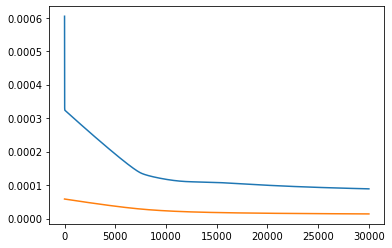

In [19]:
import matplotlib.pyplot as plt
plt.plot(Val_loss);
plt.plot(Train_loss);


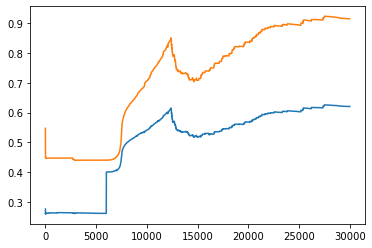

In [20]:
plt.plot(F1score)
plt.plot(Accuracy)

In [23]:
Xtrain_data.shape

torch.Size([74100, 7])

In [26]:
(Xtrain_data[:,-1]==0).sum()

tensor(42198)

In [27]:
(Xtrain_data[:,-1]>0).sum()

tensor(1938)

In [28]:
(Xtrain_data[:,-1]<0).sum()

tensor(29964)